In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
from urllib.request import urlretrieve
from IPython.core.display import display, HTML

%matplotlib inline

In [2]:
import geopandas as gpd
from typing import Dict, List, Union, Optional
from textwrap import wrap
import missingno as msno
from shapely.geometry import Point
from scipy.spatial import cKDTree
import itertools
from operator import itemgetter

In [3]:
pd.options.display.max_columns = None
# pd.set_option("display.max_columns", None)
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
import utils

In [5]:
dir(utils)

['Dict',
 'List',
 'Optional',
 'Union',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'clean_cc_real_estate_sales_arms_length_col',
 'clean_cc_real_estate_sales_data',
 'clean_cc_real_estate_sales_date_cols',
 'clean_cc_real_estate_sales_deed_type_col',
 'clean_cc_residential_neighborhood_geodata',
 'clean_cc_residential_prop_chars_apartments_col',
 'clean_cc_residential_prop_chars_attic_finish_col',
 'clean_cc_residential_prop_chars_attic_type_col',
 'clean_cc_residential_prop_chars_basement_col',
 'clean_cc_residential_prop_chars_basement_finish_col',
 'clean_cc_residential_prop_chars_bedrooms_col',
 'clean_cc_residential_prop_chars_central_air_col',
 'clean_cc_residential_prop_chars_central_heating_col',
 'clean_cc_residential_prop_chars_condo_class_factor_col',
 'clean_cc_residential_prop_chars_design_plan_col',
 'clean_cc_residential_prop_chars_fireplaces_col',
 'clean_cc_residential_prop_chars_half_baths_col',


https://datacatalog.cookcountyil.gov/Property-Taxation/Cook-County-Assessor-s-Residential-Property-Charac/bcnq-qi2z

In [6]:
cc_res_prop_char_df = utils.get_raw_cc_residential_property_characteristics_data()
cc_res_prop_char_df = cc_res_prop_char_df.convert_dtypes()

In [8]:
cc_res_prop_char_df = utils.clean_cc_residential_prop_chars_property_class_col(
    df=cc_res_prop_char_df
)

* **PIN**
    * Unique Permanent Identification Number for each property. All PINs are 14 digits: 2 digits for area + 2 digits for sub area + 2 digits for block + 2 digits for parcel + 4 digits for the multicode

* **Tax Year**
    * Tax year of sale. Tax year referrs to the year in which taxes due. Taxes are billed a year in arrears. If a sale ocurred in calendar year 2018, it will be in tax year 2019.
    
No real issues in this feature.

In [14]:
cc_res_prop_char_df["Tax Year"].value_counts(dropna=False)

2019    1583785
2018     411323
NaN           0
Name: Tax Year, dtype: Int64

### **Neighborhood Code**
    * Neighborhood code as assigned by the Assessment office. An interactive map is available at https://maps.cookcountyil.gov/cookviewer/.

In [16]:
cc_res_prop_char_df["Neighborhood Code"].value_counts(dropna=False)

30     110964
10      92851
70      71885
50      71720
31      70803
        ...  
580        55
145        50
599         4
999         1
NaN         0
Name: Neighborhood Code, Length: 200, dtype: Int64

In [21]:
cc_res_prop_char_df["Neighborhood Code"] = cc_res_prop_char_df["Neighborhood Code"].astype("string")
cc_res_prop_char_df["Neighborhood Code"] = cc_res_prop_char_df["Neighborhood Code"].str.zfill(3)
cc_res_prop_char_df["Neighborhood Code"] = cc_res_prop_char_df["Neighborhood Code"].astype("category")

In [23]:
def clean_cc_residential_prop_chars_neighborhood_code_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    df["Neighborhood Code"] = df["Neighborhood Code"].astype("string")
    df["Neighborhood Code"] = df["Neighborhood Code"].str.zfill(3)
    df["Neighborhood Code"] = df["Neighborhood Code"].astype("category")
    return df

In [22]:
cc_res_prop_char_df["Neighborhood Code"].value_counts(dropna=False)

030    110964
010     92851
070     71885
050     71720
031     70803
        ...  
038        85
580        55
145        50
599         4
999         1
Name: Neighborhood Code, Length: 199, dtype: int64

### **Land Square Feet**
    * Square feet of the land (not just the building) of the property. Note that land is divided into 'plots' and 'parcels' - this field applies to parcels, identified by PIN.

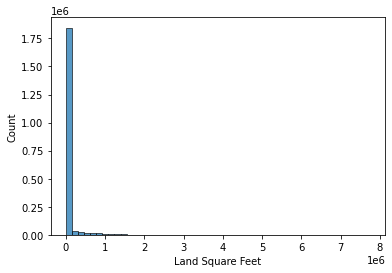

In [25]:
ax = sns.histplot(data=cc_res_prop_char_df, x="Land Square Feet", bins=50)

(0.0, 100000.0)

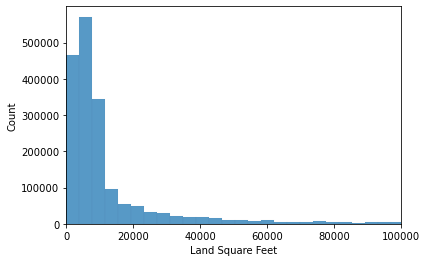

In [30]:
ax = sns.histplot(data=cc_res_prop_char_df, x="Land Square Feet", bins=2000)
ax.set_xlim(0, 100000)

### Town Code
* Township code as assigned by the Assessment office. An interactive map is available at https://maps.cookcountyil.gov/cookviewer/.

In [33]:
cc_res_prop_char_df["Town Code"] = cc_res_prop_char_df["Town Code"].astype("string")
cc_res_prop_char_df["Town Code"] = cc_res_prop_char_df["Town Code"].astype("category")

In [35]:
def clean_cc_residential_prop_chars_town_code_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    df["Town Code"] = df["Town Code"].astype("string")
    df["Town Code"] = df["Town Code"].astype("category")
    return df

In [34]:
cc_res_prop_char_df["Town Code"].value_counts(dropna=False)

72    151861
71    139753
77    112670
38    111341
22     97889
73     92470
35     88665
70     82673
24     82146
29     80601
74     71093
25     65521
18     63240
76     60728
37     60075
16     58389
20     57156
39     57069
31     48072
17     44716
23     42817
13     40605
21     38040
28     37161
12     30131
32     26303
75     20300
30     20140
26     18204
27     17328
15     14529
11     14121
36     13164
10     12512
19      8006
34      5908
14      5439
33      4272
Name: Town Code, dtype: int64

### Type of Residence
* Type of residence - 1 = one story, 2 = two-story, 3 = three-story or higher, 4 = split level, 5 = 1.5 story, 6 = 1.6 story, 7 = 1.7 story , 8 = 1.8 story , 9 = 1.9 story (Note: residences with 1.5 - 1.9 stories are one story and have partial livable attics and are classified based on the square footage of the attic compared to the first floor of the house. So, 1.5 story houses have an attic that is 50% of the area of the first floor, 1.6 story houses are 60%, 1.7 are 70%, etc. However, what is recorded on the field card differs from what is in the database. All 1.5 - 1.9 story houses are coded as 5).

In [36]:
cc_res_prop_char_df["Type of Residence"].value_counts(dropna=False)

NaN    602055
2      552786
1      540166
4      130510
5      130080
3       39398
7          39
8          33
6          23
9          18
Name: Type of Residence, dtype: Int64

In [37]:
def clean_cc_residential_prop_chars_type_of_residence_col(df: pd.DataFrame) -> pd.DataFrame:
    type_of_residence_map = {
        1: "one story",
        2: "two story",
        3: "three story or higher",
        4: "split level",
        5: "1.5 story (one story w/ partial livable attic; 50% sq footage of 1st floor)",
        6: "1.6 story (one story w/ partial livable attic; 60% sq footage of 1st floor)",
        7: "1.7 story (one story w/ partial livable attic; 70% sq footage of 1st floor)",
        8: "1.8 story (one story w/ partial livable attic; 80% sq footage of 1st floor)",
        9: "1.9 story (one story w/ partial livable attic; 90% sq footage of 1st floor)" 
    }
    if "one story" not in df["Type of Residence"].unique():
        df["Type of Residence"] = df["Type of Residence"].map(type_of_residence_map)
    df["Type of Residence"] = df["Type of Residence"].astype("category")
    return df

In [ ]:
type_of_residence_map = {
    1: "one story",
    2: "two story",
    3: "three story or higher",
    4: "split level",
    5: "1.5 story (one story w/ partial livable attic; 50% sq footage of 1st floor)",
    6: "1.6 story (one story w/ partial livable attic; 60% sq footage of 1st floor)",
    7: "1.7 story (one story w/ partial livable attic; 70% sq footage of 1st floor)",
    8: "1.8 story (one story w/ partial livable attic; 80% sq footage of 1st floor)",
    9: "1.9 story (one story w/ partial livable attic; 90% sq footage of 1st floor)" 
}

In [38]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_type_of_residence_col(cc_res_prop_char_df)

In [39]:
cc_res_prop_char_df["Type of Residence"].value_counts(dropna=False)

NaN                                                                            602055
two story                                                                      552786
one story                                                                      540166
split level                                                                    130510
1.5 story (one story w/ partial livable attic; 50% sq footage of 1st floor)    130080
three story or higher                                                           39398
1.7 story (one story w/ partial livable attic; 70% sq footage of 1st floor)        39
1.8 story (one story w/ partial livable attic; 80% sq footage of 1st floor)        33
1.6 story (one story w/ partial livable attic; 60% sq footage of 1st floor)        23
1.9 story (one story w/ partial livable attic; 90% sq footage of 1st floor)        18
Name: Type of Residence, dtype: int64

### Apartments
* Number of apartments in the building - 2 = Two, 3 = Three, 4 = Four, 5 = Five, 6 = Six, 0 = None

Hmm. It's not clear what -5 means. I've spotchecked a few of the -5 properties in Google Maps and it hasn't meant a consistent number of apartments. For the small sample I checked, it was mostly 0 or 1.

The 8s and 9 largely appear to be single family homes. I'm going to wipe out that spurious info. In this pull, it's 442 out of nearly 2 million records.

In [40]:
cc_res_prop_char_df["Apartments"].value_counts(dropna=False)

0      1225156
NaN     602017
2        98871
3        36626
4        15621
6        12984
5         3391
-5         436
8            5
9            1
Name: Apartments, dtype: Int64

In [49]:
cc_res_prop_char_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1995108 entries, 0 to 1995107
Data columns (total 83 columns):
 #   Column                                           Dtype   
---  ------                                           -----   
 0   PIN                                              Int64   
 1   Property Class                                   category
 2   Tax Year                                         Int64   
 3   Neighborhood Code                                category
 4   Land Square Feet                                 Int64   
 5   Town Code                                        category
 6   Type of Residence                                category
 7   Apartments                                       Int64   
 8   Wall Material                                    Int64   
 9   Roof Material                                    Int64   
 10  Rooms                                            Int64   
 11  Bedrooms                                         Int64   
 12  

In [50]:
bad_apartment_value_mask = (
    (cc_res_prop_char_df["Apartments"] < 0) | 
    (cc_res_prop_char_df["Apartments"] > 6)
)

In [51]:
cc_res_prop_char_df.loc[bad_apartment_value_mask]

,PIN,Property Class,Tax Year,Neighborhood Code,Land Square Feet,Town Code,Type of Residence,Apartments,Wall Material,Roof Material,Rooms,Bedrooms,Basement,Basement Finish,Central Heating,Other Heating,Central Air,Fireplaces,Attic Type,Attic Finish,Half Baths,Design Plan,Cathedral Ceiling,Construction Quality,Renovation,Site Desireability,Garage 1 Size,Garage 1 Material,Garage 1 Attachment,Garage 1 Area,Garage 2 Size,Garage 2 Material,Garage 2 Attachment,Garage 2 Area,Porch,Other Improvements,Building Square Feet,Repair Condition,Multi Code,Number of Commercial Units,Prior Tax Year Market Value Estimate (Land),Prior Tax Year Market Value Estimate (Building),Date of Most Recent Sale,Deed No.,Sale Price,Longitude,Latitude,Census Tract,Total Building Square Feet,Multi Property Indicator,Property Address,Modeling Group,Full Baths,Age,Use,Number of Units,Percent Ownership,Condo Class Factor,Multi-Family Indicator,Large Lot,"Condition, Desirability and Utility",Deed Type,O'Hare Noise,Floodplain,Near Major Road,Total Units,Condo Strata,Age Squared,Age Decade,Age Decade Squared,Lot Size Squared,Improvement Size Squared,Location Factor,Garage indicator,Residential share of building,Pure Market Sale,Pure Market Filter,Neigborhood Code (mapping),Square root of lot size,Square root of age,Square root of improvement size,Town and Neighborhood,Property Class Descr
109877,4094040170000,211,2018,132,16740,25,two story,8,2,1,8,4,1,1,2,5,0,0,3,<NA>,1,2,2,2,1,2,3,2,2,2,7,0,0,0,1,0,2678,2,3,0,179950,358150,<NA>,<NA>,<NA>,-87.829191,42.128678,801702,<NA>,0,1317 FIRST ST NORTHBROOK,MF,3,118,1,<NA>,<NA>,<NA>,211,0,<NA>,<NA>,0,0,1,1,<NA>,13924,11.8,139.24,280227600,7171684,1.559059,1,<NA>,0,0,132,129.383152,10.86278,51.749396,25132,appartment_bldg_w_2_to_6_units__any_age
323375,10134210120000,211,2018,130,5040,17,two story,8,1,1,13,6,1,1,2,5,1,0,1,1,0,2,2,2,1,2,3,2,2,2,7,0,0,0,3,0,2459,2,2,0,42840,277360,<NA>,<NA>,<NA>,-87.69548,42.043752,809600,<NA>,0,1424 FLORENCE AVE EVANSTON,MF,2,118,1,<NA>,<NA>,<NA>,211,0,<NA>,<NA>,0,0,0,1,<NA>,13924,11.8,139.24,25401600,6046681,1.265702,1,<NA>,0,0,130,70.992957,10.86278,49.588305,17130,appartment_bldg_w_2_to_6_units__any_age
349437,10242140170000,211,2018,210,5445,17,two story,8,2,2,9,4,1,1,1,5,1,0,3,<NA>,0,2,2,2,1,2,3,1,2,2,7,0,0,0,3,0,2600,2,2,0,54450,313060,<NA>,<NA>,<NA>,-87.698111,42.037102,809700,<NA>,0,1038 DARROW AVE EVANSTON,MF,4,91,1,<NA>,<NA>,<NA>,211,0,<NA>,<NA>,0,0,0,1,<NA>,8281,9.1,82.81,29648025,6760000,1.101032,1,<NA>,0,0,210,73.790243,9.539392,50.990195,17210,appartment_bldg_w_2_to_6_units__any_age
350649,10244140240000,211,2018,110,4960,17,two story,8,1,1,7,3,1,1,1,5,1,0,1,1,2,2,2,2,<NA>,2,3,1,2,2,7,0,0,0,3,0,3670,2,3,0,49600,369280,<NA>,<NA>,<NA>,-87.692703,42.030657,810302,<NA>,0,708 WESLEY AVE EVANSTON,MF,4,130,1,<NA>,<NA>,<NA>,211,0,<NA>,<NA>,0,0,0,1,<NA>,16900,13.0,169.0,24601600,13468900,0.96389,1,<NA>,0,0,110,70.427267,11.401754,60.580525,17110,appartment_bldg_w_2_to_6_units__any_age
372524,11193030170000,211,2018,080,3838,17,two story,9,1,1,8,5,3,3,2,5,1,0,2,1,0,2,2,2,1,2,0,0,0,0,7,0,0,0,3,0,3794,2,2,0,51810,563840,<NA>,<NA>,<NA>,-87.681893,42.032919,810100,<NA>,0,821 SHERMAN AVE EVANSTON,MF,3,109,1,<NA>,<NA>,<NA>,211,0,<NA>,<NA>,0,0,0,1,<NA>,11881,10.9,118.81,14730244,14394436,0.955599,0,<NA>,0,0,80,61.951594,10.440307,61.595454,1780,appartment_bldg_w_2_to_6_units__any_age
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1979548,32203070010000,211,2019,085,5000,12,one story,-5,1,1,7,3,1,3,1,5,0,1,2,3,0,2,2,2,<NA>,2,1,1,2,2,7,0,0,0,3,0,1536,2,2,0,15000,57860,<NA>,<NA>,<NA>,-87.649879,41.5049,829200,<NA>,0,204 14TH PL,MF,2,113,1,<NA>,<NA>,<NA>,211,<NA>,<NA>,<NA>,0,0,0,1,<NA>,12769,11.3,127.69,25000000,2359

In [57]:
def clean_cc_residential_prop_chars_apartments_col(df: pd.DataFrame) -> pd.DataFrame:
    bad_apartment_value_mask = (df["Apartments"] < 0) | (df["Apartments"] > 6)
    df.loc[bad_apartment_value_mask, "Apartments"] = None
    df["Apartments"] = df["Apartments"].astype("Int8")
    return df

In [58]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_apartments_col(cc_res_prop_char_df)

In [59]:
cc_res_prop_char_df["Apartments"].value_counts(dropna=False)

0      1225156
NaN     602459
2        98871
3        36626
4        15621
6        12984
5         3391
Name: Apartments, dtype: Int64

In [46]:
# cc_res_prop_char_df.loc[cc_res_prop_char_df["Apartments"] == -5]

In [48]:
cc_res_prop_char_df.loc[
    (cc_res_prop_char_df["Apartments"] == 9 ), 
    ["Latitude", "Longitude", "Property Address"]
]

,Latitude,Longitude,Property Address
372524,42.032919,-87.681893,821 SHERMAN AVE EVANSTON


In [45]:
cc_res_prop_char_df.loc[
    (cc_res_prop_char_df["Apartments"] == -5), 
    ["Latitude", "Longitude", "Property Address"]
]

,Latitude,Longitude,Property Address
550216,42.134037,-87.760688,383 PARK AVE
551980,42.11646,-87.743057,911 GREEN BAY RD
600342,41.992855,-88.185329,130 W BARTLETT AVE
693665,42.04808,-87.885139,1568 HILLS AVE
706157,42.027095,-87.854155,1081 RAND RD
...,...,...,...
1979548,41.5049,-87.649879,204 14TH PL
1983996,41.494081,-87.626774,242 23RD ST
1984112,41.492677,-87.628532,2422 BUTLER ST
1984438,41.491353,-87.629172,194 26TH ST


### Wall Material
* Exterior wall material - 1=Wood, 2=Masonry, 3=Wood&Masonry, 4=Stucco

In [60]:
cc_res_prop_char_df["Wall Material"].value_counts(dropna=False)

NaN    602055
2      571285
1      447881
3      352329
4       21558
Name: Wall Material, dtype: Int64

In [61]:
def clean_cc_residential_prop_chars_wall_material_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    wall_material_map = {
        1: "Wood",
        2: "Masonry",
        3: "Wood and Masonry",
        4: "Stucco"
    }
    if "Wood" not in df["Wall Material"].unique():        
        df["Wall Material"] = df["Wall Material"].map(wall_material_map)
    df["Wall Material"] = df["Wall Material"].astype("category")
    return df

In [62]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_wall_material_col(cc_res_prop_char_df)

In [63]:
cc_res_prop_char_df["Wall Material"].value_counts(dropna=False)

NaN                 602055
Masonry             571285
Wood                447881
Wood and Masonry    352329
Stucco               21558
Name: Wall Material, dtype: int64

### Roof Material
* Roof construction material. 1 = Shingle/Asphalt, 2 = Tar & Gravel, 3 = Slate, 4 = Shake, 5 = Tile, 6 = Other

In [64]:
cc_res_prop_char_df["Roof Material"].value_counts(dropna=False)

1      1263767
NaN     602055
2        93705
4        14879
5         7996
6         6936
3         5770
Name: Roof Material, dtype: Int64

In [65]:
def clean_cc_residential_prop_chars_roof_material_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    roof_material_map = {
        1: "Shingle/Asphalt",
        2: "Tar and Gravel",
        3: "Slate",
        4: "Shake",
        5: "Tile",
        6: "Other"
    }
    if "Shingle/Asphalt" not in df["Roof Material"].unique():        
        df["Roof Material"] = df["Roof Material"].map(roof_material_map)
    df["Roof Material"] = df["Roof Material"].astype("category")
    return df

In [66]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_roof_material_col(cc_res_prop_char_df)

In [67]:
cc_res_prop_char_df["Roof Material"].value_counts(dropna=False)

Shingle/Asphalt    1263767
NaN                 602055
Tar and Gravel       93705
Shake                14879
Tile                  7996
Other                 6936
Slate                 5770
Name: Roof Material, dtype: int64

### Rooms
* 	
Number of rooms in the property (excluding baths). Not to be confused with bedrooms.

In [68]:
cc_res_prop_char_df["Rooms"].value_counts(dropna=False)

NaN    602055
6      355237
5      297086
7      220519
8      179319
4       94048
9       77791
10      54773
12      29025
11      19413
15       8885
3        8490
14       7537
18       7280
16       7090
13       5562
24       4264
20       3582
30       2557
17       1862
21       1620
22       1130
36        851
23        744
19        736
27        706
29        521
26        469
25        451
28        444
2         352
35        159
42        130
32        109
34         81
33         59
40         53
31         42
38         19
48         18
39          8
37          6
41          6
46          4
44          3
49          2
50          2
47          2
210         1
320         1
64          1
180         1
241         1
80          1
Name: Rooms, dtype: Int64

In [70]:
cc_res_prop_char_df.loc[
    cc_res_prop_char_df["Rooms"] > 100,
    ["Latitude", "Longitude", "Property Address", "Land Square Feet", "Rooms"]
]

,Latitude,Longitude,Property Address,Land Square Feet,Rooms
955791,41.927637,-87.71987,2540 N LAWNDALE AVE,3250,210
1178621,41.896902,-87.754779,900 N LEAMINGTON AVE,4677,320
1204136,41.871088,-87.716653,3626 W POLK ST,3100,180
1232917,41.846955,-87.69168,2631 W LUTHER ST,1800,241


Based on Google Maps, these properties with more than 100 rooms are just regular apartments (as implied by the square footage). Those room counts are not good.

In [71]:
def clean_cc_residential_prop_chars_rooms_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    bad_rooms_value_mask = (df["Rooms"] > 100)
    df.loc[bad_rooms_value_mask, "Rooms"] = None
    df["Rooms"] = df["Rooms"].astype("Int8")
    return df

In [72]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_rooms_col(cc_res_prop_char_df)

In [73]:
cc_res_prop_char_df["Rooms"].value_counts(dropna=False)

NaN    602059
6      355237
5      297086
7      220519
8      179319
4       94048
9       77791
10      54773
12      29025
11      19413
15       8885
3        8490
14       7537
18       7280
16       7090
13       5562
24       4264
20       3582
30       2557
17       1862
21       1620
22       1130
36        851
23        744
19        736
27        706
29        521
26        469
25        451
28        444
2         352
35        159
42        130
32        109
34         81
33         59
40         53
31         42
38         19
48         18
39          8
41          6
37          6
46          4
44          3
47          2
50          2
49          2
64          1
80          1
Name: Rooms, dtype: Int64

### Bedrooms
* 	Number of bedrooms in the property, defined based on building squarefoot and the judgement of the person in the field. 

In [74]:
cc_res_prop_char_df["Bedrooms"].value_counts(dropna=False)

3      634305
NaN    602055
4      388124
2      192795
5       79508
6       55409
8       12439
9        7454
12       6849
7        6263
1        3867
10       2423
11       1497
18       1213
15        296
14        214
16        140
13        115
24         52
20         42
19         16
17         14
21          5
22          4
23          3
34          2
66          1
90          1
30          1
25          1
Name: Bedrooms, dtype: Int64

In [76]:
cc_res_prop_char_df.loc[
    cc_res_prop_char_df["Bedrooms"] > 50,
    ["Latitude", "Longitude", "Property Address", "Land Square Feet", "Bedrooms"]
]

,Latitude,Longitude,Property Address,Land Square Feet,Bedrooms
951161,41.926468,-87.70149,2436 N RICHMOND ST,3150,66
1204136,41.871088,-87.716653,3626 W POLK ST,3100,90


Nope. No way those properties have more than 12 bedrooms.

In [78]:
cc_res_prop_char_df.loc[
    (cc_res_prop_char_df["Bedrooms"] > 25) & (cc_res_prop_char_df["Bedrooms"] < 50),
    ["Latitude", "Longitude", "Property Address", "Land Square Feet", "Bedrooms"]
]

,Latitude,Longitude,Property Address,Land Square Feet,Bedrooms
706766,42.036066,-87.84204,8632 W STOLTING RD,9350,34
990746,41.916455,-87.702841,1924 N HUMBOLDT BLVD,8750,34
1548078,41.811489,-87.614668,444 E 46TH ST,6250,30


Some of those are plausible.

In [81]:
def clean_cc_residential_prop_chars_bedrooms_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    bad_bedrooms_value_mask = (df["Bedrooms"] > 50)
    df.loc[bad_bedrooms_value_mask, "Bedrooms"] = None
    df["Bedrooms"] = df["Bedrooms"].astype("Int8")
    return df

In [82]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_bedrooms_col(cc_res_prop_char_df)

In [83]:
cc_res_prop_char_df["Bedrooms"].value_counts(dropna=False)

3      634305
NaN    602057
4      388124
2      192795
5       79508
6       55409
8       12439
9        7454
12       6849
7        6263
1        3867
10       2423
11       1497
18       1213
15        296
14        214
16        140
13        115
24         52
20         42
19         16
17         14
21          5
22          4
23          3
34          2
30          1
25          1
Name: Bedrooms, dtype: Int64

### Basement
* Basement type - 1 = Full, 2 = Slab, 3 = Partial, 4 = Crawl 

In [84]:
cc_res_prop_char_df["Basement"].value_counts(dropna=False)

1      802554
NaN    602055
3      335929
2      173863
4       80707
Name: Basement, dtype: Int64

In [87]:
def clean_cc_residential_prop_chars_basement_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    basement_map = {
        1: "Full",
        2: "Slab",
        3: "Partial",
        4: "Crawl" 
    }    
    if "Full" not in df["Basement"].unique():
        df["Basement"] = df["Basement"].map(basement_map)
    df["Basement"] = df["Basement"].astype("category")
    return df

In [88]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_basement_col(cc_res_prop_char_df)

In [89]:
cc_res_prop_char_df["Basement"].value_counts(dropna=False)

Full       802554
NaN        602055
Partial    335929
Slab       173863
Crawl       80707
Name: Basement, dtype: int64

### Basement Finish
* Basement finish - 1 = Formal rec room; 2 = Apartment; 3 = Unfinished

In [90]:
cc_res_prop_char_df["Basement Finish"].value_counts(dropna=False)

3      943088
NaN    602058
1      425857
2       24105
Name: Basement Finish, dtype: Int64

In [91]:
def clean_cc_residential_prop_chars_basement_finish_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    basement_finish_map= {
        1: "Formal rec room",
        2: "Apartment",
        3: "Unfinished"
    }    
    if "Apartment" not in df["Basement Finish"].unique():
        df["Basement Finish"] = df["Basement Finish"].map(basement_finish_map)
    df["Basement Finish"] = df["Basement Finish"].astype("category")
    return df

In [92]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_basement_finish_col(cc_res_prop_char_df)

In [93]:
cc_res_prop_char_df["Basement Finish"].value_counts(dropna=False)

Unfinished         943088
NaN                602058
Formal rec room    425857
Apartment           24105
Name: Basement Finish, dtype: int64

### Central Heating
* Central heating type - 1 = Warm air, 2 = Hot water steam, 3 = Electric, 4 = Other

In [95]:
cc_res_prop_char_df["Central Heating"].value_counts(dropna=False)

1      1193596
NaN     602055
2       199457
Name: Central Heating, dtype: Int64

In [96]:
def clean_cc_residential_prop_chars_central_heating_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    central_heating_map = {
        1: "Warm air",
        2: "Hot water steam",
        3: "Electric", 
        4: "Other"    
    }  
    if "Warm air" not in df["Central Heating"].unique():
        df["Central Heating"] = df["Central Heating"].map(central_heating_map)
    df["Central Heating"] = df["Central Heating"].astype("category")
    return df

In [97]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_central_heating_col(cc_res_prop_char_df)

In [98]:
cc_res_prop_char_df["Central Heating"].value_counts(dropna=False)

Warm air           1193596
NaN                 602055
Hot water steam     199457
Name: Central Heating, dtype: int64

### Other Heating
* Other heating type - 1 = Floor furnace, 2 = Unit heater, 3 = Stove, 4 = Solar, 5 = none

In [99]:
cc_res_prop_char_df["Other Heating"].value_counts(dropna=False)

5      1350200
NaN     602017
2        42891
Name: Other Heating, dtype: Int64

In [100]:
def clean_cc_residential_prop_chars_other_heating_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    other_heating_map = {
        1: "Floor furnace",
        2: "Unit heater",
        3: "Stove",
        4: "Solar", 
        5: "none"
    } 
    if "none" not in df["Other Heating"].unique():
        df["Other Heating"] = df["Other Heating"].map(other_heating_map)
    df["Other Heating"] = df["Other Heating"].astype("category")
    return df

In [101]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_central_heating_col(cc_res_prop_char_df)

In [102]:
cc_res_prop_char_df["Other Heating"].value_counts(dropna=False)

none           1350200
NaN             602017
Unit heater      42891
Name: Other Heating, dtype: int64

### Central Air
* Is central airconditioning present? - 1 = yes, 2 = no

In [103]:
cc_res_prop_char_df["Central Air"].value_counts(dropna=False)

1      723431
0      669622
NaN    602055
Name: Central Air, dtype: Int64

Hmm. 

In [112]:
neighborhoods_gdf = utils.get_raw_cc_residential_neighborhood_geodata()

In [113]:
neighborhoods_gdf.head(2)

,nbhd,town_nbhd,township_c,township_n,triad_code,triad_name,geometry
0,060,29060,29,Palatine,2,North,"POLYGON ((-88.00465 42.09562, -88.00467 42.093..."
1,120,32120,32,Rich,3,South,"POLYGON ((-87.67426 41.49161, -87.67426 41.491..."


In [123]:
neighborhoods_gdf["township_n"].value_counts()

Rich             50
Lake             49
Bloom            43
Jefferson        42
Schaumburg       40
Bremen           39
Worth            36
Northfield       35
Thornton         34
Lyons            33
Proviso          33
Wheeling         31
Hyde Park        27
Orland           27
Maine            26
West Chicago     25
Palatine         24
Palos            23
New Trier        23
Lake View        22
Hanover          19
Evanston         18
Elk Grove        16
Niles            16
Leyden           12
Lemont           11
Barrington       11
Cicero           11
Oak Park         11
Stickney          9
South Chicago     9
Rogers Park       9
Berwyn            7
Riverside         6
North Chicago     5
Norwood Park      5
River Forest      5
Calumet           4
Name: township_n, dtype: int64

In [148]:
neighborhoods_gdf.loc[neighborhoods_gdf["township_n"] == "Evanston"]

,nbhd,town_nbhd,township_c,township_n,triad_code,triad_name,geometry
12,050,17050,17,Evanston,2,North,"POLYGON ((-87.67724 42.05119, -87.67726 42.051..."
49,112,17112,17,Evanston,2,North,"POLYGON ((-87.66743 42.02663, -87.66700 42.026..."
55,110,17110,17,Evanston,2,North,"POLYGON ((-87.68995 42.03401, -87.68996 42.033..."
87,120,17120,17,Evanston,2,North,"POLYGON ((-87.68819 42.06418, -87.68819 42.064..."
104,130,17130,17,Evanston,2,North,"POLYGON ((-87.70829 42.04822, -87.70607 42.048..."
117,011,17011,17,Evanston,2,North,"POLYGON ((-87.72019 42.05895, -87.72020 42.055..."
121,013,17013,17,Evanston,2,North,"POLYGON ((-87.68819 42.06418, -87.68882 42.063..."
193,210,17210,17,Evanston,2,North,"POLYGON ((-87.69453 42.04120, -87.69453 42.041..."
212,200,17200,17,Evanston,2,North,"POLYGON ((-87.71294 42.06444, -87.71293 42.064..."
661,060,17060,17,Evanston,2,North,"POLYGON ((-87.70821 42.05229, -87.70430 42.053..."


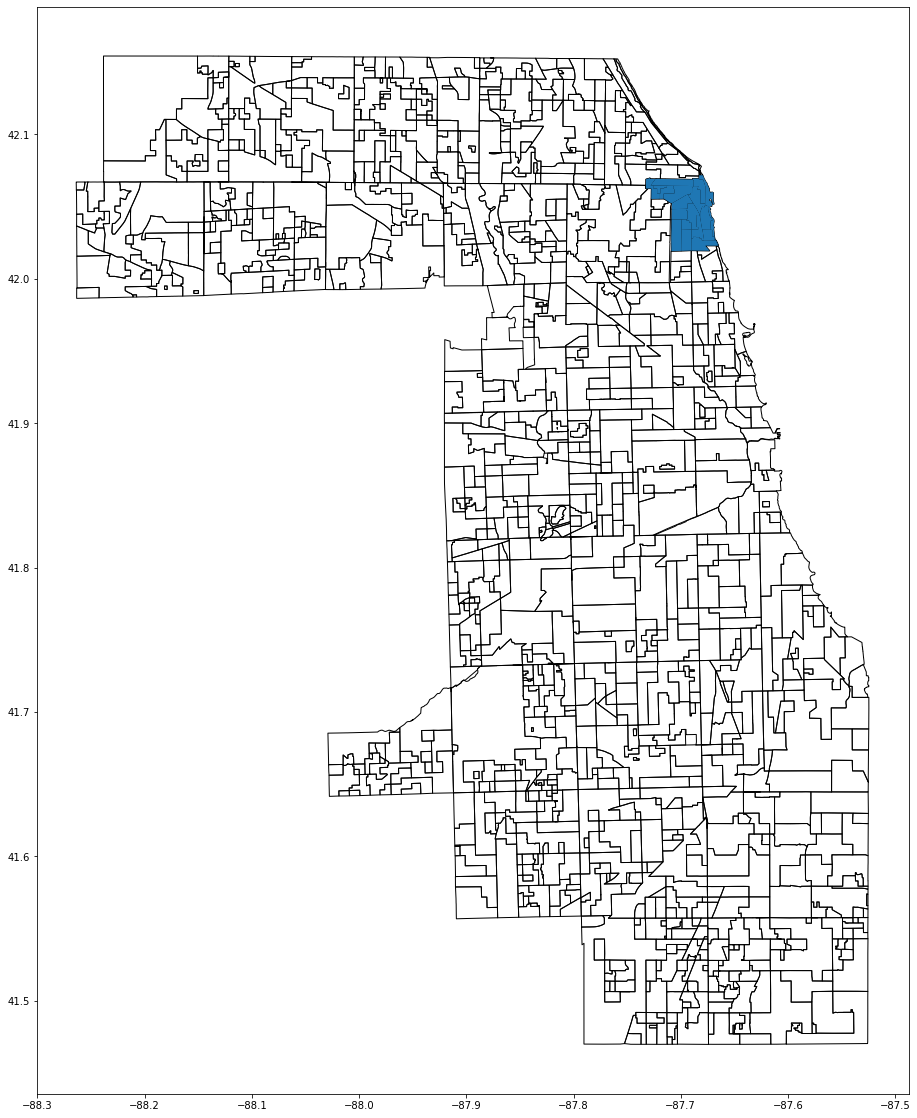

In [147]:
fig, ax = plt.subplots(figsize=(20,20))

ax = neighborhoods_gdf.plot(color="none", ax=ax)
ax = neighborhoods_gdf.loc[neighborhoods_gdf["township_n"] == "Evanston"].plot(ax=ax)

In [136]:
cc_res_prop_char_df["Town Code"].value_counts()

72    151861
71    139753
77    112670
38    111341
22     97889
73     92470
35     88665
70     82673
24     82146
29     80601
74     71093
25     65521
18     63240
76     60728
37     60075
16     58389
20     57156
39     57069
31     48072
17     44716
23     42817
13     40605
21     38040
28     37161
12     30131
32     26303
75     20300
30     20140
26     18204
27     17328
15     14529
11     14121
36     13164
10     12512
19      8006
34      5908
14      5439
33      4272
Name: Town Code, dtype: int64

In [138]:
cc_res_prop_char_df.loc[
    (cc_res_prop_char_df["Central Air"] == 1) &
    (cc_res_prop_char_df["Town Code"] == "27"),
#     (cc_res_prop_char_df["Property Address"].str.contains("OAK PARK")),
    ["Latitude", "Longitude", "Property Address", "Land Square Feet", "Central Air"]
].shape

(4934, 5)

In [139]:
cc_res_prop_char_df.loc[
    (cc_res_prop_char_df["Central Air"] == 0) &
    (cc_res_prop_char_df["Town Code"] == "27"),
#     (cc_res_prop_char_df["Property Address"].str.contains("OAK PARK")),
    ["Latitude", "Longitude", "Property Address", "Land Square Feet", "Central Air"]
].shape

(6451, 5)

In [152]:
cc_res_prop_char_df.loc[
    (cc_res_prop_char_df["Central Air"] == 1) &
    (cc_res_prop_char_df["Town Code"] == "17") & 
    (cc_res_prop_char_df["Property Address"].str.contains("LAKE SHORE B")),
    ["Latitude", "Longitude", "Property Address", "Land Square Feet", "Central Air"]
].shape

(24, 5)

In [153]:
cc_res_prop_char_df.loc[
    (cc_res_prop_char_df["Central Air"] == 0) &
    (cc_res_prop_char_df["Town Code"] == "17") & 
    (cc_res_prop_char_df["Property Address"].str.contains("LAKE SHORE B")),
    ["Latitude", "Longitude", "Property Address", "Land Square Feet", "Central Air"]
].shape

(14, 5)

In [155]:
cc_res_prop_char_df.loc[
    (cc_res_prop_char_df["Central Air"] == 1) &
    (cc_res_prop_char_df["Town Code"] == "17") & 
    (cc_res_prop_char_df["Property Address"].str.contains("LAKE SHORE B")),
    ["Latitude", "Longitude", "Property Address", "Land Square Feet", "Central Air"]
]

,Latitude,Longitude,Property Address,Land Square Feet,Central Air
371320,42.039786,-87.670791,1214 LAKE SHORE BLVD EVANSTON,8113,1
371321,42.039637,-87.670882,1212 LAKE SHORE BLVD EVANSTON,10415,1
371458,42.038932,-87.670953,1140 LAKE SHORE BLVD EVANSTON,17500,1
371459,42.038684,-87.670956,1136 LAKE SHORE BLVD EVANSTON,14175,1
371460,42.038448,-87.670959,1130 LAKE SHORE BLVD EVANSTON,15750,1
371461,42.038448,-87.670959,1130 LAKE SHORE BLVD EVANSTON,15750,1
371462,42.038201,-87.670963,1120 LAKE SHORE BLVD EVANSTON,15750,1
371464,42.037957,-87.670966,1114 LAKE SHORE BLVD EVANSTON,15313,1
371838,42.03729,-87.671115,1044 LAKE SHORE BLVD EVANSTON,10154,1
371842,42.036094,-87.671068,1012 LAKE SHORE BLVD EVANSTON,18300,1


In [156]:
cc_res_prop_char_df.loc[
    (cc_res_prop_char_df["Central Air"] == 0) &
    (cc_res_prop_char_df["Town Code"] == "17") & 
    (cc_res_prop_char_df["Property Address"].str.contains("LAKE SHORE B")),
    ["Latitude", "Longitude", "Property Address", "Land Square Feet", "Central Air"]
]

,Latitude,Longitude,Property Address,Land Square Feet,Central Air
371463,42.038201,-87.670963,1120 LAKE SHORE BLVD EVANSTON,15750,0
371465,42.037957,-87.670966,1114 LAKE SHORE BLVD EVANSTON,15313,0
371839,42.037093,-87.671107,1040 LAKE SHORE BLVD EVANSTON,11775,0
371840,42.03637,-87.671079,1020 LAKE SHORE BLVD EVANSTON,17600,0
371841,42.03637,-87.671079,1020 LAKE SHORE BLVD EVANSTON,17600,0
371843,42.035819,-87.671057,1000 LAKE SHORE BLVD EVANSTON,19000,0
371847,42.036586,-87.671087,1024 LAKE SHORE BLVD EVANSTON,9352,0
795607,42.038201,-87.670963,1120 LAKE SHORE BLVD,15750,0
795609,42.037957,-87.670966,1114 LAKE SHORE BLVD,15313,0
795975,42.037093,-87.671107,1040 LAKE SHORE BLVD,11775,0


It's kind of hard to be certain as I wasn't able to make out external AC radiators, but based on a lot of inspection, wealthier looking streets tend to have values of **1**, so I'm going to assume **0** corresponds with a no here, despite the mapping provided on the data description page.

These Evenston properties on Lake Shore Blvd make me pretty confident.

In [161]:
def clean_cc_residential_prop_chars_central_air_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    df["Central Air"] = df["Central Air"].astype("boolean")
    return df

In [162]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_central_air_col(cc_res_prop_char_df)

In [163]:
cc_res_prop_char_df["Central Air"].value_counts(dropna=False)

True     723431
False    669622
NaN      602055
Name: Central Air, dtype: Int64

### Fireplaces
* Number of fireplaces, counted as the number of flues one can see from the outside of the building.

In [164]:
cc_res_prop_char_df["Fireplaces"].value_counts(dropna=False)

1      916047
NaN    602017
2      320878
0      156166
Name: Fireplaces, dtype: Int64

In [165]:
def clean_cc_residential_prop_chars_fireplaces_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    df["Fireplaces"] = df["Fireplaces"].astype("Int8")
    return df

In [166]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_fireplaces_col(cc_res_prop_char_df)

In [167]:
cc_res_prop_char_df["Fireplaces"].value_counts(dropna=False)

1      916047
NaN    602017
2      320878
0      156166
Name: Fireplaces, dtype: Int64

### Attic Type
* Type of attic - 1 = Full, 2 = partial, 3 = none

In [168]:
cc_res_prop_char_df["Attic Type"].value_counts(dropna=False)

3      961414
NaN    602055
1      242798
2      188841
Name: Attic Type, dtype: Int64

In [169]:
def clean_cc_residential_prop_chars_attic_type_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    attic_type_map = {
        1: "Full",
        2: "Partial",
        3: "None"
    }
    if "None" not in df["Attic Type"].unique():
        df["Attic Type"] = df["Attic Type"].map(attic_type_map)
    df["Attic Type"] = df["Attic Type"].astype("category")
    return df

In [170]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_attic_type_col(cc_res_prop_char_df)

In [171]:
cc_res_prop_char_df["Attic Type"].value_counts(dropna=False)

None       961414
NaN        602055
Full       242798
Partial    188841
Name: Attic Type, dtype: int64

### Attic Finish
* Finish of attic - 1 = Living area, 2 = Apartment, 3 = unfinished

In [172]:
cc_res_prop_char_df["Attic Finish"].value_counts(dropna=False)

0      1230003
NaN     333393
3       259763
1       163961
2         7988
Name: Attic Finish, dtype: Int64

In [177]:
cc_res_prop_char_df.loc[
    (cc_res_prop_char_df["Attic Finish"] == 0) & 
    (cc_res_prop_char_df["Town Code"] == "17"),
    ["Latitude", "Longitude", "Property Address", "Land Square Feet", "Property Class"]
].drop_duplicates().head(50)

,Latitude,Longitude,Property Address,Land Square Feet,Property Class
182873,42.061574,-87.699433,1904 LINCOLN ST,296,201
183001,42.061573,-87.699393,1904 LINCOLN ST,296,201
183014,42.061573,-87.699344,1904 LINCOLN ST,433,201
183113,42.059336,-87.70305,2303 HARTREY AVE,6900,241
183215,42.060469,-87.699161,1904 COLFAX ST,20000,299
191321,42.049394,-87.685331,1720 MAPLE AVE,66060,299
206843,42.050673,-87.682753,800 ELGIN RD,98880,299
245832,42.050673,-87.682753,800 ELGIN AVE,98880,299
300880,42.045862,-87.687177,1101 GROVE ST,9127,299
300918,42.045862,-87.687177,1107 GROVE ST,9127,299


I think **0** means "no attic", so I'll go with that.

In [178]:
def clean_cc_residential_prop_chars_attic_finish_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    attic_finish_map = {
        0: "No Attic",
        1: "Living Area",
        2: "Apartment",
        3: "Unfinished"
    }
    if "No Attic" not in df["Attic Finish"].unique():
        df["Attic Finish"] = df["Attic Finish"].map(attic_finish_map)
    df["Attic Finish"] = df["Attic Finish"].astype("category")
    return df

In [179]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_attic_finish_col(cc_res_prop_char_df)

In [180]:
cc_res_prop_char_df["Attic Finish"].value_counts(dropna=False)

No Attic       1230003
NaN             333393
Unfinished      259763
Living Area     163961
Apartment         7988
Name: Attic Finish, dtype: int64

### Half Baths
* Number of half baths, defined as bathrooms without a shower or bathtub. 

In [181]:
cc_res_prop_char_df["Half Baths"].value_counts(dropna=False)

0      731535
1      623460
NaN    602017
2       33459
3        3190
4         708
6         387
5         329
8          10
7          10
9           3
Name: Half Baths, dtype: Int64

In [182]:
def clean_cc_residential_prop_chars_half_baths_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    df["Half Baths"] = df["Half Baths"].astype("Int8")
    return df

In [183]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_half_baths_col(cc_res_prop_char_df)

In [184]:
cc_res_prop_char_df["Half Baths"].value_counts(dropna=False)

0      731535
1      623460
NaN    602017
2       33459
3        3190
4         708
6         387
5         329
8          10
7          10
9           3
Name: Half Baths, dtype: Int64

### Design Plan
* Plan of Design - 1 = architect, 2 = stock plan

In [9]:
cc_res_prop_char_df.head(2)

,PIN,Property Class,Tax Year,Neighborhood Code,Land Square Feet,Town Code,Type of Residence,Apartments,Wall Material,Roof Material,Rooms,Bedrooms,Basement,Basement Finish,Central Heating,Other Heating,Central Air,Fireplaces,Attic Type,Attic Finish,Half Baths,Design Plan,Cathedral Ceiling,Construction Quality,Renovation,Site Desireability,Garage 1 Size,Garage 1 Material,Garage 1 Attachment,Garage 1 Area,Garage 2 Size,Garage 2 Material,Garage 2 Attachment,Garage 2 Area,Porch,Other Improvements,Building Square Feet,Repair Condition,Multi Code,Number of Commercial Units,Prior Tax Year Market Value Estimate (Land),Prior Tax Year Market Value Estimate (Building),Date of Most Recent Sale,Deed No.,Sale Price,Longitude,Latitude,Census Tract,Total Building Square Feet,Multi Property Indicator,Property Address,Modeling Group,Full Baths,Age,Use,Number of Units,Percent Ownership,Condo Class Factor,Multi-Family Indicator,Large Lot,"Condition, Desirability and Utility",Deed Type,O'Hare Noise,Floodplain,Near Major Road,Total Units,Condo Strata,Age Squared,Age Decade,Age Decade Squared,Lot Size Squared,Improvement Size Squared,Location Factor,Garage indicator,Residential share of building,Pure Market Sale,Pure Market Filter,Neigborhood Code (mapping),Square root of lot size,Square root of age,Square root of improvement size,Town and Neighborhood,Property Class Descr
0,1011000040000,212,2018,12,11055,10,2,5,1,2,7,5,3,3,1,5,0,0,1,3,1,2,2,2,<NA>,2,2,1,2,2,7,0,0,0,3,200,1904,2,2,1,52510,374930,<NA>,<NA>,<NA>,-88.139621,42.153953,804201,<NA>,0,213 W MAIN ST BARRINGTON,MF,5,135,2,<NA>,<NA>,<NA>,212,0,<NA>,<NA>,0,0,1,1,<NA>,18225,13.5,182.25,122213025,3625216,2.084499,1,<NA>,0,0,12,105.14276,11.61895,43.634848,1012,mixed_use_bldg_w_lte_6_units__any_age__gte_20k...
1,1011000050000,205,2018,12,6534,10,2,0,1,1,7,4,1,3,2,5,0,1,1,3,0,2,2,2,<NA>,2,3,1,2,2,7,0,0,0,1,0,1562,2,2,0,31030,173970,<NA>,<NA>,<NA>,-88.139379,42.153953,804201,<NA>,0,209 W MAIN ST BARRINGTON,SF,1,114,1,<NA>,<NA>,<NA>,<NA>,0,<NA>,<NA>,0,0,1,1,<NA>,12996,11.4,129.96,42693156,2439844,2.079861,1,<NA>,0,0,12,80.833162,10.677078,39.522146,1012,two_plus_story_residence__gt_62_yrs_old__lt_22...


In [185]:
cc_res_prop_char_df["Design Plan"].value_counts(dropna=False)

2      998139
NaN    602017
0      364620
1       30332
Name: Design Plan, dtype: Int64

In [188]:
cc_res_prop_char_df.loc[
    (cc_res_prop_char_df["Design Plan"] == 0) & 
    (cc_res_prop_char_df["Town Code"] == "17"),
    ["Latitude", "Longitude", "Property Address", "Land Square Feet", "Property Class"]
].drop_duplicates().head(50)

,Latitude,Longitude,Property Address,Land Square Feet,Property Class
154614,42.068409,-87.731297,2757 MEADOWLARK LN EVANSTON,5579,234
154620,42.06794,-87.730702,2750 CRAWFORD AVE EVANSTON,5610,234
154624,42.068015,-87.731606,2743 PRINCETON AVE EVANSTON,5959,234
154643,42.068023,-87.724332,3233 OTTO LN EVANSTON,3288,207
154706,42.065698,-87.730395,3603 HILLSIDE RD EVANSTON,6580,234
154708,42.065843,-87.730818,3611 HILLSIDE RD EVANSTON,6486,234
154719,42.065247,-87.729609,3522 HILLSIDE RD EVANSTON,6696,234
154721,42.065246,-87.7292,3516 HILLSIDE RD EVANSTON,5869,234
154775,42.066625,-87.727252,3425 PARK PL EVANSTON,4600,204
155409,42.068422,-87.720078,2745 LAWNDALE AVE EVANSTON,12150,205


In [189]:
def clean_cc_residential_prop_chars_design_plan_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    design_plan_map = {
        0: "Unknown",
        1: "Architect",
        2: "Stock Plan"
    }
    if "Stock Plan" not in df["Design Plan"].unique():
        df["Design Plan"] = df["Design Plan"].map(design_plan_map)
    df["Design Plan"] = df["Design Plan"].astype("category")
    return df

In [190]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_design_plan_col(cc_res_prop_char_df)

In [191]:
cc_res_prop_char_df["Design Plan"].value_counts(dropna=False)

Stock Plan    998139
NaN           602017
Unknown       364620
Architect      30332
Name: Design Plan, dtype: int64

### Cathedral Ceiling
* Cathedral Ceiling - 1 = yes, 2 = No. (Note: the column name comes from a variable that is no longer used, but the column name was not changed to reflect Cathedral Ceiling)

In [9]:
cc_res_prop_char_df.head(2)

,PIN,Property Class,Tax Year,Neighborhood Code,Land Square Feet,Town Code,Type of Residence,Apartments,Wall Material,Roof Material,Rooms,Bedrooms,Basement,Basement Finish,Central Heating,Other Heating,Central Air,Fireplaces,Attic Type,Attic Finish,Half Baths,Design Plan,Cathedral Ceiling,Construction Quality,Renovation,Site Desireability,Garage 1 Size,Garage 1 Material,Garage 1 Attachment,Garage 1 Area,Garage 2 Size,Garage 2 Material,Garage 2 Attachment,Garage 2 Area,Porch,Other Improvements,Building Square Feet,Repair Condition,Multi Code,Number of Commercial Units,Prior Tax Year Market Value Estimate (Land),Prior Tax Year Market Value Estimate (Building),Date of Most Recent Sale,Deed No.,Sale Price,Longitude,Latitude,Census Tract,Total Building Square Feet,Multi Property Indicator,Property Address,Modeling Group,Full Baths,Age,Use,Number of Units,Percent Ownership,Condo Class Factor,Multi-Family Indicator,Large Lot,"Condition, Desirability and Utility",Deed Type,O'Hare Noise,Floodplain,Near Major Road,Total Units,Condo Strata,Age Squared,Age Decade,Age Decade Squared,Lot Size Squared,Improvement Size Squared,Location Factor,Garage indicator,Residential share of building,Pure Market Sale,Pure Market Filter,Neigborhood Code (mapping),Square root of lot size,Square root of age,Square root of improvement size,Town and Neighborhood,Property Class Descr
0,1011000040000,212,2018,12,11055,10,2,5,1,2,7,5,3,3,1,5,0,0,1,3,1,2,2,2,<NA>,2,2,1,2,2,7,0,0,0,3,200,1904,2,2,1,52510,374930,<NA>,<NA>,<NA>,-88.139621,42.153953,804201,<NA>,0,213 W MAIN ST BARRINGTON,MF,5,135,2,<NA>,<NA>,<NA>,212,0,<NA>,<NA>,0,0,1,1,<NA>,18225,13.5,182.25,122213025,3625216,2.084499,1,<NA>,0,0,12,105.14276,11.61895,43.634848,1012,mixed_use_bldg_w_lte_6_units__any_age__gte_20k...
1,1011000050000,205,2018,12,6534,10,2,0,1,1,7,4,1,3,2,5,0,1,1,3,0,2,2,2,<NA>,2,3,1,2,2,7,0,0,0,1,0,1562,2,2,0,31030,173970,<NA>,<NA>,<NA>,-88.139379,42.153953,804201,<NA>,0,209 W MAIN ST BARRINGTON,SF,1,114,1,<NA>,<NA>,<NA>,<NA>,0,<NA>,<NA>,0,0,1,1,<NA>,12996,11.4,129.96,42693156,2439844,2.079861,1,<NA>,0,0,12,80.833162,10.677078,39.522146,1012,two_plus_story_residence__gt_62_yrs_old__lt_22...


In [192]:
cc_res_prop_char_df["Cathedral Ceiling"].value_counts(dropna=False)

0      724701
2      612327
NaN    602017
1       56063
Name: Cathedral Ceiling, dtype: Int64

In [13]:
# cc_res_prop_char_df["PIN"].str[0:2]

In [8]:
cc_res_prop_char_df.shape

(1995108, 82)

In [9]:
col_deets_df = utils.get_df_column_details(cc_res_prop_char_df)

In [10]:
col_deets_df

,feature,unique_vals,pct_unique,null_vals,pct_null
0,Near Major Road,2,0.0001,4023,0.2016
1,Floodplain,2,0.0001,4023,0.2016
2,Central Air,2,0.0001,602055,30.1766
3,Other Heating,2,0.0001,602017,30.1747
4,Central Heating,2,0.0001,602055,30.1766
...,...,...,...,...,...
77,Latitude,1144422,57.3614,4023,0.2016
78,Longitude,1144504,57.3655,4023,0.2016
79,Location Factor,1443407,72.3473,4023,0.2016
80,Property Address,1452076,72.7818,3192,0.1600


<AxesSubplot:>

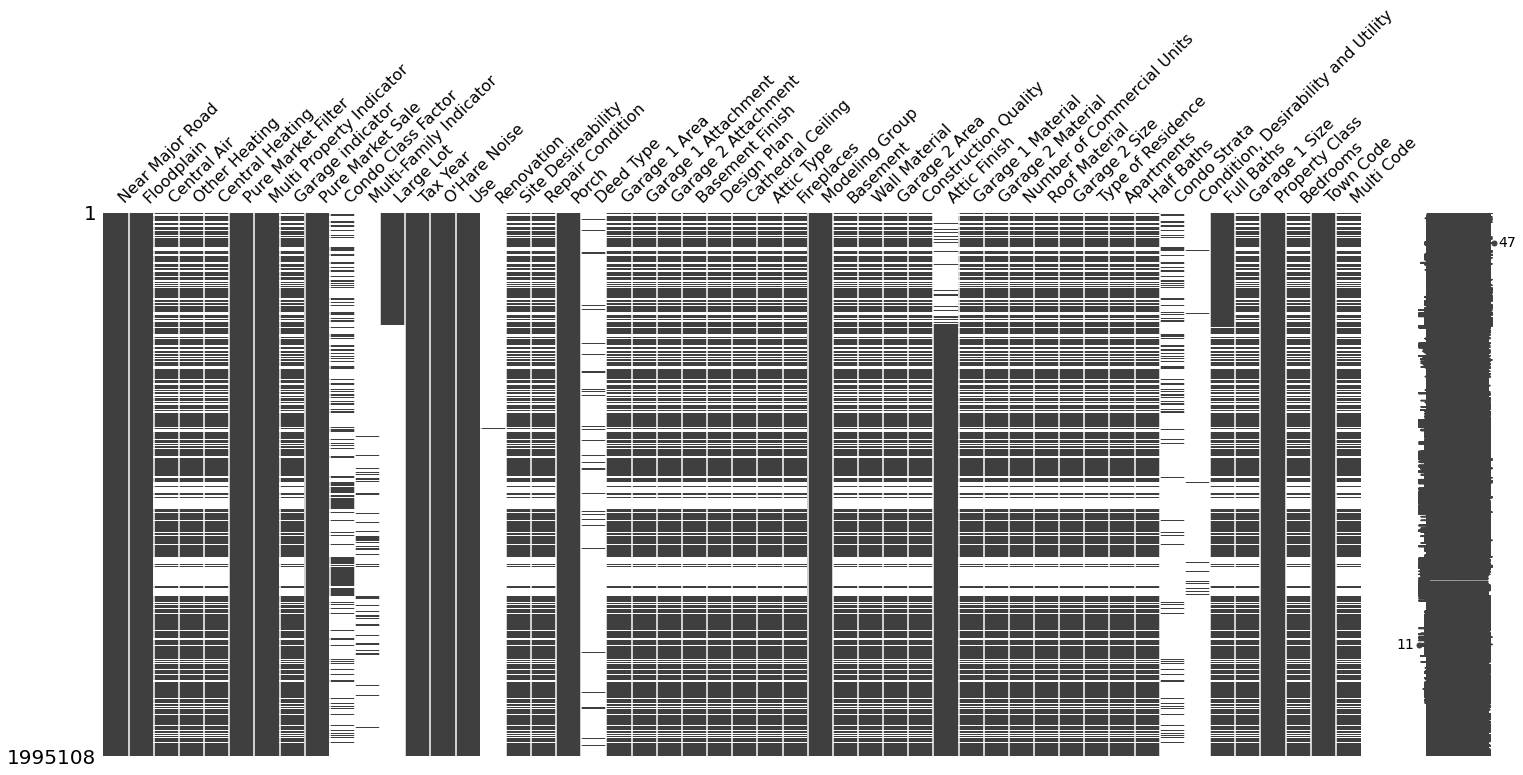

In [11]:
i = 0
msno.matrix(cc_res_prop_char_df[col_deets_df["feature"][i : i + 50]])

Hmm. This plot shows missingness in a DataFrame. The top is the first row in the DataFrame, the bottom is the last row, and there will be black for rows that are NOT null for a given column (and white for rows where the value in that column IS null). Based on those horizontal white lines across multiple columns, it looks like a lot of missingness is correlated.

In [12]:
col_deets_nullsorted = col_deets_df.copy()
col_deets_nullsorted = col_deets_nullsorted.sort_values(by="pct_null", ascending=False)
col_deets_nullsorted = col_deets_nullsorted.reset_index(drop=True)

<AxesSubplot:>

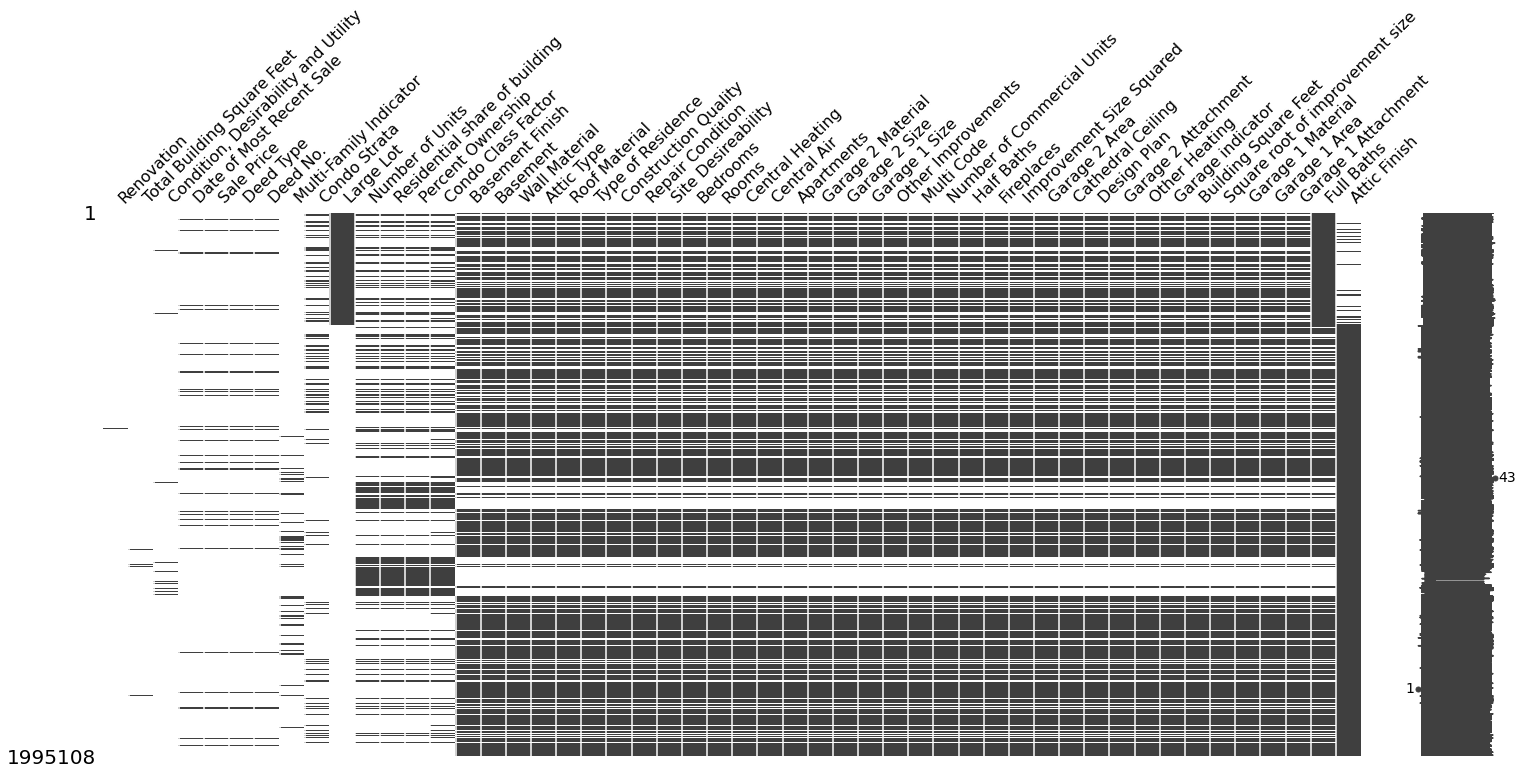

In [13]:
i = 0
msno.matrix(cc_res_prop_char_df[col_deets_nullsorted["feature"][i : i + 50]])

In this plot, I've sorted the `col_deets_df` (column details) so the most frequently null columns are at the front (the `missingno` plots become pretty unreadable with more than 50 columns). It looks like there are some highly missing columns.

In [14]:
col_deets_nullsorted.head(10)

,feature,unique_vals,pct_unique,null_vals,pct_null
0,Renovation,2,0.0001,1992944,99.8915
1,Total Building Square Feet,3951,0.1980,1977874,99.1362
2,"Condition, Desirability and Utility",13,0.0007,1934899,96.9822
3,Date of Most Recent Sale,662,0.0332,1882731,94.3674
4,Sale Price,7395,0.3707,1882731,94.3674
5,Deed Type,3,0.0002,1882731,94.3674
6,Deed No.,111848,5.6061,1882731,94.3674
7,Multi-Family Indicator,2,0.0001,1815842,91.0147
8,Condo Strata,10,0.0005,1675950,84.0030
9,Large Lot,2,0.0001,1583785,79.3834


In [15]:
cc_res_prop_char_df["Renovation"].value_counts(dropna=False)

NaN    1992944
1         2041
2          123
Name: Renovation, dtype: Int64

Per the [data documentation](https://datacatalog.cookcountyil.gov/Property-Taxation/Cook-County-Assessor-s-Residential-Property-Charac/bcnq-qi2z), the `Renovation` feature describes construction renovation and that a `1` value means "yes" and `2` means "no". I'll probably end up dropping this feature as it is so sparse, but I'll make that decision later.

In [20]:
def clean_cc_residential_prop_chars_renovation_col(df: pd.DataFrame) -> pd.DataFrame:
    if "yes" not in df["Renovation"].unique():
        renovation_map = {
            1: "yes",
            2: "no"
        }
        df["Renovation"] = df["Renovation"].map(renovation_map)
    df["Renovation"] = df["Renovation"].astype("category")
    return df

In [21]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_renovation_col(cc_res_prop_char_df)

In [22]:
(cc_res_prop_char_df["Renovation"] == 1).sum()

0

In [23]:
cc_res_prop_char_df["Renovation"].value_counts(dropna=False)

NaN    1992944
yes       2041
no         123
Name: Renovation, dtype: int64

<AxesSubplot:>

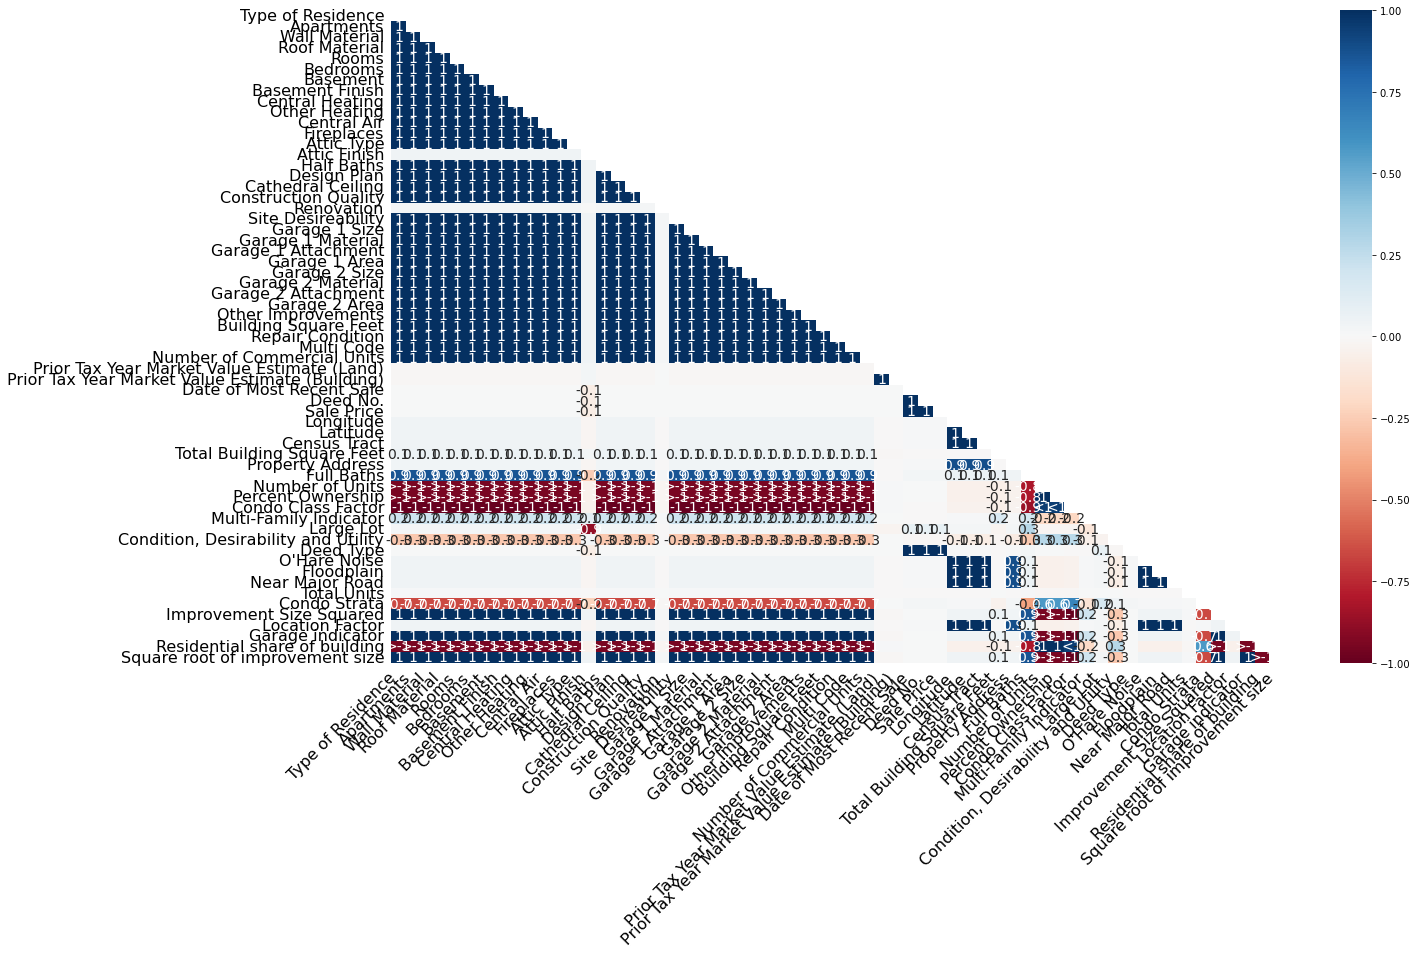

In [30]:
msno.heatmap(cc_res_prop_char_df)

In [50]:
col = "Condition, Desirability and Utility"
plot_df = cc_res_prop_char_df

plot_df = plot_df.copy()
plot_df = plot_df.sort_values(by=col)
plot_df = plot_df.reset_index(drop=True)

In [51]:
plot_notnull_df = plot_df.loc[plot_df[col].notnull()].copy()
plot_deets_df = utils.get_df_column_details(plot_notnull_df)
plot_deets_df = plot_deets_df.sort_values(by="pct_null", ascending=True)
plot_deets_df = plot_deets_df.reset_index(drop=True)

In [52]:
view_cols = [col]
other_cols = list(plot_deets_df["feature"][i : i + 49])
other_cols = [c for c in other_cols if c != col] 
view_cols.extend(other_cols)

<AxesSubplot:>

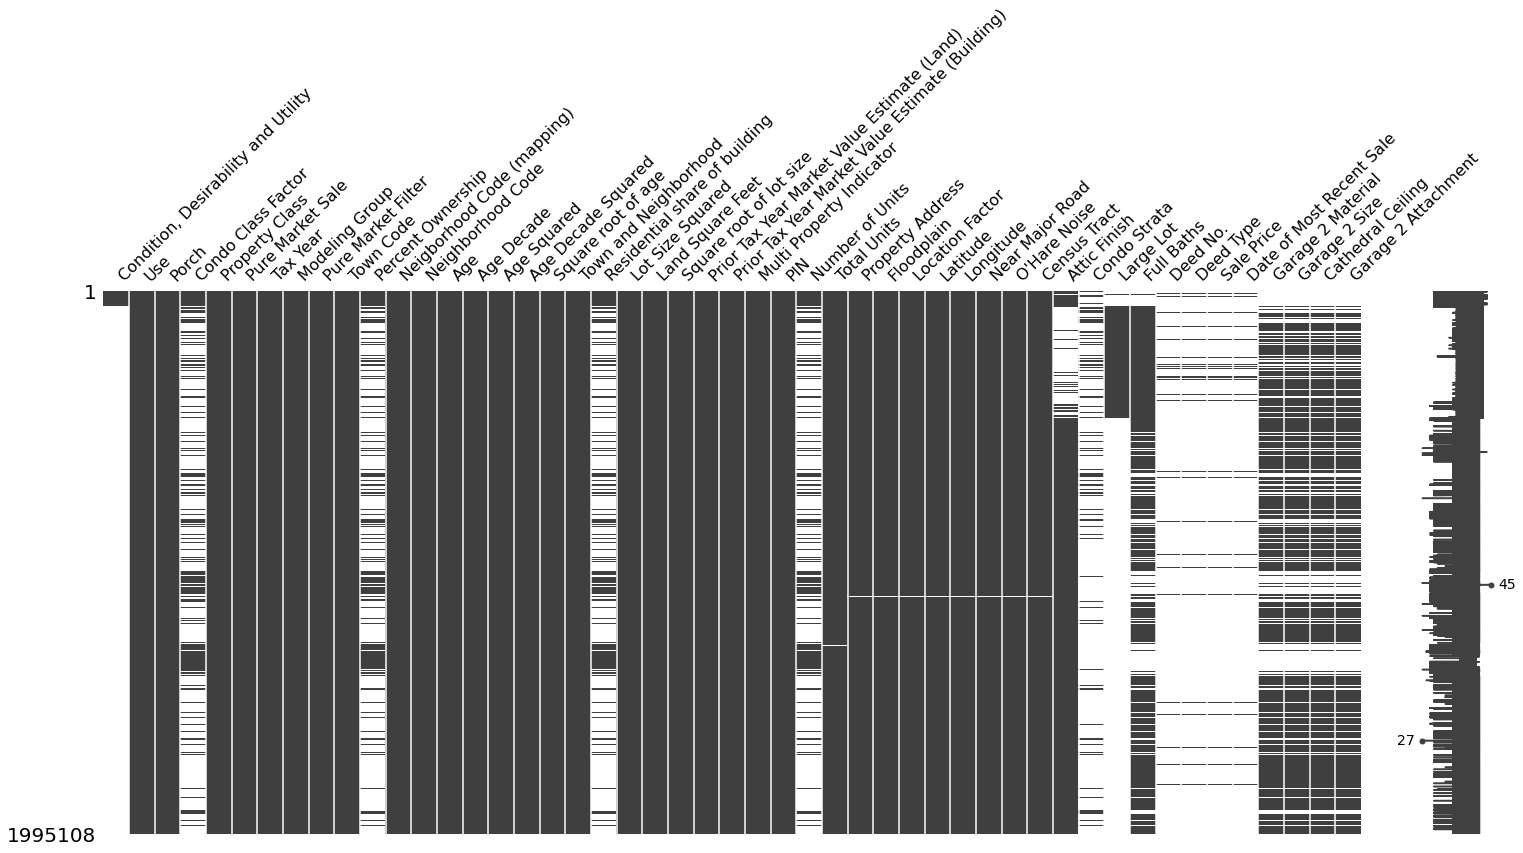

In [53]:
i = 0
msno.matrix(plot_df[view_cols])

In [49]:
cc_res_prop_char_df.loc[cc_res_prop_char_df["Percent Ownership"].notnull()]

,PIN,Property Class,Tax Year,Neighborhood Code,Land Square Feet,Town Code,Type of Residence,Apartments,Wall Material,Roof Material,Rooms,Bedrooms,Basement,Basement Finish,Central Heating,Other Heating,Central Air,Fireplaces,Attic Type,Attic Finish,Half Baths,Design Plan,Cathedral Ceiling,Construction Quality,Renovation,Site Desireability,Garage 1 Size,Garage 1 Material,Garage 1 Attachment,Garage 1 Area,Garage 2 Size,Garage 2 Material,Garage 2 Attachment,Garage 2 Area,Porch,Other Improvements,Building Square Feet,Repair Condition,Multi Code,Number of Commercial Units,Prior Tax Year Market Value Estimate (Land),Prior Tax Year Market Value Estimate (Building),Date of Most Recent Sale,Deed No.,Sale Price,Longitude,Latitude,Census Tract,Total Building Square Feet,Multi Property Indicator,Property Address,Modeling Group,Full Baths,Age,Use,Number of Units,Percent Ownership,Condo Class Factor,Multi-Family Indicator,Large Lot,"Condition, Desirability and Utility",Deed Type,O'Hare Noise,Floodplain,Near Major Road,Total Units,Condo Strata,Age Squared,Age Decade,Age Decade Squared,Lot Size Squared,Improvement Size Squared,Location Factor,Garage indicator,Residential share of building,Pure Market Sale,Pure Market Filter,Neigborhood Code (mapping),Square root of lot size,Square root of age,Square root of improvement size,Town and Neighborhood
46,1011010301025,299,2018,12,23248,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,230.0,26070.0,None,NaN,NaN,-88.135343,42.153567,804202.0,NaN,0,100 E STATION ST BARRINGTON,NCHARS,1.0,10,1,48.0,0.01,299.0,NaN,0.0,None,None,0.0,0.0,1.0,85.0,NaN,100,1.0,1.00,540469504,NaN,1.996230,NaN,0.280806,0,0,12,152.472948,3.162278,NaN,1012
47,1011010301035,299,2018,12,23248,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,230.0,26070.0,None,NaN,NaN,-88.135343,42.153567,804202.0,NaN,0,100 E STATION ST BARRINGTON,NCHARS,1.0,10,1,48.0,0.01,299.0,NaN,0.0,None,None,0.0,0.0,1.0,85.0,NaN,100,1.0,1.00,540469504,NaN,1.996230,NaN,0.280806,0,0,12,152.472948,3.162278,NaN,1012
48,1011010301084,299,2018,12,23248,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,2370.0,258060.0,None,NaN,NaN,-88.135343,42.153567,804202.0,NaN,0,100 E STATION ST BARRINGTON,NCHARS,1.0,10,1,48.0,0.08,299.0,NaN,0.0,None,None,0.0,0.0,1.0,85.0,NaN,100,1.0,1.00,540469504,NaN,1.996230,NaN,0.280806,0,0,12,152.472948,3.162278,NaN,1012
49,1011010301042,299,2018,12,23248,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,230.0,26070.0,None,NaN,NaN,-88.135343,42.153567,804202.0,NaN,0,100 E STATION ST BARRINGTON,NCHARS,1.0,10,1,48.0,0.01,299.0,NaN,0.0,None,None,0.0,0.0,1.0,85.0,NaN,100,1.0,1.00,540469504,NaN,1.996230,NaN,0.280806,0,0,12,152.472948,3.162278,NaN,1012
50,1011010301054,299,2018,12,23248,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,230.0,26070.0,None,NaN,NaN,-88.135343,42.153567,804202.0,NaN,0,100 E STATION ST BARRINGTON,NCHARS,1.0,10,1,48.0,0.01,299.0,NaN,0.0,None,None,0.0,0.0,1.0,85.0,NaN,100,1.0,1.00,540469504,NaN,1.996230,NaN,0.280806,0,0,12,152.472948,3.162278,NaN,1012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993598,33073170061007,299,2019,72,37204,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,9540.0,34820.0,None,NaN,NaN,-87.552666,41.

Ok, it looks like `Condition, Desirability and Utility` may be a condo-related feature, along with `Condo Class Factor`, `Percent Ownership`, `Number of Units`, and `Residential share of building`.

In [50]:
col = "Number of Units"
plot_df = cc_res_prop_char_df
i = 0

plot_df = plot_df.copy()
plot_df = plot_df.sort_values(by=col)
plot_df = plot_df.reset_index(drop=True)

plot_notnull_df = plot_df.loc[plot_df[col].notnull()].copy()
plot_deets_df = utils.get_df_column_details(plot_notnull_df)
plot_deets_df = plot_deets_df.sort_values(by="pct_null", ascending=True)
plot_deets_df = plot_deets_df.reset_index(drop=True)

view_cols = [col]
other_cols = list(plot_deets_df["feature"][i : i + 49])
other_cols = [c for c in other_cols if c != col] 
view_cols.extend(other_cols)

msno.matrix(plot_df[view_cols])

In [24]:
def plot_highly_missingness_correlated_cols(
    col: str, plot_df: pd.DataFrame, i:int = 0, positive_corr: bool=True
) -> None:
    plot_df = plot_df.copy()
    plot_df = plot_df.sort_values(by=col)
    plot_df = plot_df.reset_index(drop=True)
    
    plot_notnull_df = plot_df.loc[plot_df[col].notnull()].copy()
    plot_deets_df = utils.get_df_column_details(plot_notnull_df)
    plot_deets_df = plot_deets_df.sort_values(by="pct_null", ascending=positive_corr)
    plot_deets_df = plot_deets_df.reset_index(drop=True)
    
    view_cols = [col]
    other_cols = list(plot_deets_df["feature"][i : i + 49])
    other_cols = [c for c in other_cols if c != col] 
    view_cols.extend(other_cols)
    
    msno.matrix(plot_df[view_cols])

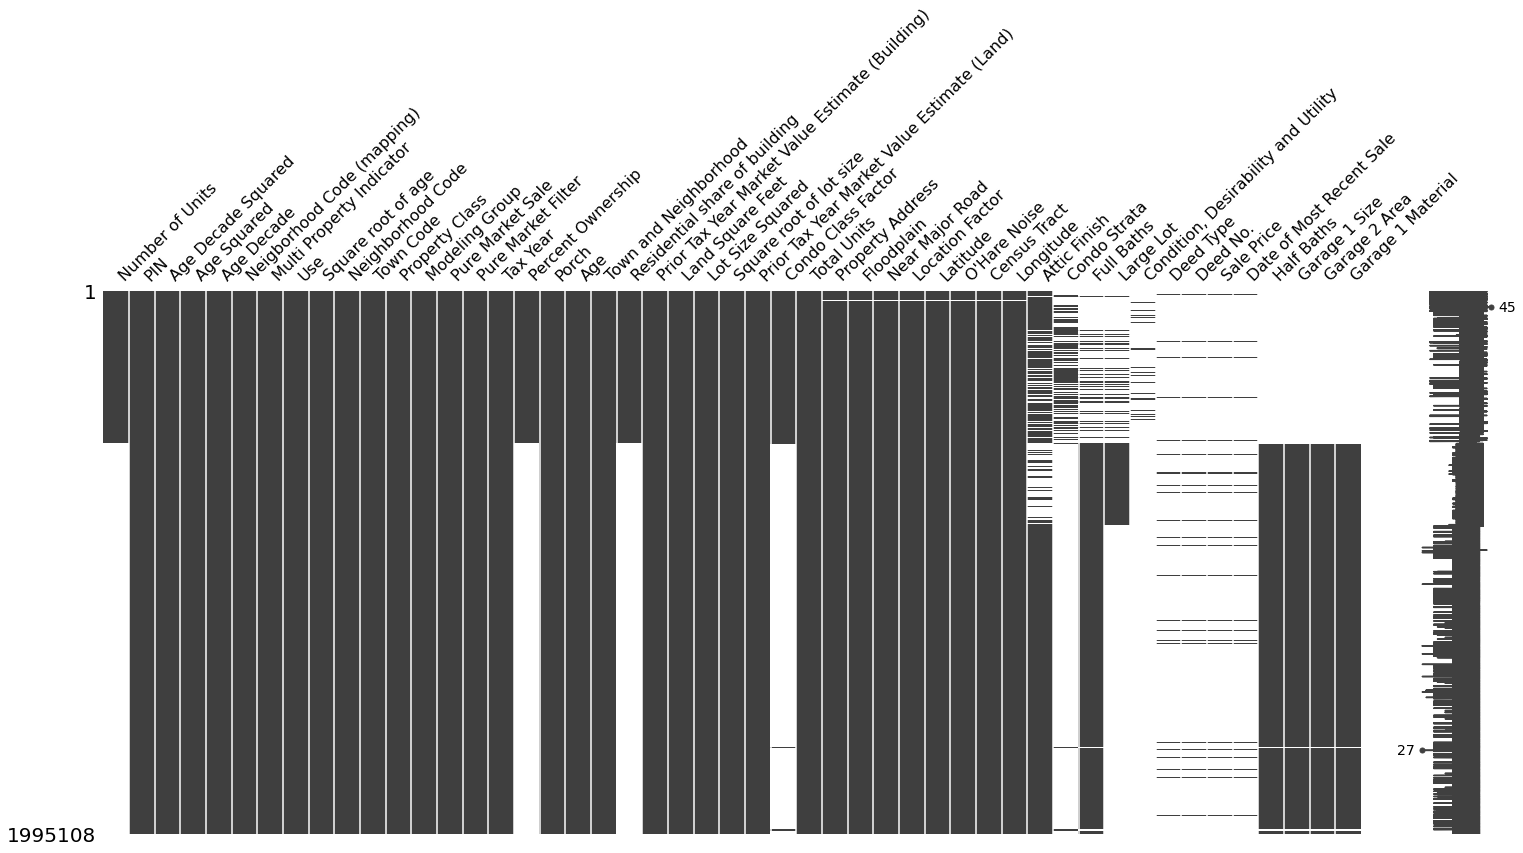

In [25]:
plot_highly_missingness_correlated_cols(
    col="Number of Units", plot_df=cc_res_prop_char_df, i=0
)

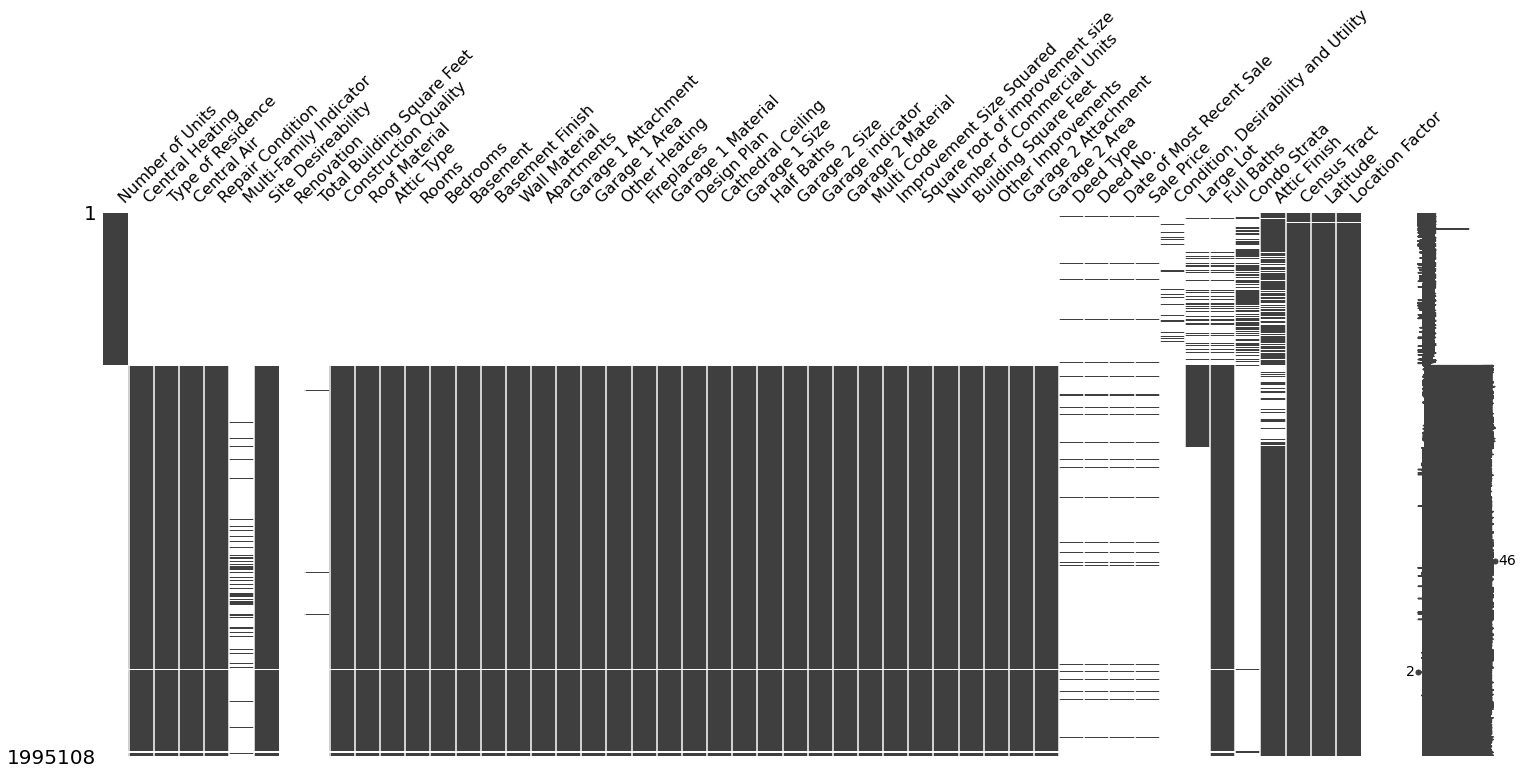

In [26]:
plot_highly_missingness_correlated_cols(
    col="Number of Units", plot_df=cc_res_prop_char_df, i=0, positive_corr=False
)

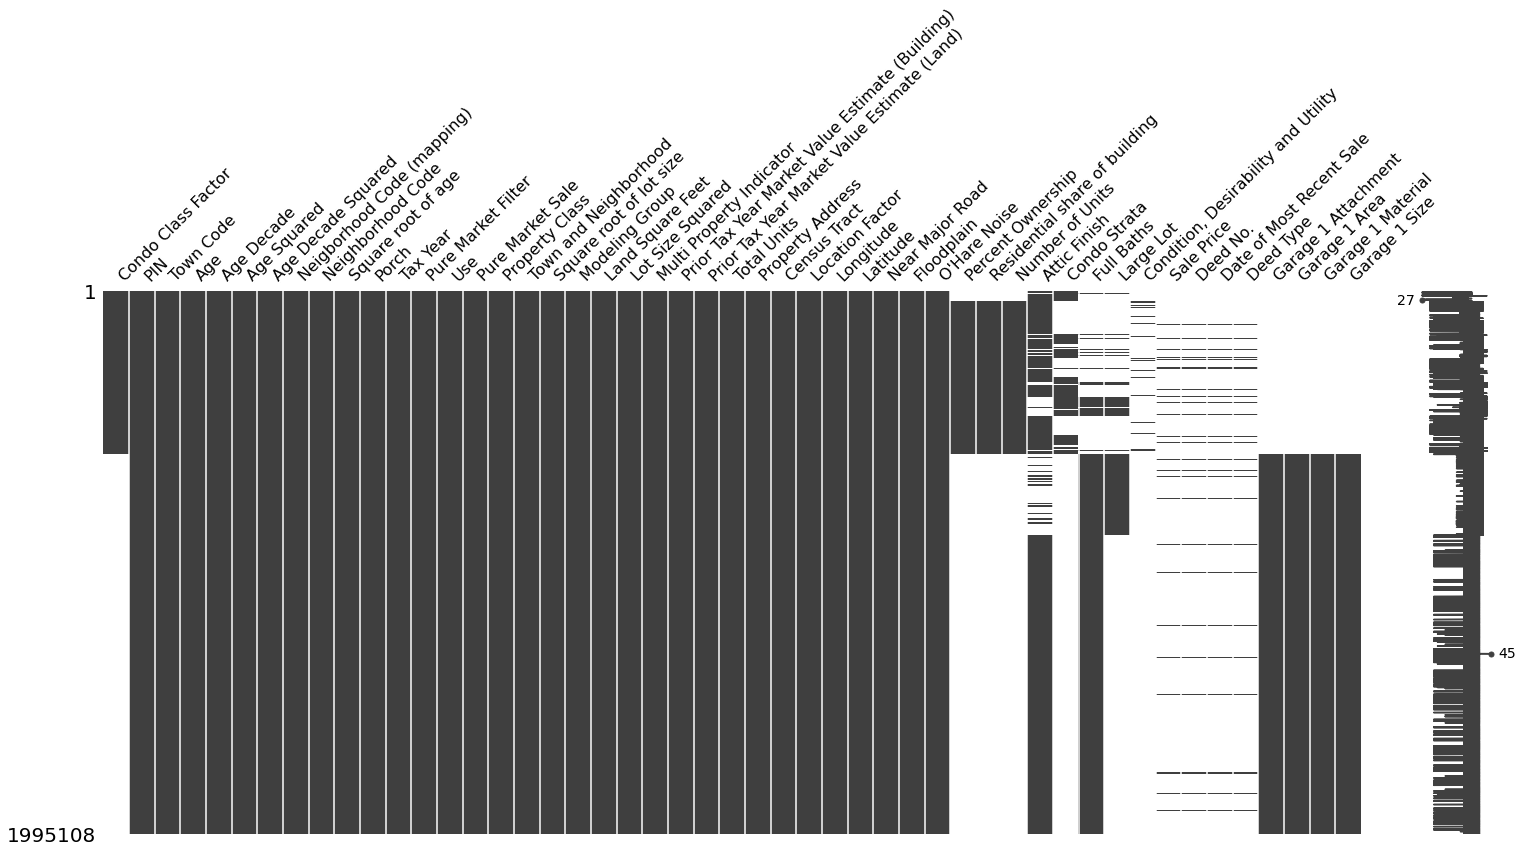

In [27]:
plot_highly_missingness_correlated_cols(
    col="Condo Class Factor", plot_df=cc_res_prop_char_df, i=0
)

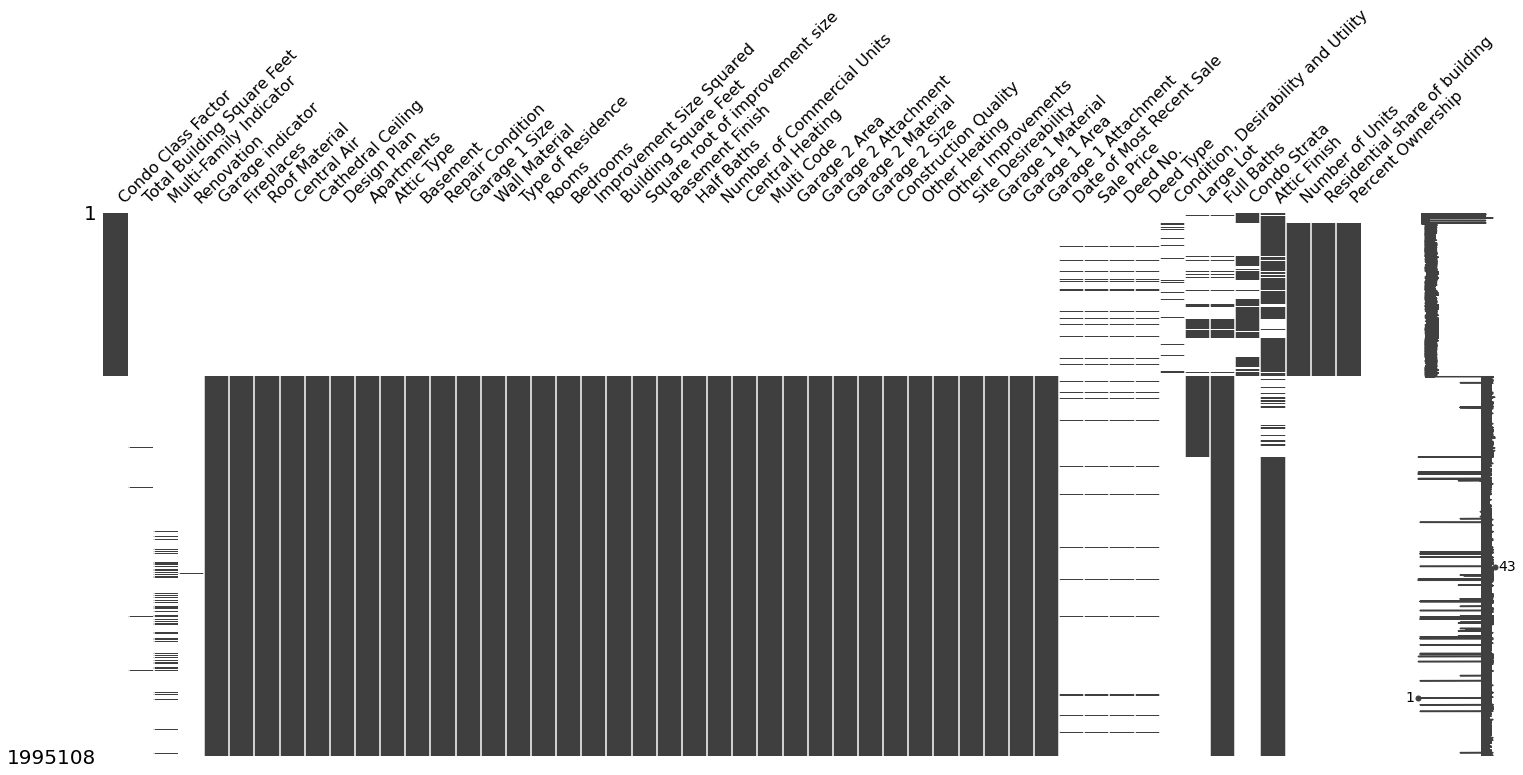

In [28]:
plot_highly_missingness_correlated_cols(
    col="Condo Class Factor", plot_df=cc_res_prop_char_df, i=0, positive_corr=False
)

Ok, it looks like `Condition, Desirability and Utility` may be a condo-related feature, along with `Condo Class Factor`, `Percent Ownership`, `Number of Units`, and `Residential share of building`.

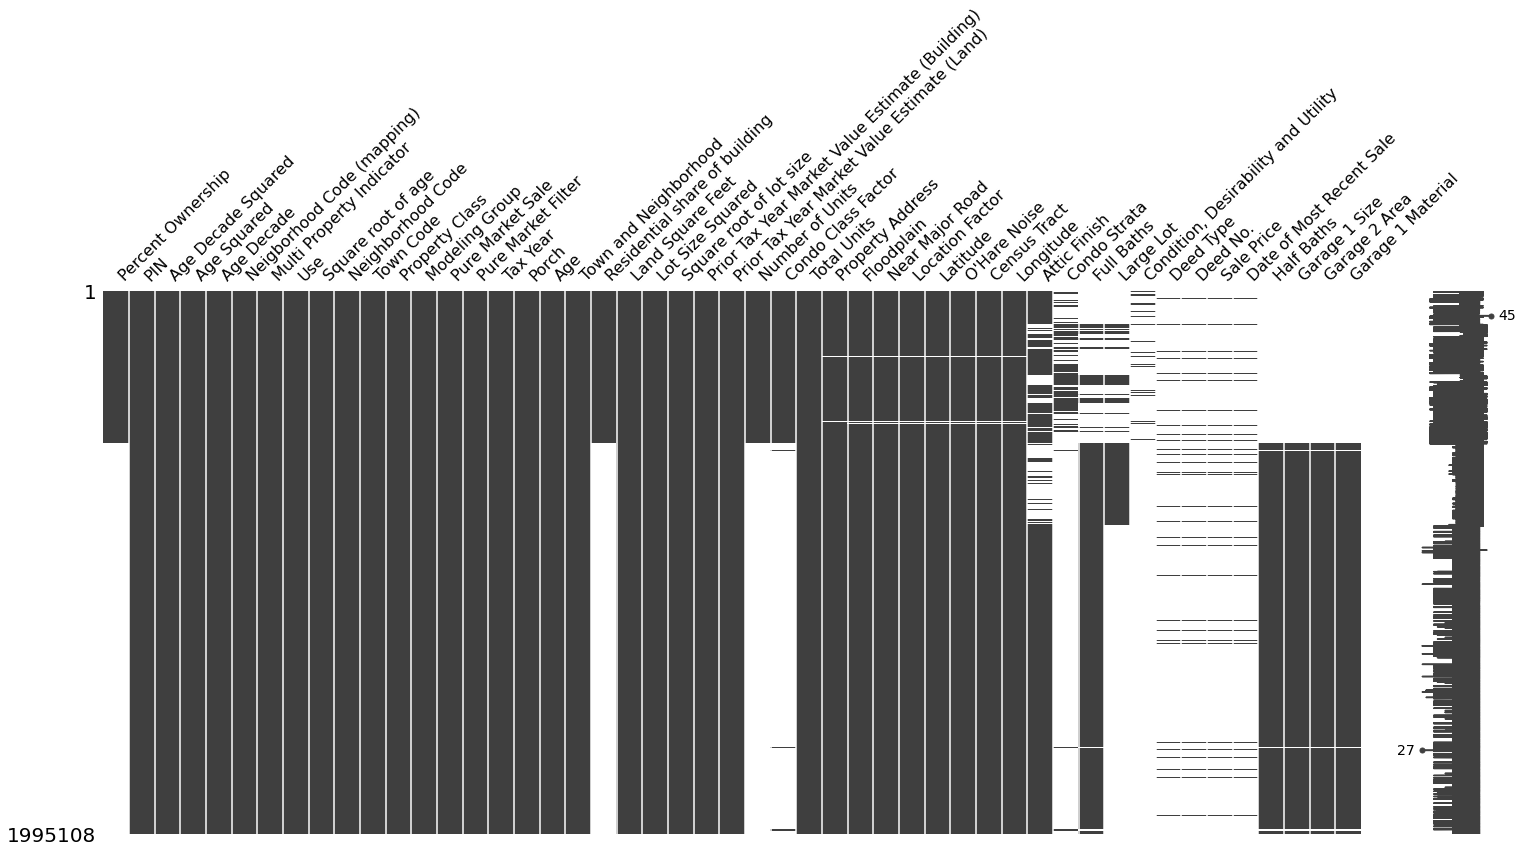

In [29]:
plot_highly_missingness_correlated_cols(
    col="Percent Ownership", plot_df=cc_res_prop_char_df, i=0
)

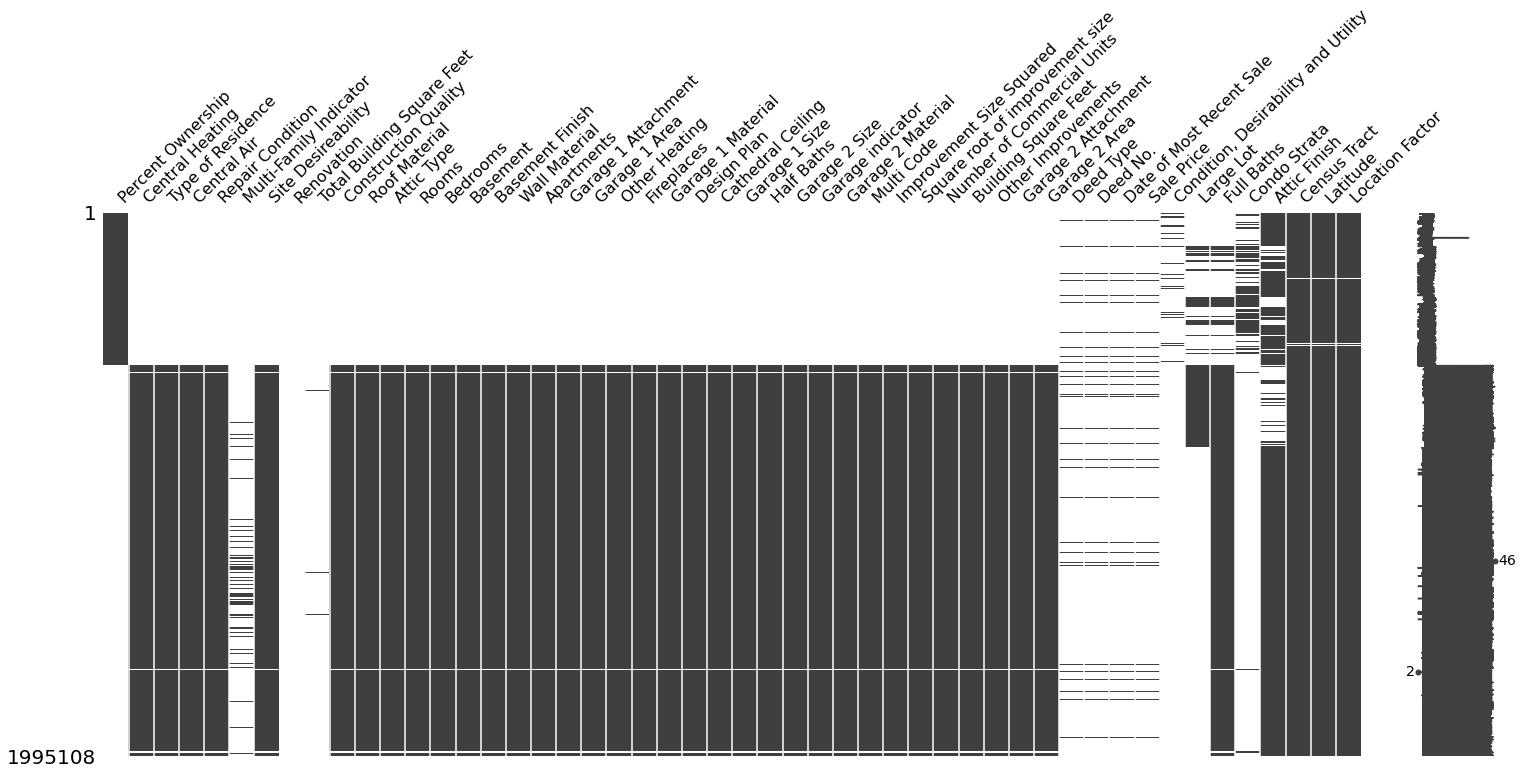

In [30]:
plot_highly_missingness_correlated_cols(
    col="Percent Ownership", plot_df=cc_res_prop_char_df, i=0, positive_corr=False
)

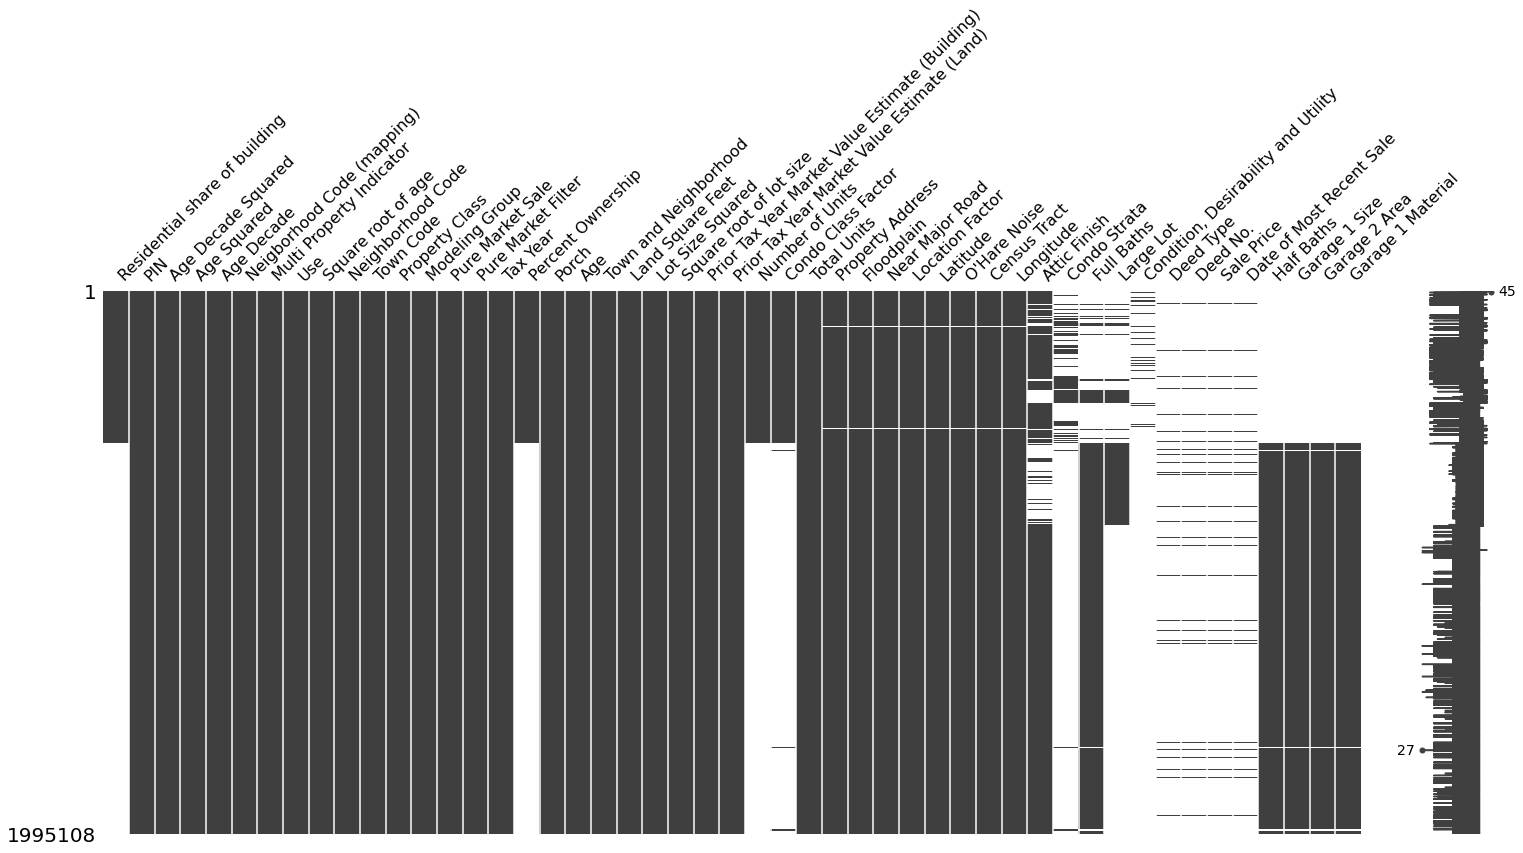

In [31]:
plot_highly_missingness_correlated_cols(
    col="Residential share of building", plot_df=cc_res_prop_char_df, i=0
)

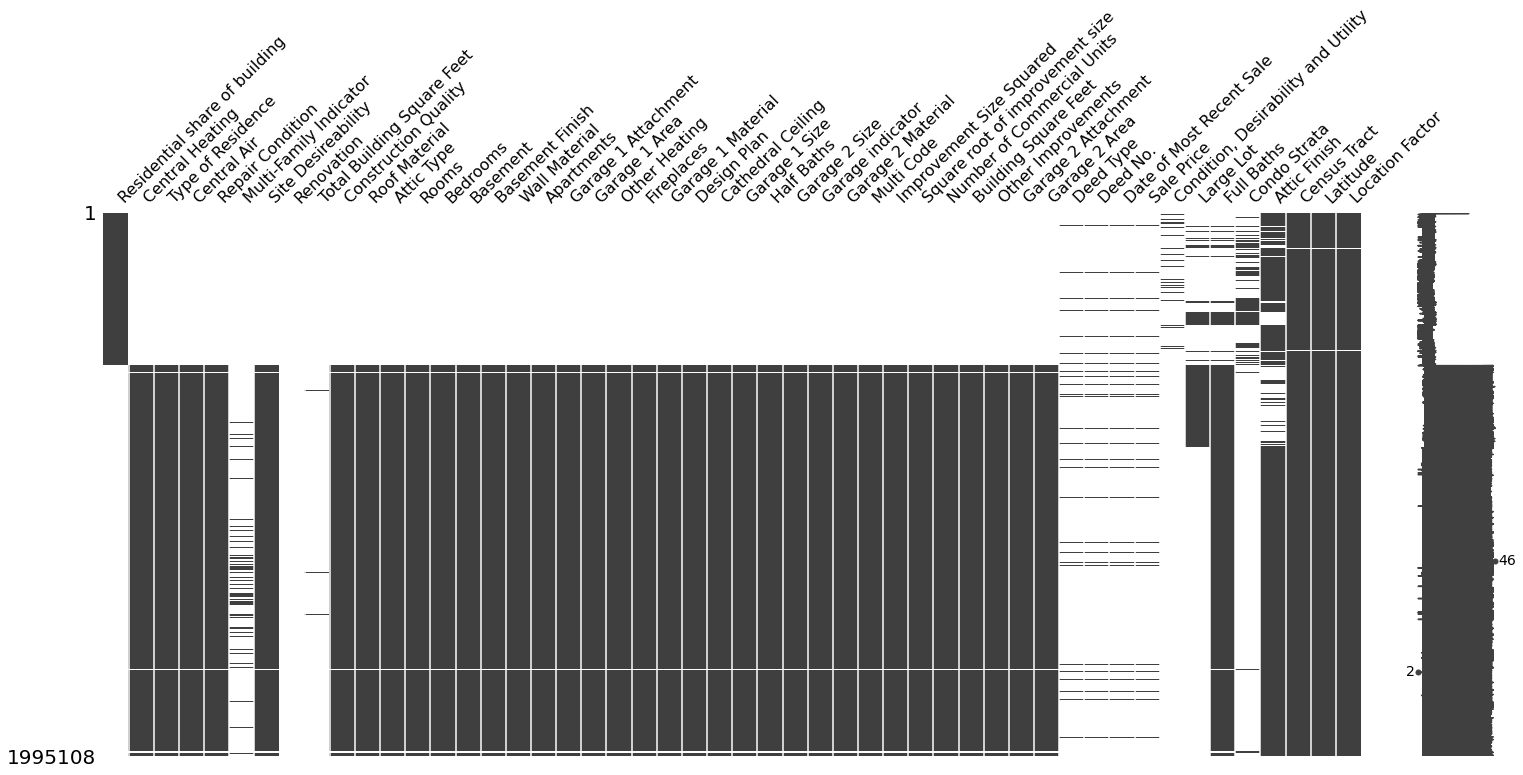

In [32]:
plot_highly_missingness_correlated_cols(
    col="Residential share of building", plot_df=cc_res_prop_char_df, i=0, positive_corr=False
)

### Percent Ownership
Per the documentation:
"Percent of ownership of a condo building for a unit as defined by the condominium declaration. If missing, default is 1/n_units."

In [34]:
cc_res_prop_char_df["Percent Ownership"].value_counts(dropna=False)

NaN     1433884
0.0      219639
0.01     135264
0.02      51400
0.03      26819
         ...   
0.72          1
0.71          1
0.69          1
0.68          1
0.75          1
Name: Percent Ownership, Length: 78, dtype: Int64

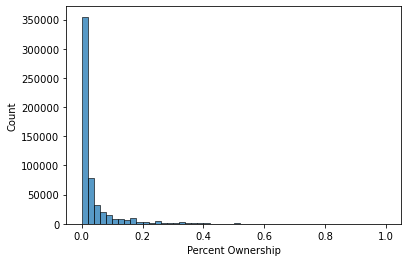

In [35]:
ax = sns.histplot(data=cc_res_prop_char_df, x="Percent Ownership", bins=50)

In [33]:
cc_res_prop_char_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1995108 entries, 0 to 1995107
Data columns (total 82 columns):
 #   Column                                           Dtype   
---  ------                                           -----   
 0   PIN                                              Int64   
 1   Property Class                                   Int64   
 2   Tax Year                                         Int64   
 3   Neighborhood Code                                Int64   
 4   Land Square Feet                                 Int64   
 5   Town Code                                        Int64   
 6   Type of Residence                                Int64   
 7   Apartments                                       Int64   
 8   Wall Material                                    Int64   
 9   Roof Material                                    Int64   
 10  Rooms                                            Int64   
 11  Bedrooms                                         Int64   
 12  

### Residential share of building

Per the documentation: "A sum of "percent of ownership" that only includes residential units within a condo building."

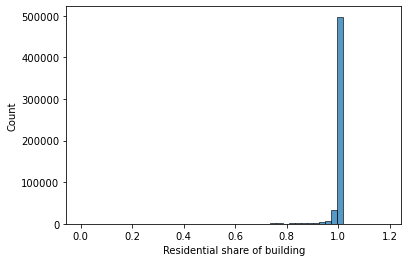

In [36]:
ax = sns.histplot(data=cc_res_prop_char_df, x="Residential share of building", bins=50)

### Number of Units

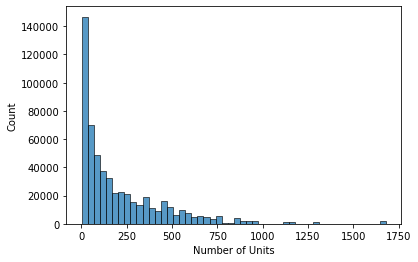

In [37]:
ax = sns.histplot(data=cc_res_prop_char_df, x="Number of Units", bins=50)

### Condo Class Factor

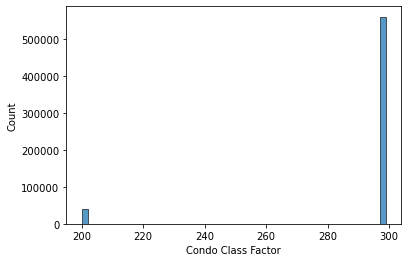

In [38]:
ax = sns.histplot(data=cc_res_prop_char_df, x="Condo Class Factor", bins=50)

In [39]:
cc_res_prop_char_df["Condo Class Factor"].value_counts(dropna=False)

NaN    1393121
299     561198
200      40789
Name: Condo Class Factor, dtype: Int64

In [46]:
(cc_res_prop_char_df["Condo Class Factor"] == 299).sum()

561198

In [52]:
def clean_cc_residential_prop_chars_condo_class_factor_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    if "residential condo" not in df["Condo Class Factor"].unique():
        condo_class_factor_map = {
            200: "residential land", 
            299: "residential condo"
        }
        df["Condo Class Factor"] = df["Condo Class Factor"].map(condo_class_factor_map)
    df["Condo Class Factor"] = df["Condo Class Factor"].astype("category")
    return df


In [53]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_condo_class_factor_col(cc_res_prop_char_df)

In [54]:
cc_res_prop_char_df["Condo Class Factor"].value_counts(dropna=False)

NaN                  1393121
residential condo     561198
residential land       40789
Name: Condo Class Factor, dtype: int64

In [51]:
cc_res_prop_char_df["Condo Class Factor"].map({
            200: "residential land", 
            299: "residential condo"
        }).value_counts(dropna=False)

NaN                  1393121
residential condo     561198
residential land       40789
Name: Condo Class Factor, dtype: int64

In [55]:
col_deets_df.head()

,feature,unique_vals,pct_unique,null_vals,pct_null
0,Near Major Road,2,0.0001,4023,0.2016
1,Floodplain,2,0.0001,4023,0.2016
2,Central Air,2,0.0001,602055,30.1766
3,Other Heating,2,0.0001,602017,30.1747
4,Central Heating,2,0.0001,602055,30.1766


In [56]:
col_deets_notnull_sort = col_deets_df.sort_values(by=["pct_null"], ascending=[True])

In [58]:
col_deets_notnull_sort.head(30)

,feature,unique_vals,pct_unique,null_vals,pct_null
81,PIN,1576252,79.0058,0,0.0000
46,Property Class,18,0.0009,0,0.0000
48,Town Code,38,0.0019,0,0.0000
52,Age,188,0.0094,0,0.0000
53,Age Squared,188,0.0094,0,0.0000
54,Age Decade,188,0.0094,0,0.0000
55,Neighborhood Code,199,0.0100,0,0.0000
56,Neigborhood Code (mapping),199,0.0100,0,0.0000
57,Age Decade Squared,226,0.0113,0,0.0000
18,Porch,3,0.0002,0,0.0000


In [59]:
cc_res_prop_char_df.head(2)

,PIN,Property Class,Tax Year,Neighborhood Code,Land Square Feet,Town Code,Type of Residence,Apartments,Wall Material,Roof Material,Rooms,Bedrooms,Basement,Basement Finish,Central Heating,Other Heating,Central Air,Fireplaces,Attic Type,Attic Finish,Half Baths,Design Plan,Cathedral Ceiling,Construction Quality,Renovation,Site Desireability,Garage 1 Size,Garage 1 Material,Garage 1 Attachment,Garage 1 Area,Garage 2 Size,Garage 2 Material,Garage 2 Attachment,Garage 2 Area,Porch,Other Improvements,Building Square Feet,Repair Condition,Multi Code,Number of Commercial Units,Prior Tax Year Market Value Estimate (Land),Prior Tax Year Market Value Estimate (Building),Date of Most Recent Sale,Deed No.,Sale Price,Longitude,Latitude,Census Tract,Total Building Square Feet,Multi Property Indicator,Property Address,Modeling Group,Full Baths,Age,Use,Number of Units,Percent Ownership,Condo Class Factor,Multi-Family Indicator,Large Lot,"Condition, Desirability and Utility",Deed Type,O'Hare Noise,Floodplain,Near Major Road,Total Units,Condo Strata,Age Squared,Age Decade,Age Decade Squared,Lot Size Squared,Improvement Size Squared,Location Factor,Garage indicator,Residential share of building,Pure Market Sale,Pure Market Filter,Neigborhood Code (mapping),Square root of lot size,Square root of age,Square root of improvement size,Town and Neighborhood
0,1011000040000,212,2018,12,11055,10,2,5,1,2,7,5,3,3,1,5,0,0,1,3,1,2,2,2,NaN,2,2,1,2,2,7,0,0,0,3,200,1904,2,2,1,52510,374930,<NA>,<NA>,<NA>,-88.139621,42.153953,804201,<NA>,0,213 W MAIN ST BARRINGTON,MF,5,135,2,<NA>,<NA>,NaN,212,0,<NA>,<NA>,0,0,1,1,<NA>,18225,13.5,182.25,122213025,3625216,2.084499,1,<NA>,0,0,12,105.14276,11.61895,43.634848,1012
1,1011000050000,205,2018,12,6534,10,2,0,1,1,7,4,1,3,2,5,0,1,1,3,0,2,2,2,NaN,2,3,1,2,2,7,0,0,0,1,0,1562,2,2,0,31030,173970,<NA>,<NA>,<NA>,-88.139379,42.153953,804201,<NA>,0,209 W MAIN ST BARRINGTON,SF,1,114,1,<NA>,<NA>,NaN,<NA>,0,<NA>,<NA>,0,0,1,1,<NA>,12996,11.4,129.96,42693156,2439844,2.079861,1,<NA>,0,0,12,80.833162,10.677078,39.522146,1012


In [ ]:
cc_res_prop_char_df["Property Class"].value_counts(dropna=False)

299    561198
203    436194
211    164337
278    139913
202    131413
234    130692
205     87806
295     85629
204     71949
206     47601
207     40589
241     31431
208     17913
212     14929
210     14124
209     10032
201      9258
200       100
NaN         0
Name: Property Class, dtype: Int64

In [65]:
temp_vals = list(cc_res_prop_char_df["Property Class"].unique())
temp_vals.sort()
temp_vals

[200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 234,
 241,
 278,
 295,
 299]

In [62]:
df = cc_res_prop_char_df
df = df.copy()

In [ ]:
property_class_map = {
    200: "residential_land",
    201: "residential_garage",
    202: "one_story_residence__any_age__lt_1k_sq_ft",
    203: "one_story_residence__any_age__1k_to_1800_sq_ft",
    204: "one_story_residence__any_age__gt_1800_sq_ft",
    205: "two_plus_story_residence__gt_62_yrs_old__lt_2200_sq_ft",
    206: "two_plus_story_residence__gt_62_yrs_old__2201_to_4999_sq_ft",
    207: "two_plus_story_residence__lte_62_yrs_old__lte_2000_sq_ft",
    278: "two_plus_story_residence__lte_62_yrs_old__2001_to_3800_sq_ft",
    208: "two_plus_story_residence__lte_62_yrs_old__3801_to_4999_sq_ft",
    209: "two_plus_story_residence__any_age__gte_5000_sq_ft",
    210: "old_style_row_house__gt_62_yrs_old",
    211: "appartment_bldg_w_2_to_6_units__any_age",
    212: "mixed_use_bldg_w_lte_6_units__any_age__gte_20k_sq_ft",
    234: "split_level_residence_w_a_level_below_ground__any_age__any_sq_ft",
    241: "vacant_land_under_common_ownership_adjacent_to_residence",
    295: "individually_owned_townhowm_or_row_house__lte_62_years_old",
    299: "residential_condominium",    
}

In [71]:
def clean_cc_residential_prop_chars_property_class_col(
    df: pd.DataFrame,
) -> pd.DataFrame:
    property_class_map = {
        200: "residential_land",
        201: "residential_garage",
        202: "one_story_residence__any_age__lt_1k_sq_ft",
        203: "one_story_residence__any_age__1k_to_1800_sq_ft",
        204: "one_story_residence__any_age__gt_1800_sq_ft",
        205: "two_plus_story_residence__gt_62_yrs_old__lt_2200_sq_ft",
        206: "two_plus_story_residence__gt_62_yrs_old__2201_to_4999_sq_ft",
        207: "two_plus_story_residence__lte_62_yrs_old__lte_2000_sq_ft",
        278: "two_plus_story_residence__lte_62_yrs_old__2001_to_3800_sq_ft",
        208: "two_plus_story_residence__lte_62_yrs_old__3801_to_4999_sq_ft",
        209: "two_plus_story_residence__any_age__gte_5000_sq_ft",
        210: "old_style_row_house__gt_62_yrs_old",
        211: "appartment_bldg_w_2_to_6_units__any_age",
        212: "mixed_use_bldg_w_lte_6_units__any_age__gte_20k_sq_ft",
        234: "split_level_residence_w_a_level_below_ground__any_age__any_sq_ft",
        241: "vacant_land_under_common_ownership_adjacent_to_residence",
        295: "individually_owned_townhowm_or_row_house__lte_62_years_old",
        299: "residential_condominium",    
    }
    if "residential_condominium" not in df["Property Class"].unique():
        df["Property Class"] = df["Property Class"].map(property_class_map)
    df["Property Class"] = df["Property Class"].astype("category")
    return df

In [72]:
cc_res_prop_char_df = clean_cc_residential_prop_chars_property_class_col(cc_res_prop_char_df)

In [73]:
cc_res_prop_char_df["Property Class"].value_counts(dropna=False)

residential_condominium                                             561198
one_story_residence__any_age__1k_to_1800_sq_ft                      436194
appartment_bldg_w_2_to_6_units__any_age                             164337
two_plus_story_residence__lte_62_yrs_old__2001_to_3800_sq_ft        139913
one_story_residence__any_age__lt_1k_sq_ft                           131413
split_level_residence_w_a_level_below_ground__any_age__any_sq_ft    130692
two_plus_story_residence__gt_62_yrs_old__lt_2200_sq_ft               87806
individually_owned_townhowm_or_row_house__lte_62_years_old           85629
one_story_residence__any_age__gt_1800_sq_ft                          71949
two_plus_story_residence__gt_62_yrs_old__2201_to_4999_sq_ft          47601
two_plus_story_residence__lte_62_yrs_old__lte_2000_sq_ft             40589
vacant_land_under_common_ownership_adjacent_to_residence             31431
two_plus_story_residence__lte_62_yrs_old__3801_to_4999_sq_ft         17913
mixed_use_bldg_w_lte_6_un

In [68]:
clean_cc_residential_prop_chars_property_class_col

<function __main__.clean_cc_residential_prop_chars_property_class_col(df: pandas.core.frame.DataFrame) -> pandas.core.frame.DataFrame>

In [74]:
cc_res_prop_char_df.head(2)

,PIN,Property Class,Tax Year,Neighborhood Code,Land Square Feet,Town Code,Type of Residence,Apartments,Wall Material,Roof Material,Rooms,Bedrooms,Basement,Basement Finish,Central Heating,Other Heating,Central Air,Fireplaces,Attic Type,Attic Finish,Half Baths,Design Plan,Cathedral Ceiling,Construction Quality,Renovation,Site Desireability,Garage 1 Size,Garage 1 Material,Garage 1 Attachment,Garage 1 Area,Garage 2 Size,Garage 2 Material,Garage 2 Attachment,Garage 2 Area,Porch,Other Improvements,Building Square Feet,Repair Condition,Multi Code,Number of Commercial Units,Prior Tax Year Market Value Estimate (Land),Prior Tax Year Market Value Estimate (Building),Date of Most Recent Sale,Deed No.,Sale Price,Longitude,Latitude,Census Tract,Total Building Square Feet,Multi Property Indicator,Property Address,Modeling Group,Full Baths,Age,Use,Number of Units,Percent Ownership,Condo Class Factor,Multi-Family Indicator,Large Lot,"Condition, Desirability and Utility",Deed Type,O'Hare Noise,Floodplain,Near Major Road,Total Units,Condo Strata,Age Squared,Age Decade,Age Decade Squared,Lot Size Squared,Improvement Size Squared,Location Factor,Garage indicator,Residential share of building,Pure Market Sale,Pure Market Filter,Neigborhood Code (mapping),Square root of lot size,Square root of age,Square root of improvement size,Town and Neighborhood
0,1011000040000,mixed_use_bldg_w_lte_6_units__any_age__gte_20k...,2018,12,11055,10,2,5,1,2,7,5,3,3,1,5,0,0,1,3,1,2,2,2,<NA>,2,2,1,2,2,7,0,0,0,3,200,1904,2,2,1,52510,374930,<NA>,<NA>,<NA>,-88.139621,42.153953,804201,<NA>,0,213 W MAIN ST BARRINGTON,MF,5,135,2,<NA>,<NA>,<NA>,212,0,<NA>,<NA>,0,0,1,1,<NA>,18225,13.5,182.25,122213025,3625216,2.084499,1,<NA>,0,0,12,105.14276,11.61895,43.634848,1012
1,1011000050000,two_plus_story_residence__gt_62_yrs_old__lt_22...,2018,12,6534,10,2,0,1,1,7,4,1,3,2,5,0,1,1,3,0,2,2,2,<NA>,2,3,1,2,2,7,0,0,0,1,0,1562,2,2,0,31030,173970,<NA>,<NA>,<NA>,-88.139379,42.153953,804201,<NA>,0,209 W MAIN ST BARRINGTON,SF,1,114,1,<NA>,<NA>,<NA>,<NA>,0,<NA>,<NA>,0,0,1,1,<NA>,12996,11.4,129.96,42693156,2439844,2.079861,1,<NA>,0,0,12,80.833162,10.677078,39.522146,1012


In [11]:
col_deets_df.loc[col_deets_df["unique_vals"] <= 50]

,feature,unique_vals,pct_unique,null_vals,pct_null
0,Near Major Road,2,0.0001,4023,0.2016
1,Floodplain,2,0.0001,4023,0.2016
2,Central Air,2,0.0001,602055,30.1766
3,Other Heating,2,0.0001,602017,30.1747
4,Central Heating,2,0.0001,602055,30.1766
5,Pure Market Filter,2,0.0001,0,0.0000
6,Multi Property Indicator,2,0.0001,0,0.0000
7,Garage indicator,2,0.0001,602017,30.1747
8,Pure Market Sale,2,0.0001,0,0.0000
9,Condo Class Factor,2,0.0001,1393121,69.8268


In [23]:
col_deets_df.loc[col_deets_df["pct_null"] >= 95]

,feature,unique_vals,pct_unique,null_vals,pct_null
15,Renovation,2,0.0001,1992944,99.8915
43,"Condition, Desirability and Utility",13,0.0007,1934899,96.9822
66,Total Building Square Feet,3951,0.1980,1977874,99.1362


In [13]:
cc_res_prop_char_df["Property Class"].value_counts(dropna=False)

299    561198
203    436194
211    164337
278    139913
202    131413
234    130692
205     87806
295     85629
204     71949
206     47601
207     40589
241     31431
208     17913
212     14929
210     14124
209     10032
201      9258
200       100
Name: Property Class, dtype: int64

In [12]:
cc_res_prop_char_df["Condo Class Factor"].value_counts(dropna=False)

NaN      1393121
299.0     561198
200.0      40789
Name: Condo Class Factor, dtype: int64

In [32]:
cc_res_prop_char_df = cc_res_prop_char_df.convert_dtypes()

In [33]:
condo_df = cc_res_prop_char_df.loc[
    (cc_res_prop_char_df["Property Class"] == 299)
].copy()
condo_df = condo_df.reset_index(drop=True)
non_condo_df = cc_res_prop_char_df.loc[
    ~(cc_res_prop_char_df["Property Class"] == 299)
].copy()
non_condo_df = non_condo_df.reset_index(drop=True)

In [35]:
cc_res_prop_char_df.head(2)

,PIN,Property Class,Tax Year,Neighborhood Code,Land Square Feet,Town Code,Type of Residence,Apartments,Wall Material,Roof Material,Rooms,Bedrooms,Basement,Basement Finish,Central Heating,Other Heating,Central Air,Fireplaces,Attic Type,Attic Finish,Half Baths,Design Plan,Cathedral Ceiling,Construction Quality,Renovation,Site Desireability,Garage 1 Size,Garage 1 Material,Garage 1 Attachment,Garage 1 Area,Garage 2 Size,Garage 2 Material,Garage 2 Attachment,Garage 2 Area,Porch,Other Improvements,Building Square Feet,Repair Condition,Multi Code,Number of Commercial Units,Prior Tax Year Market Value Estimate (Land),Prior Tax Year Market Value Estimate (Building),Date of Most Recent Sale,Deed No.,Sale Price,Longitude,Latitude,Census Tract,Total Building Square Feet,Multi Property Indicator,Property Address,Modeling Group,Full Baths,Age,Use,Number of Units,Percent Ownership,Condo Class Factor,Multi-Family Indicator,Large Lot,"Condition, Desirability and Utility",Deed Type,O'Hare Noise,Floodplain,Near Major Road,Total Units,Condo Strata,Age Squared,Age Decade,Age Decade Squared,Lot Size Squared,Improvement Size Squared,Location Factor,Garage indicator,Residential share of building,Pure Market Sale,Pure Market Filter,Neigborhood Code (mapping),Square root of lot size,Square root of age,Square root of improvement size,Town and Neighborhood
0,1011000040000,212,2018,12,11055,10,2,5,1,2,7,5,3,3,1,5,0,0,1,3,1,2,2,2,<NA>,2,2,1,2,2,7,0,0,0,3,200,1904,2,2,1,52510,374930,<NA>,<NA>,<NA>,-88.139621,42.153953,804201,<NA>,0,213 W MAIN ST BARRINGTON,MF,5,135,2,<NA>,<NA>,<NA>,212,0,<NA>,<NA>,0,0,1,1,<NA>,18225,13.5,182.25,122213025,3625216,2.084499,1,<NA>,0,0,12,105.14276,11.61895,43.634848,1012
1,1011000050000,205,2018,12,6534,10,2,0,1,1,7,4,1,3,2,5,0,1,1,3,0,2,2,2,<NA>,2,3,1,2,2,7,0,0,0,1,0,1562,2,2,0,31030,173970,<NA>,<NA>,<NA>,-88.139379,42.153953,804201,<NA>,0,209 W MAIN ST BARRINGTON,SF,1,114,1,<NA>,<NA>,<NA>,<NA>,0,<NA>,<NA>,0,0,1,1,<NA>,12996,11.4,129.96,42693156,2439844,2.079861,1,<NA>,0,0,12,80.833162,10.677078,39.522146,1012


In [34]:
condo_df.head(2)

,PIN,Property Class,Tax Year,Neighborhood Code,Land Square Feet,Town Code,Type of Residence,Apartments,Wall Material,Roof Material,Rooms,Bedrooms,Basement,Basement Finish,Central Heating,Other Heating,Central Air,Fireplaces,Attic Type,Attic Finish,Half Baths,Design Plan,Cathedral Ceiling,Construction Quality,Renovation,Site Desireability,Garage 1 Size,Garage 1 Material,Garage 1 Attachment,Garage 1 Area,Garage 2 Size,Garage 2 Material,Garage 2 Attachment,Garage 2 Area,Porch,Other Improvements,Building Square Feet,Repair Condition,Multi Code,Number of Commercial Units,Prior Tax Year Market Value Estimate (Land),Prior Tax Year Market Value Estimate (Building),Date of Most Recent Sale,Deed No.,Sale Price,Longitude,Latitude,Census Tract,Total Building Square Feet,Multi Property Indicator,Property Address,Modeling Group,Full Baths,Age,Use,Number of Units,Percent Ownership,Condo Class Factor,Multi-Family Indicator,Large Lot,"Condition, Desirability and Utility",Deed Type,O'Hare Noise,Floodplain,Near Major Road,Total Units,Condo Strata,Age Squared,Age Decade,Age Decade Squared,Lot Size Squared,Improvement Size Squared,Location Factor,Garage indicator,Residential share of building,Pure Market Sale,Pure Market Filter,Neigborhood Code (mapping),Square root of lot size,Square root of age,Square root of improvement size,Town and Neighborhood
0,1011010301025,299,2018,12,23248,10,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3,<NA>,<NA>,<NA>,<NA>,<NA>,230,26070,<NA>,<NA>,<NA>,-88.135343,42.153567,804202,<NA>,0,100 E STATION ST BARRINGTON,NCHARS,1,10,1,48,0.01,299,<NA>,0,<NA>,<NA>,0,0,1,85,<NA>,100,1.0,1.0,540469504,<NA>,1.99623,<NA>,0.280806,0,0,12,152.472948,3.162278,<NA>,1012
1,1011010301035,299,2018,12,23248,10,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3,<NA>,<NA>,<NA>,<NA>,<NA>,230,26070,<NA>,<NA>,<NA>,-88.135343,42.153567,804202,<NA>,0,100 E STATION ST BARRINGTON,NCHARS,1,10,1,48,0.01,299,<NA>,0,<NA>,<NA>,0,0,1,85,<NA>,100,1.0,1.0,540469504,<NA>,1.99623,<NA>,0.280806,0,0,12,152.472948,3.162278,<NA>,1012


In [17]:
condo_col_deets_df = utils.get_df_column_details(condo_df)

In [19]:
condo_col_deets_df.loc[condo_col_deets_df["pct_null"] >= 95]

,feature,unique_vals,pct_unique,null_vals,pct_null
0,Building Square Feet,0,0.0,561198,100.0
1,Renovation,0,0.0,561198,100.0
2,Site Desireability,0,0.0,561198,100.0
3,Garage 1 Size,0,0.0,561198,100.0
4,Garage 1 Material,0,0.0,561198,100.0
5,Garage 1 Attachment,0,0.0,561198,100.0
6,Garage 1 Area,0,0.0,561198,100.0
7,Garage 2 Size,0,0.0,561198,100.0
8,Garage 2 Material,0,0.0,561198,100.0
9,Construction Quality,0,0.0,561198,100.0


In [51]:
condo_col_deets_df.loc[condo_col_deets_df["pct_null"] >= 95, "feature"].tolist()

['Building Square Feet',
 'Renovation',
 'Site Desireability',
 'Garage 1 Size',
 'Garage 1 Material',
 'Garage 1 Attachment',
 'Garage 1 Area',
 'Garage 2 Size',
 'Garage 2 Material',
 'Construction Quality',
 'Garage 2 Attachment',
 'Other Improvements',
 'Repair Condition',
 'Multi Code',
 'Number of Commercial Units',
 'Square root of improvement size',
 'Total Building Square Feet',
 'Multi-Family Indicator',
 'Improvement Size Squared',
 'Garage 2 Area',
 'Cathedral Ceiling',
 'Garage indicator',
 'Half Baths',
 'Type of Residence',
 'Apartments',
 'Wall Material',
 'Roof Material',
 'Rooms',
 'Bedrooms',
 'Basement',
 'Design Plan',
 'Central Heating',
 'Other Heating',
 'Central Air',
 'Fireplaces',
 'Attic Type',
 'Basement Finish']

In [45]:
temp_check = non_condo_df.loc[(non_condo_df["Property Class"] == 200)].copy()

In [49]:
temp_check.shape

(100, 82)

In [47]:
temp_deets = utils.get_df_column_details(temp_check)

In [48]:
temp_deets.loc[temp_deets["pct_null"] > 95]

,feature,unique_vals,pct_unique,null_vals,pct_null
0,Sale Price,0,0.0,100,100.0
1,Date of Most Recent Sale,0,0.0,100,100.0
2,Deed No.,0,0.0,100,100.0
3,Total Building Square Feet,0,0.0,100,100.0
4,Multi-Family Indicator,0,0.0,100,100.0
5,Renovation,0,0.0,100,100.0
6,Deed Type,0,0.0,100,100.0
7,"Condition, Desirability and Utility",0,0.0,100,100.0
9,Garage 2 Size,1,1.0,98,98.0
10,Garage 2 Material,1,1.0,98,98.0


In [15]:
non_condo_df.head(2)

,PIN,Property Class,Tax Year,Neighborhood Code,Land Square Feet,Town Code,Type of Residence,Apartments,Wall Material,Roof Material,Rooms,Bedrooms,Basement,Basement Finish,Central Heating,Other Heating,Central Air,Fireplaces,Attic Type,Attic Finish,Half Baths,Design Plan,Cathedral Ceiling,Construction Quality,Renovation,Site Desireability,Garage 1 Size,Garage 1 Material,Garage 1 Attachment,Garage 1 Area,Garage 2 Size,Garage 2 Material,Garage 2 Attachment,Garage 2 Area,Porch,Other Improvements,Building Square Feet,Repair Condition,Multi Code,Number of Commercial Units,Prior Tax Year Market Value Estimate (Land),Prior Tax Year Market Value Estimate (Building),Date of Most Recent Sale,Deed No.,Sale Price,Longitude,Latitude,Census Tract,Total Building Square Feet,Multi Property Indicator,Property Address,Modeling Group,Full Baths,Age,Use,Number of Units,Percent Ownership,Condo Class Factor,Multi-Family Indicator,Large Lot,"Condition, Desirability and Utility",Deed Type,O'Hare Noise,Floodplain,Near Major Road,Total Units,Condo Strata,Age Squared,Age Decade,Age Decade Squared,Lot Size Squared,Improvement Size Squared,Location Factor,Garage indicator,Residential share of building,Pure Market Sale,Pure Market Filter,Neigborhood Code (mapping),Square root of lot size,Square root of age,Square root of improvement size,Town and Neighborhood
0,1011000040000,212,2018,12,11055,10,2.0,5.0,1.0,2.0,7.0,5.0,3.0,3.0,1.0,5.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,2.0,NaN,2.0,2.0,1.0,2.0,2.0,7.0,0.0,0.0,0.0,3,200.0,1904.0,2.0,2.0,1.0,52510.0,374930.0,None,NaN,NaN,-88.139621,42.153953,804201.0,NaN,0,213 W MAIN ST BARRINGTON,MF,5.0,135,2,NaN,NaN,NaN,212.0,0.0,None,None,0.0,0.0,1.0,1.0,NaN,18225,13.5,182.25,122213025,3625216.0,2.084499,1.0,NaN,0,0,12,105.142760,11.618950,43.634848,1012
1,1011000050000,205,2018,12,6534,10,2.0,0.0,1.0,1.0,7.0,4.0,1.0,3.0,2.0,5.0,0.0,1.0,1.0,3.0,0.0,2.0,2.0,2.0,NaN,2.0,3.0,1.0,2.0,2.0,7.0,0.0,0.0,0.0,1,0.0,1562.0,2.0,2.0,0.0,31030.0,173970.0,None,NaN,NaN,-88.139379,42.153953,804201.0,NaN,0,209 W MAIN ST BARRINGTON,SF,1.0,114,1,NaN,NaN,NaN,NaN,0.0,None,None,0.0,0.0,1.0,1.0,NaN,12996,11.4,129.96,42693156,2439844.0,2.079861,1.0,NaN,0,0,12,80.833162,10.677078,39.522146,1012


In [20]:
non_condo_col_deets_df = utils.get_df_column_details(non_condo_df)

In [21]:
non_condo_col_deets_df.loc[non_condo_col_deets_df["pct_null"] >= 95]

,feature,unique_vals,pct_unique,null_vals,pct_null
0,"Condition, Desirability and Utility",0,0.0000,1433910,100.0000
1,Condo Class Factor,1,0.0001,1393121,97.1554
2,Percent Ownership,1,0.0001,1433884,99.9982
17,Renovation,2,0.0001,1431746,99.8491
20,Condo Strata,3,0.0002,1393119,97.1553
42,Residential share of building,8,0.0006,1433884,99.9982
45,Number of Units,10,0.0007,1433884,99.9982
66,Total Building Square Feet,3951,0.2755,1416676,98.7981


In [39]:
non_condo_col_deets_df.loc[non_condo_col_deets_df["pct_unique"] <= 0.15]

,feature,unique_vals,pct_unique,null_vals,pct_null
0,"Condition, Desirability and Utility",0,0.0000,1433910,100.0000
1,Condo Class Factor,1,0.0001,1393121,97.1554
2,Percent Ownership,1,0.0001,1433884,99.9982
3,Near Major Road,2,0.0001,920,0.0642
4,Floodplain,2,0.0001,920,0.0642
...,...,...,...,...,...
61,Square root of age,315,0.0220,0,0.0000
62,Date of Most Recent Sale,661,0.0461,1354620,94.4704
63,Town and Neighborhood,849,0.0592,0,0.0000
64,Census Tract,1307,0.0911,920,0.0642


In [41]:
non_condo_col_deets_df.loc[non_condo_col_deets_df["pct_unique"] <= 0.15, "feature"].tolist()

['Condition, Desirability and Utility',
 'Condo Class Factor',
 'Percent Ownership',
 'Near Major Road',
 'Floodplain',
 'Pure Market Filter',
 'Central Air',
 'Other Heating',
 'Central Heating',
 'Pure Market Sale',
 'Garage indicator',
 'Multi Property Indicator',
 'Use',
 'Multi-Family Indicator',
 'Large Lot',
 'Tax Year',
 "O'Hare Noise",
 'Renovation',
 'Garage 1 Attachment',
 'Deed Type',
 'Condo Strata',
 'Repair Condition',
 'Porch',
 'Garage 1 Area',
 'Modeling Group',
 'Garage 2 Attachment',
 'Basement Finish',
 'Site Desireability',
 'Fireplaces',
 'Cathedral Ceiling',
 'Attic Type',
 'Design Plan',
 'Wall Material',
 'Basement',
 'Attic Finish',
 'Garage 2 Area',
 'Construction Quality',
 'Garage 2 Material',
 'Garage 1 Material',
 'Number of Commercial Units',
 'Roof Material',
 'Garage 2 Size',
 'Residential share of building',
 'Type of Residence',
 'Apartments',
 'Number of Units',
 'Half Baths',
 'Full Baths',
 'Total Units',
 'Garage 1 Size',
 'Property Class',
 'Be

In [43]:
non_condo_df["Condo Class Factor"].value_counts(dropna=False)

NaN    1393121
200      40789
Name: Condo Class Factor, dtype: Int64

In [42]:
non_condo_df["Condition, Desirability and Utility"].value_counts(dropna=False)

NaN    1433910
Name: Condition, Desirability and Utility, dtype: Int64

In [24]:
non_condo_df.head(2)

,PIN,Property Class,Tax Year,Neighborhood Code,Land Square Feet,Town Code,Type of Residence,Apartments,Wall Material,Roof Material,Rooms,Bedrooms,Basement,Basement Finish,Central Heating,Other Heating,Central Air,Fireplaces,Attic Type,Attic Finish,Half Baths,Design Plan,Cathedral Ceiling,Construction Quality,Renovation,Site Desireability,Garage 1 Size,Garage 1 Material,Garage 1 Attachment,Garage 1 Area,Garage 2 Size,Garage 2 Material,Garage 2 Attachment,Garage 2 Area,Porch,Other Improvements,Building Square Feet,Repair Condition,Multi Code,Number of Commercial Units,Prior Tax Year Market Value Estimate (Land),Prior Tax Year Market Value Estimate (Building),Date of Most Recent Sale,Deed No.,Sale Price,Longitude,Latitude,Census Tract,Total Building Square Feet,Multi Property Indicator,Property Address,Modeling Group,Full Baths,Age,Use,Number of Units,Percent Ownership,Condo Class Factor,Multi-Family Indicator,Large Lot,"Condition, Desirability and Utility",Deed Type,O'Hare Noise,Floodplain,Near Major Road,Total Units,Condo Strata,Age Squared,Age Decade,Age Decade Squared,Lot Size Squared,Improvement Size Squared,Location Factor,Garage indicator,Residential share of building,Pure Market Sale,Pure Market Filter,Neigborhood Code (mapping),Square root of lot size,Square root of age,Square root of improvement size,Town and Neighborhood
0,1011000040000,212,2018,12,11055,10,2.0,5.0,1.0,2.0,7.0,5.0,3.0,3.0,1.0,5.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,2.0,NaN,2.0,2.0,1.0,2.0,2.0,7.0,0.0,0.0,0.0,3,200.0,1904.0,2.0,2.0,1.0,52510.0,374930.0,None,NaN,NaN,-88.139621,42.153953,804201.0,NaN,0,213 W MAIN ST BARRINGTON,MF,5.0,135,2,NaN,NaN,NaN,212.0,0.0,None,None,0.0,0.0,1.0,1.0,NaN,18225,13.5,182.25,122213025,3625216.0,2.084499,1.0,NaN,0,0,12,105.142760,11.618950,43.634848,1012
1,1011000050000,205,2018,12,6534,10,2.0,0.0,1.0,1.0,7.0,4.0,1.0,3.0,2.0,5.0,0.0,1.0,1.0,3.0,0.0,2.0,2.0,2.0,NaN,2.0,3.0,1.0,2.0,2.0,7.0,0.0,0.0,0.0,1,0.0,1562.0,2.0,2.0,0.0,31030.0,173970.0,None,NaN,NaN,-88.139379,42.153953,804201.0,NaN,0,209 W MAIN ST BARRINGTON,SF,1.0,114,1,NaN,NaN,NaN,NaN,0.0,None,None,0.0,0.0,1.0,1.0,NaN,12996,11.4,129.96,42693156,2439844.0,2.079861,1.0,NaN,0,0,12,80.833162,10.677078,39.522146,1012


In [25]:
non_condo_df["Property Class"].isnull().sum()

0

In [26]:
non_condo_df["Property Class"].value_counts(dropna=False)

203    436194
211    164337
278    139913
202    131413
234    130692
205     87806
295     85629
204     71949
206     47601
207     40589
241     31431
208     17913
212     14929
210     14124
209     10032
201      9258
200       100
Name: Property Class, dtype: int64

In [27]:
non_condo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1433910 entries, 0 to 1433909
Data columns (total 82 columns):
 #   Column                                           Non-Null Count    Dtype  
---  ------                                           --------------    -----  
 0   PIN                                              1433910 non-null  int64  
 1   Property Class                                   1433910 non-null  int64  
 2   Tax Year                                         1433910 non-null  int64  
 3   Neighborhood Code                                1433910 non-null  int64  
 4   Land Square Feet                                 1433910 non-null  int64  
 5   Town Code                                        1433910 non-null  int64  
 6   Type of Residence                                1393053 non-null  float64
 7   Apartments                                       1393091 non-null  float64
 8   Wall Material                                    1393053 non-null  float64
 9   Ro

In [28]:
non_condo_df = non_condo_df.convert_dtypes()

In [29]:
non_condo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1433910 entries, 0 to 1433909
Data columns (total 82 columns):
 #   Column                                           Non-Null Count    Dtype  
---  ------                                           --------------    -----  
 0   PIN                                              1433910 non-null  Int64  
 1   Property Class                                   1433910 non-null  Int64  
 2   Tax Year                                         1433910 non-null  Int64  
 3   Neighborhood Code                                1433910 non-null  Int64  
 4   Land Square Feet                                 1433910 non-null  Int64  
 5   Town Code                                        1433910 non-null  Int64  
 6   Type of Residence                                1393053 non-null  Int64  
 7   Apartments                                       1393091 non-null  Int64  
 8   Wall Material                                    1393053 non-null  Int64  
 9   Ro

In [30]:
non_condo_df["Property Class"] = non_condo_df["Property Class"].astype("category")

In [31]:
non_condo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1433910 entries, 0 to 1433909
Data columns (total 82 columns):
 #   Column                                           Non-Null Count    Dtype   
---  ------                                           --------------    -----   
 0   PIN                                              1433910 non-null  Int64   
 1   Property Class                                   1433910 non-null  category
 2   Tax Year                                         1433910 non-null  Int64   
 3   Neighborhood Code                                1433910 non-null  Int64   
 4   Land Square Feet                                 1433910 non-null  Int64   
 5   Town Code                                        1433910 non-null  Int64   
 6   Type of Residence                                1393053 non-null  Int64   
 7   Apartments                                       1393091 non-null  Int64   
 8   Wall Material                                    1393053 non-null  Int64

In [ ]:
url = "https://datacatalog.cookcountyil.gov/api/views/bcnq-qi2z/rows.csv?accessType=DOWNLOAD"

In [1]:
def get_raw_cc_residential_property_characteristics_data(
    raw_file_path: Union[str, None] = None, force_repull: bool = False
) -> pd.DataFrame:
    df = get_df_of_data_portal_data(
        file_name="cc_residential_property_characteristics.parquet.gzip",
        url="https://datacatalog.cookcountyil.gov/api/views/bcnq-qi2z/rows.csv?accessType=DOWNLOAD",
        raw_file_path=raw_file_path,
        force_repull=force_repull,
    )
    return df

NameError: name 'Union' is not defined

In [6]:
gdf = utils.get_clean_cc_residential_neighborhood_geodata()

In [7]:
gdf

,nbhd,town_nbhd,township_c,township_n,triad_code,triad_name,geometry
0,060,29060,29,Palatine,2,North,"POLYGON ((-88.00465 42.09562, -88.00467 42.093..."
1,120,32120,32,Rich,3,South,"POLYGON ((-87.67426 41.49161, -87.67426 41.491..."
2,232,32232,32,Rich,3,South,"POLYGON ((-87.71333 41.54464, -87.71335 41.545..."
3,090,15090,15,Cicero,3,South,"POLYGON ((-87.76341 41.83257, -87.76329 41.832..."
4,081,71081,71,Jefferson,1,City,"POLYGON ((-87.72824 41.97554, -87.72460 41.975..."
...,...,...,...,...,...,...,...
841,180,29180,29,Palatine,2,North,"POLYGON ((-88.03387 42.13563, -88.03385 42.137..."
842,010,19010,19,Lemont,3,South,"POLYGON ((-87.96196 41.68599, -87.97177 41.685..."
843,010,26010,26,Norwood Park,1,North,"POLYGON ((-87.83663 41.97523, -87.83663 41.975..."
844,010,71010,71,Jefferson,1,City,"POLYGON ((-87.76077 41.98790, -87.75937 41.985..."


<AxesSubplot:>

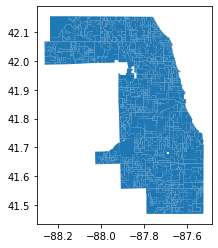

In [8]:
gdf.plot()

In [ ]:
# df = utils.get_df_of_data_portal_data(
#     file_name="cc_neighborhood_boundaries.parquet.gzip",
#     url="https://datacatalog.cookcountyil.gov/api/views/93st-4bxh/rows.csv?accessType=DOWNLOAD",
#     raw_file_path=raw_file_path,
#     force_repull=force_repull,
# )

In [6]:
# url = "https://datacatalog.cookcountyil.gov/api/geospatial/wyzt-dzf8?method=export&format=Shapefile"
# gdf = gpd.read_file(url)

In [16]:
# file_name = "cc_residential_neighborhood_boundaries.parquet.gzip"
# url = "https://datacatalog.cookcountyil.gov/api/geospatial/wyzt-dzf8?method=export&format=Shapefile"
# raw_file_path = None
# force_repull = None

# if raw_file_path is None:
#     raw_file_dir = os.path.join(
#         os.path.expanduser("~"), "projects", "cook_county_real_estate", "data_raw"
#     )
#     raw_file_path = os.path.join(raw_file_dir, file_name)
# else:
#     raw_file_dir = os.path.dirname(raw_file_path)
# os.makedirs(raw_file_dir, exist_ok=True)
# if not os.path.isfile(raw_file_path) or force_repull:
#     gdf = gpd.read_file(url)
#     gdf.to_parquet(raw_file_path, compression="gzip")

/tmp/ipykernel_113870/107836936.py:16: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  gdf.to_parquet(raw_file_path, compression="gzip")


In [22]:
# file_name = "cc_residential_neighborhood_boundaries.parquet.gzip"
# url = "https://datacatalog.cookcountyil.gov/api/geospatial/wyzt-dzf8?method=export&format=Shapefile"

# def get_gdf_of_data_portal_data(
#     file_name: str,
#     url: str,
#     raw_file_path: Union[str, None] = None,
#     force_repull: bool = False,
# ) -> gpd.GeoDataFrame:
#     if raw_file_path is None:
#         raw_file_dir = os.path.join(
#             os.path.expanduser("~"), "projects", "cook_county_real_estate", "data_raw"
#         )
#         raw_file_path = os.path.join(raw_file_dir, file_name)
#     else:
#         raw_file_dir = os.path.dirname(raw_file_path)
#     os.makedirs(raw_file_dir, exist_ok=True)
#     if not os.path.isfile(raw_file_path) or force_repull:
#         gdf = gpd.read_file(url)
#         gdf.to_parquet(raw_file_path, compression="gzip")
#     else:
#         gdf = gpd.read_parquet(raw_file_path)
#     return gdf

In [6]:
raw_file_path = None
force_repull = None


gdf = utils.get_gdf_of_data_portal_data(
    file_name="cc_residential_neighborhood_boundaries.parquet.gzip",
    url= "https://datacatalog.cookcountyil.gov/api/geospatial/wyzt-dzf8?method=export&format=Shapefile",
    raw_file_path=raw_file_path,
    force_repull=force_repull
) 

In [8]:
def get_raw_cc_residential_neighborhood_geodata(
    raw_file_path: Union[str, None] = None, force_repull: bool = False
) -> pd.DataFrame:
    gdf = utils.get_gdf_of_data_portal_data(
        file_name="cc_residential_neighborhood_boundaries.parquet.gzip",
        url= "https://datacatalog.cookcountyil.gov/api/geospatial/wyzt-dzf8?method=export&format=Shapefile",
        raw_file_path=raw_file_path,
        force_repull=force_repull
    )
    return gdf

In [9]:
gdf_test = get_raw_cc_residential_neighborhood_geodata()

In [10]:
gdf_test

,nbhd,town_nbhd,township_c,township_n,triad_code,triad_name,geometry
0,060,29060,29,Palatine,2,North,"POLYGON ((-88.00465 42.09562, -88.00467 42.093..."
1,120,32120,32,Rich,3,South,"POLYGON ((-87.67426 41.49161, -87.67426 41.491..."
2,232,32232,32,Rich,3,South,"POLYGON ((-87.71333 41.54464, -87.71335 41.545..."
3,090,15090,15,Cicero,3,South,"POLYGON ((-87.76341 41.83257, -87.76329 41.832..."
4,081,71081,71,Jefferson,1,City,"POLYGON ((-87.72824 41.97554, -87.72460 41.975..."
...,...,...,...,...,...,...,...
841,180,29180,29,Palatine,2,North,"POLYGON ((-88.03387 42.13563, -88.03385 42.137..."
842,010,19010,19,Lemont,3,South,"POLYGON ((-87.96196 41.68599, -87.97177 41.685..."
843,010,26010,26,Norwood Park,1,North,"POLYGON ((-87.83663 41.97523, -87.83663 41.975..."
844,010,71010,71,Jefferson,1,City,"POLYGON ((-87.76077 41.98790, -87.75937 41.985..."


In [17]:
gdf.head(2)

,nbhd,town_nbhd,township_c,township_n,triad_code,triad_name,geometry
0,060,29060,29,Palatine,2,North,"POLYGON ((-88.00465 42.09562, -88.00467 42.093..."
1,120,32120,32,Rich,3,South,"POLYGON ((-87.67426 41.49161, -87.67426 41.491..."


In [18]:
raw_file_path

'/home/matt/projects/cook_county_real_estate/data_raw/cc_residential_neighborhood_boundaries.parquet.gzip'

In [21]:
def clean_cc_residential_neighborhood_geodata(
    raw_file_path: Union[str, None] = None, force_repull: bool = False
) -> gpd.GeoDataFrame:
    gdf = get_raw_cc_residential_neighborhood_geodata(
        raw_file_path=raw_file_path, force_repull=force_repull
    )
    gdf["triad_code"] = gdf["triad_code"].astype("category")
    gdf["triad_name"] = gdf["triad_name"].astype("category")
    gdf["township_c"] = gdf["township_c"].astype("category")
    gdf["township_n"] = gdf["township_n"].astype("category")
    gdf["nbhd"] = gdf["nbhd"].astype("category")
    return gdf

In [22]:
def get_clean_cc_residential_neighborhood_geodata(
    clean_file_path: Union[str, bool] = None,
    raw_file_path: Union[str, bool] = None,
    force_reclean: bool = False,
    force_repull: bool = False,
) -> gpd.GeoDataFrame:
    if clean_file_path is None:
        file_dir = os.path.join(
            os.path.expanduser("~"), "projects", "cook_county_real_estate", "data_clean"
        )
        clean_file_path = os.path.join(file_dir, "cc_residential_neighborhood_boundaries.parquet.gzip")
    if os.path.isfile(clean_file_path) and not force_reclean and not force_repull:
        gdf = gpd.read_parquet(file_path)
        return gdf
    elif force_reclean and not force_repull:
        gdf = clean_cc_residential_neighborhood_geodata(raw_file_path=raw_file_path)
    else:
        gdf = clean_cc_residential_neighborhood_geodata(
            raw_file_path=raw_file_path, force_repull=force_repull
        )
    gdf.to_parquet(clean_file_path, compression="gzip")
    return gdf

In [23]:
gdf_test2 = get_clean_cc_residential_neighborhood_geodata()

/tmp/ipykernel_114703/2371780009.py:21: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  gdf.to_parquet(clean_file_path, compression="gzip")


In [19]:
gdf_test = gpd.read_parquet(raw_file_path)

In [20]:
gdf_test.head(2)

,nbhd,town_nbhd,township_c,township_n,triad_code,triad_name,geometry
0,060,29060,29,Palatine,2,North,"POLYGON ((-88.00465 42.09562, -88.00467 42.093..."
1,120,32120,32,Rich,3,South,"POLYGON ((-87.67426 41.49161, -87.67426 41.491..."


In [11]:
gdf["triad_code"] = gdf["triad_code"].astype("category")
gdf["triad_name"] = gdf["triad_name"].astype("category")
gdf["township_c"] = gdf["township_c"].astype("category")
gdf["township_n"] = gdf["township_n"].astype("category")
gdf["nbhd"] = gdf["nbhd"].astype("category")

In [12]:
utils.get_df_column_details(gdf)

,feature,unique_vals,pct_unique,null_vals,pct_null
0,triad_code,3,0.3546,0,0.0
1,triad_name,3,0.3546,0,0.0
2,township_c,38,4.4917,0,0.0
3,township_n,38,4.4917,0,0.0
4,nbhd,196,23.1678,0,0.0
5,town_nbhd,845,99.8818,0,0.0
6,geometry,846,100.0000,0,0.0


In [14]:
gdf.head(2)

,nbhd,town_nbhd,township_c,township_n,triad_code,triad_name,geometry
0,060,29060,29,Palatine,2,North,"POLYGON ((-88.00465 42.09562, -88.00467 42.093..."
1,120,32120,32,Rich,3,South,"POLYGON ((-87.67426 41.49161, -87.67426 41.491..."


In [15]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   nbhd        846 non-null    category
 1   town_nbhd   846 non-null    object  
 2   township_c  846 non-null    category
 3   township_n  846 non-null    category
 4   triad_code  846 non-null    category
 5   triad_name  846 non-null    category
 6   geometry    846 non-null    geometry
dtypes: category(5), geometry(1), object(1)
memory usage: 26.8+ KB


In [16]:
gdf = gdf.convert_dtypes()

In [17]:
gdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   nbhd        846 non-null    category
 1   town_nbhd   846 non-null    string  
 2   township_c  846 non-null    category
 3   township_n  846 non-null    category
 4   triad_code  846 non-null    category
 5   triad_name  846 non-null    category
 6   geometry    846 non-null    geometry
dtypes: category(5), geometry(1), string(1)
memory usage: 26.8 KB


In [13]:
gdf["nbhd"].nunique()

196

In [11]:
??gdf.to_parquet

Signature: gdf.to_parquet(path, index=None, compression='snappy', **kwargs)
Source:   
    def to_parquet(self, path, index=None, compression="snappy", **kwargs):
        """Write a GeoDataFrame to the Parquet format.

        Any geometry columns present are serialized to WKB format in the file.

        Requires 'pyarrow'.

        associated metadata.  This is tracking version 0.1.0 of the metadata
        specification at:
        https://github.com/geopandas/geo-arrow-spec

        This metadata specification does not yet make stability promises.  As such,
        we do not yet recommend using this in a production setting unless you are
        able to rewrite your Parquet files.

        .. versionadded:: 0.8

        Parameters
        ----------
        path : str, path object
        index : bool, default None
            If ``True``, always include the dataframe's index(es) as columns
            in the file output.
            If ``False``, the index(es) will not be written 

In [ ]:
gdf

<AxesSubplot:>

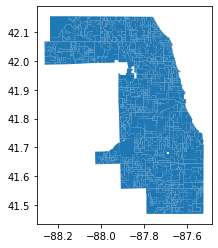

In [9]:
gdf.plot()

In [6]:
cc_sales_df = utils.get_clean_cc_real_estate_sales_data()

In [7]:
cc_sales_df.shape

(1950885, 11)

In [8]:
cc_sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1950885 entries, 0 to 1950884
Data columns (total 11 columns):
 #   Column               Dtype         
---  ------               -----         
 0   PIN                  string        
 1   Recorded date        datetime64[ns]
 2   Executed date        datetime64[ns]
 3   Sale price           Int64         
 4   Arms' length         category      
 5   Validation comments  string        
 6   Deed number          Int64         
 7   Deed type            category      
 8   Seller name          string        
 9   Buyer name           string        
 10  Year                 Int64         
dtypes: Int64(3), category(2), datetime64[ns](2), string(4)
memory usage: 143.3 MB


Per this [International Association of Assessing Officers glossary](https://www.iaao.org/media/Pubs/IAAO_Glossary.pdf) linked to from the [Cook County Assessor's Office GitLab](https://gitlab.com/ccao-data-science---modeling/documentation/wiki_content/-/blob/master/Handbook/Glossary.md), these deed types could be 
* Deed,  Bargain  and  Sale
    * A  bargain  and  sale  deed  implicitly  or  explicitly asserts the grantor’s ownership of the property conveyed, but it makes no guarantees to defend the title. It provides the grant-ee more protection than a quitclaim deed but less than a special warranty deed. The words of conveyance “bargain and sale” dis-tinguish a bargain and sale deed.
* Deed, Trust
    * Broadly,  a  deed  by  which  title  to  property  is  transferred to a trustee to be held in trust. (2) Specifically, a deed by which title to property is transferred, conditionally or uncondition-ally, to a trustee to be held for the benefit of creditors or obligors of the grantor. (3) Loosely, the agreement made between an issu-er of bonds and the holders of such bonds that is deposited with the trustee, whether or not such agreement involves the transfer of property to the trustee. Also called “deed of trust.”
* Deed, Tax
    * A  deed  by  which  title  to  real  property,  sold  to  dis-charge delinquent taxes, is transferred by a tax collector or other authorized officer of the law to the purchaser at a tax sale.
* Deed, Quitclaim,
    * A deed in which the grantor conveys or relin-quishes all interests that he or she may have in a property, without warrant as to the extent or validity of such interests.
* Deed, Warranty
    * A  deed  containing  a  covenant  of  warranty  whereby the grantor of an estate of freehold guarantees that the ti-tle that he or she undertakes to transfer is free from defects and that the property is unencumbered except as stated, and whereby the grantor, for him- or herself and his or her heirs, undertakes to de-fend and protect the grantee against any loss that may be suffered by reason of the existence of any other title or interest in the prop-erty existing at the time the deed was executed and not excepted therein. Contrast deed, quitclaim.
* General Warranty Deed: 
    * The most common type of deed, a gen-eral  warranty  deed,  implicitly  promises  that  (1)  the  grantor  owns  the  property  and  may  convey  title,  (2)  there  are  no  hidden  liens  against the property, (3) no one else has better title to the property, (4)  the  grantor  will  obtain  and  deliver  any  documents  needed  to  make good the transfer, and (5) the grantor will be liable for dam-ages if future competing claims to the property prove valid.


Per [this IL study guide](https://www2.illinois.gov/rev/localgovernments/property/Documents/ptax-1-br.pdf#page=254), deed types other than **Warranty deed** or **Trustee deed** confer less than full ownership (and shouldn't be included in "sales ratio" calculations, whatever those are).

Per [this IL real estate transfer declaration form](https://www2.illinois.gov/rev/localgovernments/property/Documents/ptax-203.pdf), it looks like the deed types are
* Warranty 
* Quit Claim
* Executor
* Trustee
* Beneficial Interest
* Other ("For a deed-in-trust, limited warranty, special warranty, trust deed, or other deed types not listed on this form, select “Other” and write the deed type")

In [42]:
cc_re_sales_df["Deed type"].value_counts(dropna=False)

W      1171908
O       320317
NaN     270614
T       188044
Y            1
o            1
Name: Deed type, dtype: int64

Based on the frequency of `Y`, I'm going to assume that was a typo (presumably should have been a `T`, which is the adjacent key). And for lowercase `o`, I assume that's the same as `O`.

In [9]:
cc_sales_df = utils.get_cc_real_estate_sales_data()
cc_sales_df.shape

(1950885, 11)

In [10]:
cc_sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1950885 entries, 0 to 1950884
Data columns (total 11 columns):
 #   Column               Dtype 
---  ------               ----- 
 0   PIN                  object
 1   Recorded date        object
 2   Executed date        object
 3   Sale price           int64 
 4   Arms' length         int64 
 5   Validation comments  object
 6   Deed number          int64 
 7   Deed type            object
 8   Seller name          object
 9   Buyer name           object
 10  Year                 int64 
dtypes: int64(4), object(7)
memory usage: 163.7+ MB


In [11]:
cc_sales_df = utils.clean_cc_sales_arms_length_col(df=cc_sales_df)
cc_sales_df = utils.clean_cc_sales_deed_type_col(df=cc_sales_df)
cc_sales_df = utils.clean_cc_sales_date_cols(df=cc_sales_df)

In [12]:
cc_sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1950885 entries, 0 to 1950884
Data columns (total 11 columns):
 #   Column               Dtype         
---  ------               -----         
 0   PIN                  object        
 1   Recorded date        datetime64[ns]
 2   Executed date        datetime64[ns]
 3   Sale price           int64         
 4   Arms' length         category      
 5   Validation comments  object        
 6   Deed number          int64         
 7   Deed type            category      
 8   Seller name          object        
 9   Buyer name           object        
 10  Year                 int64         
dtypes: category(2), datetime64[ns](2), int64(3), object(4)
memory usage: 137.7+ MB


In [13]:
cc_sales_df = cc_sales_df.convert_dtypes()

In [14]:
cc_sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1950885 entries, 0 to 1950884
Data columns (total 11 columns):
 #   Column               Dtype         
---  ------               -----         
 0   PIN                  string        
 1   Recorded date        datetime64[ns]
 2   Executed date        datetime64[ns]
 3   Sale price           Int64         
 4   Arms' length         category      
 5   Validation comments  string        
 6   Deed number          Int64         
 7   Deed type            category      
 8   Seller name          string        
 9   Buyer name           string        
 10  Year                 Int64         
dtypes: Int64(3), category(2), datetime64[ns](2), string(4)
memory usage: 143.3 MB


In [16]:
type(os.path.join(
        os.path.expanduser("~"), "projects", "cook_county_real_estate", "data_clean"
    ))

str

In [15]:
def clean_cc_real_estate_sales_data(
    raw_file_path: Union[str, None] = None, force_repull: bool = False
) -> pd.DataFrame:
    cc_sales_df = utils.get_raw_cc_real_estate_sales_data(raw_file_path=raw_file_path, force_repull=force_repull)
    cc_sales_df = utils.clean_cc_sales_arms_length_col(df=cc_sales_df)
    cc_sales_df = utils.clean_cc_sales_deed_type_col(df=cc_sales_df)
    cc_sales_df = utils.clean_cc_sales_date_cols(df=cc_sales_df)
    cc_sales_df = cc_sales_df.convert_dtypes()
    return cc_sales_df

In [ ]:
clean_file_path = None
raw_file_path = None
force_reclean = False
force_repull = False

if clean_file_path is None:
    file_dir = os.path.join(
        os.path.expanduser("~"), "projects", "cook_county_real_estate", "data_clean"
    )
    clean_file_path = os.path.join(file_dir, "cc_real_estate_sales.parquet.gzip")
if os.path.isfile(clean_file_path) and not force_reclean and not force_repull:
    df = pd.read_parquet(file_path)
#     return df
elif force_reclean and not force_repull:
    df = clean_cc_real_estate_sales_data(raw_file_path=raw_file_path)
else:
    df = clean_cc_real_estate_sales_data(
        raw_file_path=raw_file_path, force_repull=force_repull)
    df.to_parquet(clean_file_path, compression="gzip")
    

In [ ]:
def get_clean_cc_real_estate_sales_data(
    clean_file_path: Union[str, bool] = None,
    raw_file_path: Union[str, bool] = None,
    force_reclean: bool = False,
    force_repull: bool = False
):
    if clean_file_path is None:
        file_dir = os.path.join(
            os.path.expanduser("~"), "projects", "cook_county_real_estate", "data_clean"
        )
        clean_file_path = os.path.join(file_dir, "cc_real_estate_sales.parquet.gzip")
    if os.path.isfile(clean_file_path) and not force_reclean and not force_repull:
        df = pd.read_parquet(file_path)
        return df
    elif force_reclean and not force_repull:
        df = clean_cc_real_estate_sales_data(raw_file_path=raw_file_path)
    else:
        df = clean_cc_real_estate_sales_data(
            raw_file_path=raw_file_path, force_repull=force_repull)
    df.to_parquet(clean_file_path, compression="gzip")
    return df

In [11]:
cc_sales_df = utils.get_raw_cc_real_estate_sales_data()
cc_sales_df = utils.clean_cc_sales_arms_length_col(df=cc_sales_df)
cc_sales_df = utils.clean_cc_sales_deed_type_col(df=cc_sales_df)
cc_sales_df = utils.clean_cc_sales_date_cols(df=cc_sales_df)
cc_sales_df = cc_sales_df.convert_dtypes()

In [12]:
cc_sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1950885 entries, 0 to 1950884
Data columns (total 11 columns):
 #   Column               Dtype         
---  ------               -----         
 0   PIN                  object        
 1   Recorded date        datetime64[ns]
 2   Executed date        datetime64[ns]
 3   Sale price           int64         
 4   Arms' length         category      
 5   Validation comments  object        
 6   Deed number          int64         
 7   Deed type            category      
 8   Seller name          object        
 9   Buyer name           object        
 10  Year                 int64         
dtypes: category(2), datetime64[ns](2), int64(3), object(4)
memory usage: 137.7+ MB


In [4]:
url = "https://datacatalog.cookcountyil.gov/api/views/8f9d-wy2d/rows.csv?accessType=DOWNLOAD"
cc_df = pd.read_csv(url)
cc_df.shape

/home/matt/miniconda3/envs/geo_env/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (3,4,5,21,23,24,25,28,29,30,31,33,36,37,38,39,40,41,43,44,45,46,47,48,49,66,67,68) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(678656, 80)

In [5]:
cc_df.head(2)

,Property Index Number,Assessment Triad,Property Class,Property Address,Property Apartment Num.,Property City,Township Name,Township Code,Neighborhood Code,Township Neighborhood Only,Modeling Group,Proportion Assessed,Key PIN,Multi Code Indicator,Multi Code,Number of Active 288s (HIEs),Number of Ended 288s (HIEs),Sale Date,Sale Price,Sale Document Number,Land Square Feet,Large Home Indicator,Age,Apartments,Wall Material,Roof Material,Rooms,Bedrooms,Basement,Basement Finish,Central Heating,Central Air Conditioning,Fireplaces,Attic Type,Full Baths,Half Baths,Design Plan,Cathedral Ceiling,Garage 1 Size,Garage 1 Material,Garage 1 Attached,Garage 1 Area,Building Square Feet,Repair Condition,Use,Type of Residence,Attic Finish,Renovation,Porch,Property Zip Code,Tract GEOID,Municipality FIPS Code,Municipality Name,O'Hare Noise Indicator,FEMA Floodplain,Flood Risk Factor,Flood Risk Direction,Road Proximity < 100 Feet,Road Proximity 101 - 300 Feet,Elementary/Middle School District,High School District,Longitude,Latitude,geoposition,Tax Rate,Tract Median Income,Condo Model: Building PIN,Condo Model: Modeled Unit Strata (of 10),Condo Model: Modeled Unit Strata (of 300),Modeled Sale Year,Modeled Sale Month of Year,Modeled Sale Day of Year,Modeled Sale Week of Year,Modeled Sale Quarter of Year,Modeled Sale Quarter,Modeled Sale Month,Modeled Sale Week,Modeled Sale Day,Modeled Sale During School Year,Modeled Sale During Holidays
0,14-05-211-025-1061,City,299,NaN,NaN,NaN,Lake View,73,73031,31,NCHARS,0.008429,14-05-211-025-1001,0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17031030102,14000.0,Chicago,0,0,1,0,0,1,SWIFT,SENN HS,-87.655035,41.992730,POINT (-87.655035020409 41.9927297954114),6.89,45086,14-05-211-025,$121K - $146K (roughly),$123k to $124k (roughly),2021,Jan,1,1,Q1,96,288,1252,8766,True,True
1,17-16-128-007-1009,City,299,NaN,NaN,NaN,West Chicago,77,77131,131,NCHARS,0.002306,17-16-128-007-1001,0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17031841900,14000.0,Chicago,0,0,6,0,0,1,SMYTH,WELLS HS,-87.641703,41.874852,POINT (-87.6417033557508 41.8748517554364),6.89,116377,17-16-128-007,$203K - $242K (roughly),$229k to $231k (roughly),2021,Jan,1,1,Q1,96,288,1252,8766,True,True


In [8]:
df = cc_df

col_list = list(df.columns)
n_rows = df.shape[0]
df_details = pd.DataFrame({
    "feature": [col for col in col_list],
    "unique_vals": [df[col].nunique() for col in col_list],
    "pct_unique": [round(100 * df[col].nunique()/n_rows, 4) for col in col_list],
    "null_vals": [df[col].isnull().sum() for col in col_list],
    "pct_null": [round(100 * df[col].isnull().sum() / n_rows, 4) for col in col_list]    
})

In [9]:
df_details.head(2)

,feature,unique_vals,pct_unique,null_vals,pct_null
0,Property Index Number,672900,99.1519,0,0.0
1,Assessment Triad,1,0.0001,0,0.0


In [11]:
df_details = df_details.sort_values(by="unique_vals")
df_details = df_details.reset_index(drop=True)

In [12]:
df_details

,feature,unique_vals,pct_unique,null_vals,pct_null
0,Modeled Sale During Holidays,1,0.0001,0,0.0000
1,Modeled Sale Year,1,0.0001,0,0.0000
2,Modeled Sale Month of Year,1,0.0001,0,0.0000
3,Modeled Sale Week of Year,1,0.0001,0,0.0000
4,Modeled Sale Quarter of Year,1,0.0001,0,0.0000
...,...,...,...,...,...
75,Property Address,422638,62.2757,240618,35.4551
76,Longitude,446753,65.8291,0,0.0000
77,Latitude,446754,65.8292,0,0.0000
78,geoposition,446754,65.8292,0,0.0000


In [13]:
cc_df["Modeled Sale Year"].value_counts(dropna=False)

2021    678656
Name: Modeled Sale Year, dtype: int64

In [28]:
data_documentation_url = "https://datacatalog.cookcountyil.gov/Property-Taxation/Cook-County-Assessor-s-Sales/93st-4bxh"
url = "https://datacatalog.cookcountyil.gov/api/views/93st-4bxh/rows.csv?accessType=DOWNLOAD"

cc_re_sales_df = pd.read_csv(url, low_memory=False)

In [29]:
cc_re_sales_df.shape

(1950885, 11)

In [30]:
os.getcwd()

'/home/matt/projects/cook_county_real_estate/code'

In [34]:
outpath = os.path.join(os.path.expanduser("~"), "projects", "cook_county_real_estate", "cc_real_estate_sales_raw.parquet.gzip")
if not os.path.isfile(outpath):
    cc_re_sales_df.to_parquet(outpath, compression="gzip")

In [35]:
cc_re_sales_df.head(2)

,PIN,Recorded date,Executed date,Sale price,Arms' length,Validation comments,Deed number,Deed type,Seller name,Buyer name,Year
0,20-33-212-020-0000,05/03/2004 12:00:00 AM,03/02/2004 12:00:00 AM,180000,9,Has not been validated,412449017,W,SMITH KEESHA,NEIL RAYMOND R,2004
1,10-31-100-016-1038,07/25/2016 12:00:00 AM,NaN,255000,9,Has not been validated,1620756085,W,NaN,NaN,2016


In [17]:
def get_df_column_details(df: pd.DataFrame) -> pd.DataFrame:
    col_list = list(df.columns)
    n_rows = df.shape[0]
    df_details = pd.DataFrame({
        "feature": [col for col in col_list],
        "unique_vals": [df[col].nunique() for col in col_list],
        "pct_unique": [round(100 * df[col].nunique()/n_rows, 4) for col in col_list],
        "null_vals": [df[col].isnull().sum() for col in col_list],
        "pct_null": [round(100 * df[col].isnull().sum() / n_rows, 4) for col in col_list]    
    })
    df_details = df_details.sort_values(by="unique_vals")
    df_details = df_details.reset_index(drop=True)
    return df_details

In [ ]:
# data_documentation_url = "https://datacatalog.cookcountyil.gov/Property-Taxation/Cook-County-Assessor-s-Sales/93st-4bxh"

raw_file_path = None 
force_repull = False
file_name = "cc_real_estate_sales_raw.parquet.gzip"
url = "https://datacatalog.cookcountyil.gov/api/views/93st-4bxh/rows.csv?accessType=DOWNLOAD"

if raw_file_path is None:
    raw_file_dir = os.path.join(os.path.expanduser("~"), "projects", "cook_county_real_estate")
    raw_file_path = os.path.join(raw_file_dir, file_name)
else:
    raw_file_dir = os.path.dirname(raw_file_path)    
os.makedirs(raw_file_dir, exist_ok=True)

if os.path.isfile(raw_file_path) or force_repull:    
    cc_re_sales_df = pd.read_csv(url, low_memory=False)
else:
    cc_re_sales_df = pd.read_parquet(raw_file_path)
    

In [67]:
# data_documentation_url = "https://datacatalog.cookcountyil.gov/Property-Taxation/Cook-County-Assessor-s-Sales/93st-4bxh"

def get_df_of_data_portal_data(file_name: str, url: str, raw_file_path: Union[str, None] = None,
force_repull: bool = False) -> pd.DataFrame:
    if raw_file_path is None:
        raw_file_dir = os.path.join(os.path.expanduser("~"), "projects", "cook_county_real_estate", "data_raw")
        raw_file_path = os.path.join(raw_file_dir, file_name)
    else:
        raw_file_dir = os.path.dirname(raw_file_path)    
    os.makedirs(raw_file_dir, exist_ok=True)
    
    if not os.path.isfile(raw_file_path) or force_repull:    
        df = pd.read_csv(url, low_memory=False)
        df.to_parquet(raw_file_path, compression="gzip")
    else:
        df = pd.read_parquet(raw_file_path)
    return df
    

In [68]:
cc_re_sales_df = get_df_of_data_portal_data(
    file_name = "cc_real_estate_sales_raw.parquet.gzip",
    url = "https://datacatalog.cookcountyil.gov/api/views/93st-4bxh/rows.csv?accessType=DOWNLOAD"
)

In [68]:
def get_cc_real_estate_sales_data(
    raw_file_path: Union[str, None] = None, force_repull: bool = False
) -> pd.DataFrame:
    df = get_df_of_data_portal_data(
        file_name = "cc_real_estate_sales_raw.parquet.gzip",
        url = "https://datacatalog.cookcountyil.gov/api/views/93st-4bxh/rows.csv?accessType=DOWNLOAD",
        raw_file_path=raw_file_path,
        force_repull=force_repull
    )
    return df

In [69]:
cc_re_sales_df.shape

(1950885, 11)

In [70]:
cc_re_sales_details = get_df_column_details(df=cc_re_sales_df)

In [71]:
cc_re_sales_details

,feature,unique_vals,pct_unique,null_vals,pct_null
0,Arms' length,3,0.0002,0,0.0000
1,Deed type,5,0.0003,270614,13.8713
2,Year,24,0.0012,0,0.0000
3,Validation comments,3038,0.1557,8141,0.4173
4,Executed date,4879,0.2501,1173501,60.1522
5,Recorded date,6668,0.3418,0,0.0000
6,Sale price,90460,4.6369,0,0.0000
7,Seller name,568863,29.1592,1173376,60.1458
8,Buyer name,611075,31.3230,1173480,60.1512
9,PIN,1021886,52.3806,0,0.0000


In [38]:
cc_re_sales_df["Arms\' length"].value_counts(dropna=False)

9    1931788
0       9607
1       9490
Name: Arms' length, dtype: int64

In [39]:
if 9 in cc_re_sales_df["Arms\' length"].unique():
    arms_length_map = {
        0: "no",
        1: "yes",
        9: "unknown"
    }
    cc_re_sales_df["Arms\' length"] = cc_re_sales_df["Arms\' length"].map(arms_length_map)
    cc_re_sales_df["Arms\' length"] = cc_re_sales_df["Arms\' length"].astype("category")

In [40]:
cc_re_sales_df["Arms\' length"].value_counts(dropna=False)

unknown    1931788
no            9607
yes           9490
Name: Arms' length, dtype: int64

Per this [International Association of Assessing Officers glossary](https://www.iaao.org/media/Pubs/IAAO_Glossary.pdf) linked to from the [Cook County Assessor's Office GitLab](https://gitlab.com/ccao-data-science---modeling/documentation/wiki_content/-/blob/master/Handbook/Glossary.md), these deed types could be 
* Deed,  Bargain  and  Sale
    * A  bargain  and  sale  deed  implicitly  or  explicitly asserts the grantor’s ownership of the property conveyed, but it makes no guarantees to defend the title. It provides the grant-ee more protection than a quitclaim deed but less than a special warranty deed. The words of conveyance “bargain and sale” dis-tinguish a bargain and sale deed.
* Deed, Trust
    * Broadly,  a  deed  by  which  title  to  property  is  transferred to a trustee to be held in trust. (2) Specifically, a deed by which title to property is transferred, conditionally or uncondition-ally, to a trustee to be held for the benefit of creditors or obligors of the grantor. (3) Loosely, the agreement made between an issu-er of bonds and the holders of such bonds that is deposited with the trustee, whether or not such agreement involves the transfer of property to the trustee. Also called “deed of trust.”
* Deed, Tax
    * A  deed  by  which  title  to  real  property,  sold  to  dis-charge delinquent taxes, is transferred by a tax collector or other authorized officer of the law to the purchaser at a tax sale.
* Deed, Quitclaim,
    * A deed in which the grantor conveys or relin-quishes all interests that he or she may have in a property, without warrant as to the extent or validity of such interests.
* Deed, Warranty
    * A  deed  containing  a  covenant  of  warranty  whereby the grantor of an estate of freehold guarantees that the ti-tle that he or she undertakes to transfer is free from defects and that the property is unencumbered except as stated, and whereby the grantor, for him- or herself and his or her heirs, undertakes to de-fend and protect the grantee against any loss that may be suffered by reason of the existence of any other title or interest in the prop-erty existing at the time the deed was executed and not excepted therein. Contrast deed, quitclaim.
* General Warranty Deed: 
    * The most common type of deed, a gen-eral  warranty  deed,  implicitly  promises  that  (1)  the  grantor  owns  the  property  and  may  convey  title,  (2)  there  are  no  hidden  liens  against the property, (3) no one else has better title to the property, (4)  the  grantor  will  obtain  and  deliver  any  documents  needed  to  make good the transfer, and (5) the grantor will be liable for dam-ages if future competing claims to the property prove valid.


Per [this IL study guide](https://www2.illinois.gov/rev/localgovernments/property/Documents/ptax-1-br.pdf#page=254), deed types other than **Warranty deed** or **Trustee deed** confer less than full ownership (and shouldn't be included in "sales ratio" calculations, whatever those are).

Per [this IL real estate transfer declaration form](https://www2.illinois.gov/rev/localgovernments/property/Documents/ptax-203.pdf), it looks like the deed types are
* Warranty 
* Quit Claim
* Executor
* Trustee
* Beneficial Interest
* Other ("For a deed-in-trust, limited warranty, special warranty, trust deed, or other deed types not listed on this form, select “Other” and write the deed type")

In [42]:
cc_re_sales_df["Deed type"].value_counts(dropna=False)

W      1171908
O       320317
NaN     270614
T       188044
Y            1
o            1
Name: Deed type, dtype: int64

Based on the frequency of `Y`, I'm going to assume that was a typo (presumably should have been a `T`, which is the adjacent key). And for lowercase `o`, I assume that's the same as `O`.

In [85]:
deed_type_map = {
    "W": "Warranty",
    "O": "Other",
    "o": "Other",
    "T": "Trustee",
    "Y": "Trustee"
}
cc_re_sales_df["Deed type"].map(deed_type_map).value_counts(dropna=False)

Warranty    1171908
Other        320318
NaN          270614
Trustee      188045
Name: Deed type, dtype: int64

In [91]:
if "Warranty" not in cc_re_sales_df["Deed type"].unique():
    deed_type_map = {
        "W": "Warranty",
        "O": "Other",
        "o": "Other",
        "T": "Trustee",
        "Y": "Trustee"
    }
    cc_re_sales_df["Deed type"] = cc_re_sales_df["Deed type"].map(deed_type_map)

In [93]:
def clean_cc_sales_deed_type_col(df: pd.DataFrame) -> pd.DataFrame:
    if "Warranty" not in df["Deed type"].unique():
        deed_type_map = {
            "W": "Warranty",
            "O": "Other",
            "o": "Other",
            "T": "Trustee",
            "Y": "Trustee"
        }
        df["Deed type"] = df["Deed type"].map(deed_type_map)
    df["Deed type"] = df["Deed type"].astype("category")
    return df

In [94]:
cc_re_sales_df = clean_cc_sales_deed_type_col(df=cc_re_sales_df)

In [83]:
cc_re_sales_df.loc[
    (cc_re_sales_df["Deed type"] == "Y")
]

,PIN,Recorded date,Executed date,Sale price,Arms' length,Validation comments,Deed number,Deed type,Seller name,Buyer name,Year
102406,06-08-111-007-1129,08/15/2008 12:00:00 AM,06/26/2008 12:00:00 AM,210000,9,Has not been validated,822805013,Y,HSBC BK USA,KHANANI HINA,2008


In [82]:
cc_re_sales_df.loc[
    (cc_re_sales_df["Deed type"] == "o") & 
    (cc_re_sales_df["Validation comments"] != "Has not been validated")
]

,PIN,Recorded date,Executed date,Sale price,Arms' length,Validation comments,Deed number,Deed type,Seller name,Buyer name,Year
983410,01-35-200-014-0000,04/10/2003 12:00:00 AM,NaN,332775,9,Has not been validated,30486482,o,NaN,NaN,2003


In [74]:
cc_re_sales_df.loc[
    (cc_re_sales_df["Deed type"] == "W") & 
    (cc_re_sales_df["Validation comments"] != "Has not been validated")
]

,PIN,Recorded date,Executed date,Sale price,Arms' length,Validation comments,Deed number,Deed type,Seller name,Buyer name,Year
221,20-29-421-005-0000,05/30/2019 12:00:00 AM,NaN,350000,1,Renovated,1915033120,W,NaN,NaN,2019
244,12-01-315-052-0000,07/25/2017 12:00:00 AM,NaN,1100000,0,property not advertised,1720615144,W,NaN,NaN,2017
414,17-07-100-033-0000,05/29/2014 12:00:00 AM,NaN,525000,0,REO,1414904006,W,NaN,NaN,2014
584,29-27-300-016-0000,02/21/2020 12:00:00 AM,NaN,250000,1,NaN,2004417214,W,NaN,NaN,2020
712,28-03-209-014-0000,05/18/2015 12:00:00 AM,NaN,10000,0,NaN,1513208131,W,NaN,NaN,2015
...,...,...,...,...,...,...,...,...,...,...,...
1948938,17-05-325-007-0000,08/27/2013 12:00:00 AM,NaN,300000,0,Imp. is a Condo.,1323956038,W,NaN,NaN,2013
1949378,16-15-201-006-0000,12/08/2017 12:00:00 AM,NaN,150000,0,does not appear to have been advertised for sale,1734234045,W,NaN,NaN,2017
1949807,14-33-307-053-0000,09/26/2014 12:00:00 AM,NaN,419000,1,"$439,000 - 10/22/18",1426935097,W,NaN,NaN,2014
1950053,16-11-405-029-0000,05/11/2020 12:00:00 AM,NaN,15000,0,NaN,2013239149,W,NaN,NaN,2020


In [95]:
cc_re_sales_df.head(2)

,PIN,Recorded date,Executed date,Sale price,Arms' length,Validation comments,Deed number,Deed type,Seller name,Buyer name,Year
0,20-33-212-020-0000,05/03/2004 12:00:00 AM,03/02/2004 12:00:00 AM,180000,9,Has not been validated,412449017,Warranty,SMITH KEESHA,NEIL RAYMOND R,2004
1,10-31-100-016-1038,07/25/2016 12:00:00 AM,NaN,255000,9,Has not been validated,1620756085,Warranty,NaN,NaN,2016


In [96]:
cc_re_sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1950885 entries, 0 to 1950884
Data columns (total 11 columns):
 #   Column               Dtype   
---  ------               -----   
 0   PIN                  object  
 1   Recorded date        object  
 2   Executed date        object  
 3   Sale price           int64   
 4   Arms' length         int64   
 5   Validation comments  object  
 6   Deed number          int64   
 7   Deed type            category
 8   Seller name          object  
 9   Buyer name           object  
 10  Year                 int64   
dtypes: category(1), int64(4), object(6)
memory usage: 150.7+ MB


In [109]:
# df = cc_re_sales_df
date_cols = cc_re_sales_df.head(2).filter(regex="[Dd][Aa][Tt][Ee]$").columns
for date_col in date_cols:
    cc_re_sales_df[f"{date_col}_fix"] = pd.to_datetime(cc_re_sales_df[date_col], format="%m/%d/%Y %I:%M:%S %p", errors="coerce")

In [237]:
cc_re_sales_df.loc[
    (cc_re_sales_df["Executed date"].notnull()) & 
    (cc_re_sales_df["Executed date_fix"].isnull()),
]

,PIN,Recorded date,Executed date,Sale price,Arms' length,Validation comments,Deed number,Deed type,Seller name,Buyer name,Year,Recorded date_fix,Executed date_fix,date_diff
241878,27-27-104-025-0000,2006-02-01,12/29/2995 12:00:00 AM,227000,9,Has not been validated,603243356,Other,BANKERS TRUST CO CA,ABUHADBA MOUSA,2006,2006-02-01,NaT,NaN


In [238]:
cc_re_sales_df.shape

(1950885, 14)

Ok, only 1 out of nearly 2M records have a bad date, and it's for a sale from 2005 or 2006 (and the recorded date is fine). I'm fine with losing this datum.

In [240]:
cc_re_sales_df = cc_re_sales_df.drop(columns=["Recorded date_fix", "Executed date_fix"])

In [241]:
date_cols = cc_re_sales_df.head(2).filter(regex="[Dd][Aa][Tt][Ee]$").columns
for date_col in date_cols:
    cc_re_sales_df[date_col] = pd.to_datetime(cc_re_sales_df[date_col], format="%m/%d/%Y %I:%M:%S %p", errors="coerce")

In [249]:
def clean_cc_sales_date_cols(df: pd.DataFrame, date_cols: Union[List, None] = None) -> pd.DataFrame:
    if date_cols is None:
        date_cols = df.head(2).filter(regex="[Dd][Aa][Tt][Ee]$").columns
    for date_col in date_cols:
        df[date_col] = pd.to_datetime(df[date_col], format="%m/%d/%Y %I:%M:%S %p", errors="coerce")
    return df

In [242]:
cc_re_sales_df.head(2)

,PIN,Recorded date,Executed date,Sale price,Arms' length,Validation comments,Deed number,Deed type,Seller name,Buyer name,Year
0,20-33-212-020-0000,2004-05-03,2004-03-02,180000,9,Has not been validated,412449017,Warranty,SMITH KEESHA,NEIL RAYMOND R,2004
1,10-31-100-016-1038,2016-07-25,NaT,255000,9,Has not been validated,1620756085,Warranty,NaN,NaN,2016


In [243]:
cc_re_sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1950885 entries, 0 to 1950884
Data columns (total 11 columns):
 #   Column               Dtype         
---  ------               -----         
 0   PIN                  object        
 1   Recorded date        datetime64[ns]
 2   Executed date        datetime64[ns]
 3   Sale price           int64         
 4   Arms' length         int64         
 5   Validation comments  object        
 6   Deed number          int64         
 7   Deed type            category      
 8   Seller name          object        
 9   Buyer name           object        
 10  Year                 int64         
dtypes: category(1), datetime64[ns](2), int64(4), object(4)
memory usage: 150.7+ MB


In [244]:
cc_re_sales_df = cc_re_sales_df.convert_dtypes()

In [247]:
cc_re_sales_df["Arms\' length"] = cc_re_sales_df["Arms\' length"].astype("category")

In [248]:
cc_re_sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1950885 entries, 0 to 1950884
Data columns (total 11 columns):
 #   Column               Dtype         
---  ------               -----         
 0   PIN                  string        
 1   Recorded date        datetime64[ns]
 2   Executed date        datetime64[ns]
 3   Sale price           Int64         
 4   Arms' length         category      
 5   Validation comments  string        
 6   Deed number          Int64         
 7   Deed type            category      
 8   Seller name          string        
 9   Buyer name           string        
 10  Year                 Int64         
dtypes: Int64(3), category(2), datetime64[ns](2), string(4)
memory usage: 143.3 MB


In [109]:
# df = cc_re_sales_df
date_cols = cc_re_sales_df.head(2).filter(regex="[Dd][Aa][Tt][Ee]$").columns
for date_col in date_cols:
    cc_re_sales_df[f"{date_col}_fix"] = pd.to_datetime(cc_re_sales_df[date_col], format="%m/%d/%Y %I:%M:%S %p", errors="coerce")

In [105]:
date_cols

Index(['Recorded date', 'Executed date'], dtype='object')

In [110]:
cc_re_sales_df.head(2)

,PIN,Recorded date,Executed date,Sale price,Arms' length,Validation comments,Deed number,Deed type,Seller name,Buyer name,Year,Recorded date_fix,Executed date_fix
0,20-33-212-020-0000,2004-05-03,03/02/2004 12:00:00 AM,180000,9,Has not been validated,412449017,Warranty,SMITH KEESHA,NEIL RAYMOND R,2004,2004-05-03,2004-03-02
1,10-31-100-016-1038,2016-07-25,NaN,255000,9,Has not been validated,1620756085,Warranty,NaN,NaN,2016,2016-07-25,NaT


In [115]:
from pandas.api.types import is_datetime64_any_dtype

In [152]:
bad_exec_date_mask = (
    (cc_re_sales_df["Executed date"].notnull()) &
    (cc_re_sales_df["Executed date_fix"].isnull())
)
if is_datetime64_any_dtype(cc_re_sales_df.loc[bad_exec_date_mask, "Recorded date"]):
    rec_dates = cc_re_sales_df.loc[bad_exec_date_mask, ["Recorded date"]].copy()
    bad_exec_dates = cc_re_sales_df.loc[bad_exec_date_mask, ["Executed date"]].copy()

In [201]:
good_dates_mask = (
    (cc_re_sales_df["Recorded date_fix"].notnull()) & 
    (cc_re_sales_df["Executed date_fix"].notnull())
)
cc_re_sales_df.loc[good_dates_mask, "date_diff"] = (
    cc_re_sales_df.loc[good_dates_mask, "Recorded date_fix"] - cc_re_sales_df.loc[good_dates_mask, "Executed date_fix"]
)

In [202]:
cc_re_sales_df.head(2)

,PIN,Recorded date,Executed date,Sale price,Arms' length,Validation comments,Deed number,Deed type,Seller name,Buyer name,Year,Recorded date_fix,Executed date_fix,date_diff
0,20-33-212-020-0000,2004-05-03,03/02/2004 12:00:00 AM,180000,9,Has not been validated,412449017,Warranty,SMITH KEESHA,NEIL RAYMOND R,2004,2004-05-03,2004-03-02,62 days
1,10-31-100-016-1038,2016-07-25,NaN,255000,9,Has not been validated,1620756085,Warranty,NaN,NaN,2016,2016-07-25,NaT,NaT


In [214]:
cc_re_sales_df["date_diff"] = cc_re_sales_df["date_diff"].dt.days

In [215]:
cc_re_sales_df

,PIN,Recorded date,Executed date,Sale price,Arms' length,Validation comments,Deed number,Deed type,Seller name,Buyer name,Year,Recorded date_fix,Executed date_fix,date_diff
0,20-33-212-020-0000,2004-05-03,03/02/2004 12:00:00 AM,180000,9,Has not been validated,412449017,Warranty,SMITH KEESHA,NEIL RAYMOND R,2004,2004-05-03,2004-03-02,62.0
1,10-31-100-016-1038,2016-07-25,NaN,255000,9,Has not been validated,1620756085,Warranty,NaN,NaN,2016,2016-07-25,NaT,NaN
2,10-30-200-034-1015,2001-01-31,01/26/2001 12:00:00 AM,145000,9,Has not been validated,10084145,Warranty,TULSKI LISA,WILDING NICHOL R,2001,2001-01-31,2001-01-26,5.0
3,16-23-303-018-0000,2020-09-23,NaN,200000,9,Has not been validated,2026720225,Warranty,NaN,NaN,2020,2020-09-23,NaT,NaN
4,14-07-412-010-1029,1999-01-01,NaN,250357,9,Has not been validated,99055476,NaN,NaN,NaN,1999,1999-01-01,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1950880,04-04-305-054-0000,2014-07-11,NaN,321000,9,Has not been validated,1419212127,Warranty,NaN,NaN,2014,2014-07-11,NaT,NaN
1950881,02-14-419-008-0000,2002-10-28,10/23/2002 12:00:00 AM,193000,9,Has not been validated,21184517,Trustee,LASALLE BK NATL ASSN TR 0000011718103,BURCK PAUL D,2002,2002-10-28,2002-10-23,5.0
1950882,20-25-330-001-0000,1999-10-07,NaN,340000,9,Has not been validated,9115992,NaN,NaN,NaN,1999,1999-10-07,NaT,NaN
1950883,19-01-406-015-0000,2016-12-13,NaN,65000,9,Has not been validated,1634819080,Other,NaN,NaN,2016,2016-12-13,NaT,NaN


In [222]:
cc_re_sales_df.loc[
    (cc_re_sales_df["date_diff"] <= -1000) |
    (cc_re_sales_df["date_diff"] >= 1000)
]

,PIN,Recorded date,Executed date,Sale price,Arms' length,Validation comments,Deed number,Deed type,Seller name,Buyer name,Year,Recorded date_fix,Executed date_fix,date_diff
5,14-21-110-048-2003,2007-01-22,01/01/1900 12:00:00 AM,38500,9,Has not been validated,702242099,Warranty,NEW YORK RESID LLC,PAULAN KENNETH JR,2007,2007-01-22,1900-01-01,39102.0
143,27-06-403-009-0000,2007-07-27,01/01/1900 12:00:00 AM,385000,9,Has not been validated,720802061,Warranty,BERMAN-ROBINSON SHERRY H,MYERS SEAN M,2007,2007-07-27,1900-01-01,39288.0
385,17-07-215-028-0000,2006-06-23,05/26/2002 12:00:00 AM,230000,9,Has not been validated,617404133,Warranty,NAVARRETE LUIS,MORRIS WESLEY,2006,2006-06-23,2002-05-26,1489.0
605,11-32-102-018-1026,2007-08-06,01/01/1900 12:00:00 AM,164900,9,Has not been validated,721841080,Warranty,ESTES VINTAGE RENOVATIONS LLC,ZIOLKOWSKI TIMOTHY K,2007,2007-08-06,1900-01-01,39298.0
1494,19-01-213-050-0000,2008-05-28,08/24/2005 12:00:00 AM,195000,9,Has not been validated,814918053,Warranty,DUARTE ANTONIO,VILLAREAL FELIPE,2008,2008-05-28,2005-08-24,1008.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1950592,17-06-422-060-1002,2009-06-24,01/01/1900 12:00:00 AM,364000,9,Has not been validated,917533046,Warranty,DOCTOR GINA M,MCCONNELL JOHN,2009,2009-06-24,1900-01-01,39986.0
1950599,20-10-207-009-0000,2006-12-11,01/01/1900 12:00:00 AM,295000,9,Has not been validated,634520075,Warranty,MTGLQ INV L P,HUTT LILLETT,2006,2006-12-11,1900-01-01,39060.0
1950632,13-07-330-023-0000,2003-05-14,01/01/1900 12:00:00 AM,295000,9,Has not been validated,313429082,Warranty,CAMPBELL FRANCIS B,HAMBY JULIA,2003,2003-05-14,1900-01-01,37753.0
1950724,13-32-214-041-0000,2007-03-27,01/01/1900 12:00:00 AM,375000,9,Has not been validated,708626004,Warranty,YUNEZ MARIANA,MUNOZ ESTHER,2007,2007-03-27,1900-01-01,39166.0


(-100.0, 500.0)

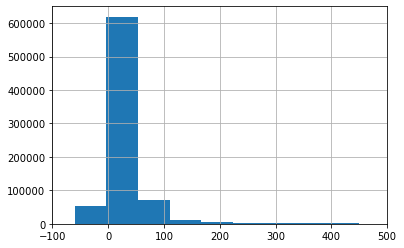

In [236]:
plot_df = cc_re_sales_df.loc[
    (cc_re_sales_df["date_diff"] >= -100) |
    (cc_re_sales_df["date_diff"] <= 1000)
].copy()

ax = plot_df["date_diff"].hist(bins=2000)
ax.set_xlim([-100, 500])

<AxesSubplot:ylabel='Frequency'>

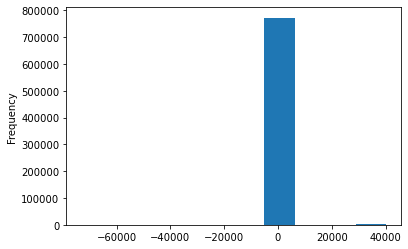

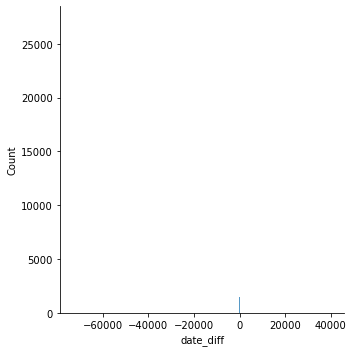

In [216]:
sns.displot(x="date_diff", data=cc_re_sales_df)

In [154]:
rec_dates

,Recorded date
241878,2006-02-01


In [155]:
rec_years = rec_dates["Recorded date"].dt.year.values
rec_years

array([2006])

In [172]:
bad_datetime_parts = bad_exec_dates["Executed date"].str.split(expand=True)
bad_datetime_parts
# .str[0].str.split("/")

,0,1,2
241878,12/29/2995,12:00:00,AM


In [173]:
bad_date_parts = bad_datetime_parts[0].str.split("/", expand=True)
bad_date_parts = bad_date_parts.rename(columns={0:"month", 1:"day", 2:"year"})
bad_date_parts = bad_date_parts.astype(int)
bad_time_parts = bad_datetime_parts[1].str.split(":", expand=True)
bad_time_parts = bad_time_parts.rename(columns={0:"hour", 1:"minute", 2:"second"})

In [174]:
bad_datetime_parts = pd.merge(
    left=bad_date_parts,
    right=bad_time_parts,
    how="inner",
    left_index=True,
    right_index=True
)

In [175]:
bad_datetime_parts

,month,day,year,hour,minute,second
241878,12,29,2995,12,00,00


In [176]:
rec_dates

,Recorded date
241878,2006-02-01


In [179]:
rec_dates["month"] = rec_dates["Recorded date"].dt.month
rec_dates["day"] = rec_dates["Recorded date"].dt.day
rec_dates["year"] = rec_dates["Recorded date"].dt.year

In [181]:
rec_dates

,Recorded date,month,day,year
241878,2006-02-01,2,1,2006


In [193]:
date_fix_df = pd.merge(
    left=rec_dates,
    right=bad_datetime_parts,
    how="inner",
    left_index=True,
    right_index=True,
    suffixes=("_rec", "_exec")
)
date_fix_df = date_fix_df.convert_dtypes()

In [194]:
date_fix_df

,Recorded date,month_rec,day_rec,year_rec,month_exec,day_exec,year_exec,hour,minute,second
241878,2006-02-01,2,1,2006,12,29,2995,12,00,00


In [ ]:
date_fix_df

In [195]:
date_fix_df["year_rec"] - date_fix_df["year_exec"]

241878    -989
dtype: Int64

In [189]:
date_fix_df[date_fix_df.filter(like="_exec").columns]

,month_exec,day_exec,year_exec
241878,12,29,2995


In [200]:
datetime(year=2995, month=12, day=29)

datetime.datetime(2995, 12, 29, 0, 0)

In [132]:
exec_year_list = bad_exec_dates.str.split().str[0].str.split("/").str[-1].values
exec_year_list

array(['2995'], dtype=object)

In [112]:
cc_re_sales_df.columns

Index(['PIN', 'Recorded date', 'Executed date', 'Sale price', 'Arms' length',
       'Validation comments', 'Deed number', 'Deed type', 'Seller name',
       'Buyer name', 'Year', 'Recorded date_fix', 'Executed date_fix'],
      dtype='object')

In [107]:
# cc_re_sales_df = cc_re_sales_df.drop(columns=['Recorded date_fix', 'Executed date_fix',
#        'Recorded date_fix_fix'])

In [103]:
cc_re_sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1950885 entries, 0 to 1950884
Data columns (total 14 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   PIN                    object        
 1   Recorded date          datetime64[ns]
 2   Executed date          object        
 3   Sale price             int64         
 4   Arms' length           int64         
 5   Validation comments    object        
 6   Deed number            int64         
 7   Deed type              category      
 8   Seller name            object        
 9   Buyer name             object        
 10  Year                   int64         
 11  Recorded date_fix      datetime64[ns]
 12  Executed date_fix      datetime64[ns]
 13  Recorded date_fix_fix  datetime64[ns]
dtypes: category(1), datetime64[ns](4), int64(4), object(5)
memory usage: 195.4+ MB


In [77]:
excel_url = "https://gitlab.com/ccao-data-science---modeling/people/talent/-/raw/master/training/R/L2/ccao_sales.xlsx?inline=false"
excel_df = pd.read_excel(excel_url)

In [79]:
excel_df["DEED_TYPE"].value_counts(dropna=Falsedeed)

W      570
NaN    172
T      130
O      128
Name: DEED_TYPE, dtype: int64